In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(657450, 828)
(657450, 8)
validation
(74368, 828)
(74368, 8)
test
(91684, 828)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/66 [..............................] - ETA: 1:55 - loss: 2.4193 - STD: 0.0703 - MAE: 0.2254

 4/66 [>.............................] - ETA: 2s - loss: 1.7779 - STD: 0.0974 - MAE: 0.1924  

 5/66 [=>............................] - ETA: 2s - loss: 1.6958 - STD: 0.1205 - MAE: 0.1816

 6/66 [=>............................] - ETA: 2s - loss: 1.6383 - STD: 0.1400 - MAE: 0.1725

 7/66 [==>...........................] - ETA: 2s - loss: 1.6011 - STD: 0.1556 - MAE: 0.1655

 8/66 [==>...........................] - ETA: 3s - loss: 1.5758 - STD: 0.1677 - MAE: 0.1601

 9/66 [===>..........................] - ETA: 3s - loss: 1.5547 - STD: 0.1769 - MAE: 0.1560

10/66 [===>..........................] - ETA: 3s - loss: 1.5348 - STD: 0.1836 - MAE: 0.1528

11/66 [====>.........................] - ETA: 3s - loss: 1.5189 - STD: 0.1882 - MAE: 0.1507

12/66 [====>.........................] - ETA: 3s - loss: 1.5055 - STD: 0.1911 - MAE: 0.1493

13/66 [====>.........................] - ETA: 3s - loss: 1.4926 - STD: 0.1926 - MAE: 0.1485

14/66 [=====>........................] - ETA: 3s - loss: 1.4819 - STD: 0.1930 - MAE: 0.1481

15/66 [=====>........................] - ETA: 3s - loss: 1.4714 - STD: 0.1925 - MAE: 0.1481

16/66 [======>.......................] - ETA: 3s - loss: 1.4630 - STD: 0.1916 - MAE: 0.1483

17/66 [======>.......................] - ETA: 2s - loss: 1.4565 - STD: 0.1904 - MAE: 0.1486

18/66 [=======>......................] - ETA: 2s - loss: 1.4508 - STD: 0.1892 - MAE: 0.1490

19/66 [=======>......................] - ETA: 2s - loss: 1.4453 - STD: 0.1881 - MAE: 0.1493

20/66 [========>.....................] - ETA: 2s - loss: 1.4405 - STD: 0.1872 - MAE: 0.1496

21/66 [========>.....................] - ETA: 2s - loss: 1.4363 - STD: 0.1866 - MAE: 0.1498

22/66 [=========>....................] - ETA: 2s - loss: 1.4314 - STD: 0.1863 - MAE: 0.1498

23/66 [=========>....................] - ETA: 2s - loss: 1.4270 - STD: 0.1863 - MAE: 0.1497

24/66 [=========>....................] - ETA: 2s - loss: 1.4228 - STD: 0.1866 - MAE: 0.1495

25/66 [==========>...................] - ETA: 2s - loss: 1.4187 - STD: 0.1870 - MAE: 0.1492

26/66 [==========>...................] - ETA: 2s - loss: 1.4146 - STD: 0.1876 - MAE: 0.1489

27/66 [===========>..................] - ETA: 2s - loss: 1.4106 - STD: 0.1883 - MAE: 0.1486

28/66 [===========>..................] - ETA: 2s - loss: 1.4073 - STD: 0.1891 - MAE: 0.1482

29/66 [============>.................] - ETA: 2s - loss: 1.4047 - STD: 0.1898 - MAE: 0.1479

30/66 [============>.................] - ETA: 2s - loss: 1.4023 - STD: 0.1904 - MAE: 0.1476

31/66 [=============>................] - ETA: 2s - loss: 1.3994 - STD: 0.1909 - MAE: 0.1473

32/66 [=============>................] - ETA: 2s - loss: 1.3966 - STD: 0.1913 - MAE: 0.1471

33/66 [==============>...............] - ETA: 2s - loss: 1.3940 - STD: 0.1916 - MAE: 0.1470

34/66 [==============>...............] - ETA: 2s - loss: 1.3912 - STD: 0.1917 - MAE: 0.1468

35/66 [==============>...............] - ETA: 1s - loss: 1.3886 - STD: 0.1918 - MAE: 0.1467

36/66 [===============>..............] - ETA: 1s - loss: 1.3862 - STD: 0.1917 - MAE: 0.1467

37/66 [===============>..............] - ETA: 1s - loss: 1.3841 - STD: 0.1916 - MAE: 0.1467

38/66 [================>.............] - ETA: 1s - loss: 1.3823 - STD: 0.1915 - MAE: 0.1467

39/66 [================>.............] - ETA: 1s - loss: 1.3807 - STD: 0.1914 - MAE: 0.1467

40/66 [=================>............] - ETA: 1s - loss: 1.3788 - STD: 0.1913 - MAE: 0.1467

41/66 [=================>............] - ETA: 1s - loss: 1.3769 - STD: 0.1911 - MAE: 0.1467

42/66 [==================>...........] - ETA: 1s - loss: 1.3753 - STD: 0.1911 - MAE: 0.1467

43/66 [==================>...........] - ETA: 1s - loss: 1.3739 - STD: 0.1910 - MAE: 0.1467

44/66 [===================>..........] - ETA: 1s - loss: 1.3720 - STD: 0.1910 - MAE: 0.1467

45/66 [===================>..........] - ETA: 1s - loss: 1.3708 - STD: 0.1910 - MAE: 0.1467

46/66 [===================>..........] - ETA: 1s - loss: 1.3696 - STD: 0.1911 - MAE: 0.1466

47/66 [====================>.........] - ETA: 1s - loss: 1.3685 - STD: 0.1911 - MAE: 0.1466

48/66 [====================>.........] - ETA: 1s - loss: 1.3676 - STD: 0.1912 - MAE: 0.1465

49/66 [=====================>........] - ETA: 1s - loss: 1.3661 - STD: 0.1912 - MAE: 0.1465

50/66 [=====================>........] - ETA: 1s - loss: 1.3651 - STD: 0.1913 - MAE: 0.1464

51/66 [======================>.......] - ETA: 0s - loss: 1.3643 - STD: 0.1913 - MAE: 0.1464

52/66 [======================>.......] - ETA: 0s - loss: 1.3632 - STD: 0.1914 - MAE: 0.1464

53/66 [=======================>......] - ETA: 0s - loss: 1.3626 - STD: 0.1914 - MAE: 0.1464

54/66 [=======================>......] - ETA: 0s - loss: 1.3613 - STD: 0.1914 - MAE: 0.1464

55/66 [========================>.....] - ETA: 0s - loss: 1.3600 - STD: 0.1914 - MAE: 0.1463

56/66 [========================>.....] - ETA: 0s - loss: 1.3590 - STD: 0.1913 - MAE: 0.1463

57/66 [========================>.....] - ETA: 0s - loss: 1.3582 - STD: 0.1913 - MAE: 0.1463

60/66 [==========================>...] - ETA: 0s - loss: 1.3551 - STD: 0.1914 - MAE: 0.1462

62/66 [===========================>..] - ETA: 0s - loss: 1.3537 - STD: 0.1914 - MAE: 0.1461

63/66 [===========================>..] - ETA: 0s - loss: 1.3524 - STD: 0.1915 - MAE: 0.1461

64/66 [============================>.] - ETA: 0s - loss: 1.3515 - STD: 0.1915 - MAE: 0.1460

65/66 [============================>.] - ETA: 0s - loss: 1.3510 - STD: 0.1916 - MAE: 0.1460

66/66 [==============================] - ETA: 0s - loss: 1.3506 - STD: 0.1916 - MAE: 0.1460

66/66 [==============================] - 8s 91ms/step - loss: 1.3506 - STD: 0.1916 - MAE: 0.1460 - val_loss: 1.2435 - val_STD: 0.1936 - val_MAE: 0.1411


Epoch 2/10000


 1/66 [..............................] - ETA: 7s - loss: 1.3306 - STD: 0.1936 - MAE: 0.1456

 3/66 [>.............................] - ETA: 3s - loss: 1.3192 - STD: 0.1922 - MAE: 0.1456

 4/66 [>.............................] - ETA: 3s - loss: 1.3159 - STD: 0.1916 - MAE: 0.1456

 5/66 [=>............................] - ETA: 4s - loss: 1.3136 - STD: 0.1910 - MAE: 0.1457

 6/66 [=>............................] - ETA: 3s - loss: 1.3127 - STD: 0.1906 - MAE: 0.1458

 7/66 [==>...........................] - ETA: 3s - loss: 1.3102 - STD: 0.1903 - MAE: 0.1458

 8/66 [==>...........................] - ETA: 3s - loss: 1.3106 - STD: 0.1901 - MAE: 0.1458

 9/66 [===>..........................] - ETA: 3s - loss: 1.3121 - STD: 0.1901 - MAE: 0.1459

10/66 [===>..........................] - ETA: 3s - loss: 1.3117 - STD: 0.1902 - MAE: 0.1459

11/66 [====>.........................] - ETA: 3s - loss: 1.3108 - STD: 0.1904 - MAE: 0.1457

12/66 [====>.........................] - ETA: 3s - loss: 1.3106 - STD: 0.1906 - MAE: 0.1456

13/66 [====>.........................] - ETA: 3s - loss: 1.3092 - STD: 0.1908 - MAE: 0.1455

14/66 [=====>........................] - ETA: 3s - loss: 1.3099 - STD: 0.1911 - MAE: 0.1454

15/66 [=====>........................] - ETA: 3s - loss: 1.3082 - STD: 0.1914 - MAE: 0.1452

16/66 [======>.......................] - ETA: 3s - loss: 1.3093 - STD: 0.1916 - MAE: 0.1452

17/66 [======>.......................] - ETA: 3s - loss: 1.3100 - STD: 0.1918 - MAE: 0.1451

18/66 [=======>......................] - ETA: 3s - loss: 1.3112 - STD: 0.1920 - MAE: 0.1452

19/66 [=======>......................] - ETA: 3s - loss: 1.3112 - STD: 0.1920 - MAE: 0.1451

20/66 [========>.....................] - ETA: 3s - loss: 1.3113 - STD: 0.1919 - MAE: 0.1451

21/66 [========>.....................] - ETA: 3s - loss: 1.3112 - STD: 0.1919 - MAE: 0.1452

22/66 [=========>....................] - ETA: 2s - loss: 1.3106 - STD: 0.1918 - MAE: 0.1452

23/66 [=========>....................] - ETA: 2s - loss: 1.3100 - STD: 0.1916 - MAE: 0.1452

24/66 [=========>....................] - ETA: 2s - loss: 1.3100 - STD: 0.1916 - MAE: 0.1452

25/66 [==========>...................] - ETA: 2s - loss: 1.3096 - STD: 0.1915 - MAE: 0.1452

26/66 [==========>...................] - ETA: 2s - loss: 1.3096 - STD: 0.1915 - MAE: 0.1453

27/66 [===========>..................] - ETA: 2s - loss: 1.3099 - STD: 0.1915 - MAE: 0.1453

28/66 [===========>..................] - ETA: 2s - loss: 1.3103 - STD: 0.1915 - MAE: 0.1453

29/66 [============>.................] - ETA: 2s - loss: 1.3099 - STD: 0.1915 - MAE: 0.1453

30/66 [============>.................] - ETA: 2s - loss: 1.3101 - STD: 0.1915 - MAE: 0.1453

31/66 [=============>................] - ETA: 2s - loss: 1.3107 - STD: 0.1916 - MAE: 0.1453

32/66 [=============>................] - ETA: 2s - loss: 1.3107 - STD: 0.1916 - MAE: 0.1453

33/66 [==============>...............] - ETA: 2s - loss: 1.3107 - STD: 0.1916 - MAE: 0.1453

34/66 [==============>...............] - ETA: 2s - loss: 1.3101 - STD: 0.1915 - MAE: 0.1453

35/66 [==============>...............] - ETA: 2s - loss: 1.3099 - STD: 0.1915 - MAE: 0.1453

36/66 [===============>..............] - ETA: 2s - loss: 1.3094 - STD: 0.1915 - MAE: 0.1453

37/66 [===============>..............] - ETA: 1s - loss: 1.3090 - STD: 0.1915 - MAE: 0.1452

38/66 [================>.............] - ETA: 1s - loss: 1.3093 - STD: 0.1915 - MAE: 0.1452

39/66 [================>.............] - ETA: 1s - loss: 1.3087 - STD: 0.1916 - MAE: 0.1452

40/66 [=================>............] - ETA: 1s - loss: 1.3087 - STD: 0.1917 - MAE: 0.1452

41/66 [=================>............] - ETA: 1s - loss: 1.3085 - STD: 0.1917 - MAE: 0.1451

42/66 [==================>...........] - ETA: 1s - loss: 1.3078 - STD: 0.1918 - MAE: 0.1451

43/66 [==================>...........] - ETA: 1s - loss: 1.3076 - STD: 0.1918 - MAE: 0.1450

44/66 [===================>..........] - ETA: 1s - loss: 1.3072 - STD: 0.1919 - MAE: 0.1450

45/66 [===================>..........] - ETA: 1s - loss: 1.3072 - STD: 0.1919 - MAE: 0.1450

46/66 [===================>..........] - ETA: 1s - loss: 1.3072 - STD: 0.1919 - MAE: 0.1450

47/66 [====================>.........] - ETA: 1s - loss: 1.3072 - STD: 0.1919 - MAE: 0.1450

48/66 [====================>.........] - ETA: 1s - loss: 1.3070 - STD: 0.1920 - MAE: 0.1450

49/66 [=====================>........] - ETA: 1s - loss: 1.3062 - STD: 0.1920 - MAE: 0.1449

50/66 [=====================>........] - ETA: 1s - loss: 1.3059 - STD: 0.1920 - MAE: 0.1449

51/66 [======================>.......] - ETA: 1s - loss: 1.3062 - STD: 0.1920 - MAE: 0.1449

52/66 [======================>.......] - ETA: 0s - loss: 1.3061 - STD: 0.1920 - MAE: 0.1449

53/66 [=======================>......] - ETA: 0s - loss: 1.3061 - STD: 0.1920 - MAE: 0.1449

54/66 [=======================>......] - ETA: 0s - loss: 1.3059 - STD: 0.1920 - MAE: 0.1449

55/66 [========================>.....] - ETA: 0s - loss: 1.3057 - STD: 0.1920 - MAE: 0.1449

56/66 [========================>.....] - ETA: 0s - loss: 1.3054 - STD: 0.1920 - MAE: 0.1449

57/66 [========================>.....] - ETA: 0s - loss: 1.3051 - STD: 0.1919 - MAE: 0.1449

58/66 [=========================>....] - ETA: 0s - loss: 1.3053 - STD: 0.1919 - MAE: 0.1449

59/66 [=========================>....] - ETA: 0s - loss: 1.3054 - STD: 0.1919 - MAE: 0.1449

60/66 [==========================>...] - ETA: 0s - loss: 1.3054 - STD: 0.1919 - MAE: 0.1449

61/66 [==========================>...] - ETA: 0s - loss: 1.3055 - STD: 0.1919 - MAE: 0.1450

62/66 [===========================>..] - ETA: 0s - loss: 1.3054 - STD: 0.1919 - MAE: 0.1449

63/66 [===========================>..] - ETA: 0s - loss: 1.3050 - STD: 0.1918 - MAE: 0.1449

64/66 [============================>.] - ETA: 0s - loss: 1.3048 - STD: 0.1918 - MAE: 0.1449

65/66 [============================>.] - ETA: 0s - loss: 1.3049 - STD: 0.1918 - MAE: 0.1449

66/66 [==============================] - ETA: 0s - loss: 1.3043 - STD: 0.1918 - MAE: 0.1449

66/66 [==============================] - 5s 71ms/step - loss: 1.3043 - STD: 0.1918 - MAE: 0.1449 - val_loss: 1.2213 - val_STD: 0.1923 - val_MAE: 0.1406


Epoch 3/10000


 1/66 [..............................] - ETA: 6s - loss: 1.2827 - STD: 0.1930 - MAE: 0.1435

 2/66 [..............................] - ETA: 4s - loss: 1.2803 - STD: 0.1938 - MAE: 0.1429

 3/66 [>.............................] - ETA: 4s - loss: 1.2800 - STD: 0.1942 - MAE: 0.1428

 4/66 [>.............................] - ETA: 4s - loss: 1.2826 - STD: 0.1944 - MAE: 0.1429

 5/66 [=>............................] - ETA: 4s - loss: 1.2798 - STD: 0.1941 - MAE: 0.1429

 6/66 [=>............................] - ETA: 4s - loss: 1.2818 - STD: 0.1937 - MAE: 0.1431

 7/66 [==>...........................] - ETA: 4s - loss: 1.2816 - STD: 0.1932 - MAE: 0.1433

 8/66 [==>...........................] - ETA: 3s - loss: 1.2828 - STD: 0.1928 - MAE: 0.1435

 9/66 [===>..........................] - ETA: 3s - loss: 1.2819 - STD: 0.1925 - MAE: 0.1436

10/66 [===>..........................] - ETA: 3s - loss: 1.2791 - STD: 0.1924 - MAE: 0.1435

11/66 [====>.........................] - ETA: 3s - loss: 1.2773 - STD: 0.1926 - MAE: 0.1434

12/66 [====>.........................] - ETA: 3s - loss: 1.2778 - STD: 0.1928 - MAE: 0.1433

13/66 [====>.........................] - ETA: 3s - loss: 1.2756 - STD: 0.1929 - MAE: 0.1432

14/66 [=====>........................] - ETA: 3s - loss: 1.2748 - STD: 0.1930 - MAE: 0.1431

15/66 [=====>........................] - ETA: 3s - loss: 1.2742 - STD: 0.1929 - MAE: 0.1432

16/66 [======>.......................] - ETA: 3s - loss: 1.2734 - STD: 0.1928 - MAE: 0.1432

17/66 [======>.......................] - ETA: 3s - loss: 1.2727 - STD: 0.1928 - MAE: 0.1432

18/66 [=======>......................] - ETA: 3s - loss: 1.2725 - STD: 0.1929 - MAE: 0.1431

19/66 [=======>......................] - ETA: 3s - loss: 1.2713 - STD: 0.1930 - MAE: 0.1430

20/66 [========>.....................] - ETA: 3s - loss: 1.2705 - STD: 0.1931 - MAE: 0.1430

21/66 [========>.....................] - ETA: 3s - loss: 1.2693 - STD: 0.1930 - MAE: 0.1430

22/66 [=========>....................] - ETA: 2s - loss: 1.2689 - STD: 0.1928 - MAE: 0.1430

23/66 [=========>....................] - ETA: 2s - loss: 1.2682 - STD: 0.1928 - MAE: 0.1430

24/66 [=========>....................] - ETA: 2s - loss: 1.2663 - STD: 0.1931 - MAE: 0.1429

25/66 [==========>...................] - ETA: 2s - loss: 1.2650 - STD: 0.1934 - MAE: 0.1427

26/66 [==========>...................] - ETA: 2s - loss: 1.2634 - STD: 0.1935 - MAE: 0.1426

27/66 [===========>..................] - ETA: 2s - loss: 1.2626 - STD: 0.1934 - MAE: 0.1426

28/66 [===========>..................] - ETA: 2s - loss: 1.2616 - STD: 0.1933 - MAE: 0.1426

29/66 [============>.................] - ETA: 2s - loss: 1.2607 - STD: 0.1935 - MAE: 0.1425

30/66 [============>.................] - ETA: 2s - loss: 1.2590 - STD: 0.1938 - MAE: 0.1424

31/66 [=============>................] - ETA: 2s - loss: 1.2584 - STD: 0.1939 - MAE: 0.1423

32/66 [=============>................] - ETA: 2s - loss: 1.2568 - STD: 0.1938 - MAE: 0.1423

33/66 [==============>...............] - ETA: 2s - loss: 1.2559 - STD: 0.1939 - MAE: 0.1422

34/66 [==============>...............] - ETA: 2s - loss: 1.2546 - STD: 0.1941 - MAE: 0.1421

35/66 [==============>...............] - ETA: 2s - loss: 1.2532 - STD: 0.1942 - MAE: 0.1421

36/66 [===============>..............] - ETA: 2s - loss: 1.2523 - STD: 0.1942 - MAE: 0.1421

37/66 [===============>..............] - ETA: 1s - loss: 1.2516 - STD: 0.1942 - MAE: 0.1420

39/66 [================>.............] - ETA: 1s - loss: 1.2489 - STD: 0.1946 - MAE: 0.1418

40/66 [=================>............] - ETA: 1s - loss: 1.2474 - STD: 0.1946 - MAE: 0.1417

41/66 [=================>............] - ETA: 1s - loss: 1.2462 - STD: 0.1947 - MAE: 0.1417

42/66 [==================>...........] - ETA: 1s - loss: 1.2453 - STD: 0.1949 - MAE: 0.1416

43/66 [==================>...........] - ETA: 1s - loss: 1.2442 - STD: 0.1949 - MAE: 0.1416

44/66 [===================>..........] - ETA: 1s - loss: 1.2432 - STD: 0.1948 - MAE: 0.1416

45/66 [===================>..........] - ETA: 1s - loss: 1.2423 - STD: 0.1950 - MAE: 0.1415

46/66 [===================>..........] - ETA: 1s - loss: 1.2410 - STD: 0.1952 - MAE: 0.1414

47/66 [====================>.........] - ETA: 1s - loss: 1.2402 - STD: 0.1952 - MAE: 0.1414

48/66 [====================>.........] - ETA: 1s - loss: 1.2393 - STD: 0.1952 - MAE: 0.1413

49/66 [=====================>........] - ETA: 1s - loss: 1.2381 - STD: 0.1954 - MAE: 0.1412

50/66 [=====================>........] - ETA: 1s - loss: 1.2374 - STD: 0.1955 - MAE: 0.1412

51/66 [======================>.......] - ETA: 1s - loss: 1.2364 - STD: 0.1955 - MAE: 0.1412

52/66 [======================>.......] - ETA: 0s - loss: 1.2354 - STD: 0.1956 - MAE: 0.1411

53/66 [=======================>......] - ETA: 0s - loss: 1.2344 - STD: 0.1957 - MAE: 0.1411

54/66 [=======================>......] - ETA: 0s - loss: 1.2334 - STD: 0.1958 - MAE: 0.1410

55/66 [========================>.....] - ETA: 0s - loss: 1.2328 - STD: 0.1957 - MAE: 0.1410

56/66 [========================>.....] - ETA: 0s - loss: 1.2317 - STD: 0.1957 - MAE: 0.1410

57/66 [========================>.....] - ETA: 0s - loss: 1.2308 - STD: 0.1959 - MAE: 0.1409

58/66 [=========================>....] - ETA: 0s - loss: 1.2295 - STD: 0.1959 - MAE: 0.1408

59/66 [=========================>....] - ETA: 0s - loss: 1.2282 - STD: 0.1960 - MAE: 0.1407

60/66 [==========================>...] - ETA: 0s - loss: 1.2273 - STD: 0.1962 - MAE: 0.1407

61/66 [==========================>...] - ETA: 0s - loss: 1.2264 - STD: 0.1963 - MAE: 0.1406

62/66 [===========================>..] - ETA: 0s - loss: 1.2252 - STD: 0.1964 - MAE: 0.1405

63/66 [===========================>..] - ETA: 0s - loss: 1.2243 - STD: 0.1965 - MAE: 0.1405

64/66 [============================>.] - ETA: 0s - loss: 1.2236 - STD: 0.1967 - MAE: 0.1404

65/66 [============================>.] - ETA: 0s - loss: 1.2225 - STD: 0.1966 - MAE: 0.1404

66/66 [==============================] - ETA: 0s - loss: 1.2217 - STD: 0.1967 - MAE: 0.1403

66/66 [==============================] - 5s 71ms/step - loss: 1.2217 - STD: 0.1967 - MAE: 0.1403 - val_loss: 1.0865 - val_STD: 0.1948 - val_MAE: 0.1349


Epoch 4/10000


 1/66 [..............................] - ETA: 6s - loss: 1.1651 - STD: 0.2031 - MAE: 0.1364

 2/66 [..............................] - ETA: 4s - loss: 1.1636 - STD: 0.1994 - MAE: 0.1378

 3/66 [>.............................] - ETA: 4s - loss: 1.1593 - STD: 0.2000 - MAE: 0.1375

 4/66 [>.............................] - ETA: 4s - loss: 1.1590 - STD: 0.2006 - MAE: 0.1372

 5/66 [=>............................] - ETA: 4s - loss: 1.1627 - STD: 0.2000 - MAE: 0.1376

 6/66 [=>............................] - ETA: 4s - loss: 1.1632 - STD: 0.1998 - MAE: 0.1377

 7/66 [==>...........................] - ETA: 3s - loss: 1.1629 - STD: 0.2006 - MAE: 0.1374

 8/66 [==>...........................] - ETA: 3s - loss: 1.1625 - STD: 0.2010 - MAE: 0.1372

 9/66 [===>..........................] - ETA: 3s - loss: 1.1636 - STD: 0.2008 - MAE: 0.1374

10/66 [===>..........................] - ETA: 3s - loss: 1.1628 - STD: 0.2008 - MAE: 0.1374

11/66 [====>.........................] - ETA: 3s - loss: 1.1629 - STD: 0.2015 - MAE: 0.1371

12/66 [====>.........................] - ETA: 3s - loss: 1.1628 - STD: 0.2013 - MAE: 0.1372

13/66 [====>.........................] - ETA: 3s - loss: 1.1638 - STD: 0.2009 - MAE: 0.1374

14/66 [=====>........................] - ETA: 3s - loss: 1.1642 - STD: 0.2010 - MAE: 0.1373

15/66 [=====>........................] - ETA: 3s - loss: 1.1630 - STD: 0.2012 - MAE: 0.1372

16/66 [======>.......................] - ETA: 3s - loss: 1.1626 - STD: 0.2011 - MAE: 0.1373

17/66 [======>.......................] - ETA: 3s - loss: 1.1611 - STD: 0.2010 - MAE: 0.1372

18/66 [=======>......................] - ETA: 3s - loss: 1.1611 - STD: 0.2011 - MAE: 0.1372

19/66 [=======>......................] - ETA: 3s - loss: 1.1605 - STD: 0.2011 - MAE: 0.1372

20/66 [========>.....................] - ETA: 3s - loss: 1.1601 - STD: 0.2010 - MAE: 0.1372

21/66 [========>.....................] - ETA: 3s - loss: 1.1589 - STD: 0.2010 - MAE: 0.1372

22/66 [=========>....................] - ETA: 3s - loss: 1.1581 - STD: 0.2012 - MAE: 0.1371

23/66 [=========>....................] - ETA: 2s - loss: 1.1582 - STD: 0.2011 - MAE: 0.1371

24/66 [=========>....................] - ETA: 2s - loss: 1.1588 - STD: 0.2012 - MAE: 0.1371

25/66 [==========>...................] - ETA: 2s - loss: 1.1579 - STD: 0.2013 - MAE: 0.1371

26/66 [==========>...................] - ETA: 2s - loss: 1.1577 - STD: 0.2013 - MAE: 0.1371

27/66 [===========>..................] - ETA: 2s - loss: 1.1568 - STD: 0.2013 - MAE: 0.1370

28/66 [===========>..................] - ETA: 2s - loss: 1.1560 - STD: 0.2015 - MAE: 0.1369

29/66 [============>.................] - ETA: 2s - loss: 1.1552 - STD: 0.2015 - MAE: 0.1369

31/66 [=============>................] - ETA: 2s - loss: 1.1545 - STD: 0.2017 - MAE: 0.1368

32/66 [=============>................] - ETA: 2s - loss: 1.1541 - STD: 0.2018 - MAE: 0.1367

33/66 [==============>...............] - ETA: 2s - loss: 1.1543 - STD: 0.2016 - MAE: 0.1368

34/66 [==============>...............] - ETA: 2s - loss: 1.1541 - STD: 0.2018 - MAE: 0.1367

35/66 [==============>...............] - ETA: 2s - loss: 1.1538 - STD: 0.2019 - MAE: 0.1367

36/66 [===============>..............] - ETA: 2s - loss: 1.1540 - STD: 0.2016 - MAE: 0.1369

37/66 [===============>..............] - ETA: 1s - loss: 1.1537 - STD: 0.2016 - MAE: 0.1369

38/66 [================>.............] - ETA: 1s - loss: 1.1529 - STD: 0.2016 - MAE: 0.1368

39/66 [================>.............] - ETA: 1s - loss: 1.1528 - STD: 0.2016 - MAE: 0.1368

40/66 [=================>............] - ETA: 1s - loss: 1.1526 - STD: 0.2015 - MAE: 0.1369

41/66 [=================>............] - ETA: 1s - loss: 1.1522 - STD: 0.2015 - MAE: 0.1369

42/66 [==================>...........] - ETA: 1s - loss: 1.1518 - STD: 0.2016 - MAE: 0.1368

43/66 [==================>...........] - ETA: 1s - loss: 1.1514 - STD: 0.2016 - MAE: 0.1368

44/66 [===================>..........] - ETA: 1s - loss: 1.1507 - STD: 0.2016 - MAE: 0.1368

45/66 [===================>..........] - ETA: 1s - loss: 1.1502 - STD: 0.2017 - MAE: 0.1367

46/66 [===================>..........] - ETA: 1s - loss: 1.1499 - STD: 0.2017 - MAE: 0.1368

47/66 [====================>.........] - ETA: 1s - loss: 1.1495 - STD: 0.2017 - MAE: 0.1368

48/66 [====================>.........] - ETA: 1s - loss: 1.1491 - STD: 0.2017 - MAE: 0.1367

49/66 [=====================>........] - ETA: 1s - loss: 1.1487 - STD: 0.2017 - MAE: 0.1368

50/66 [=====================>........] - ETA: 1s - loss: 1.1483 - STD: 0.2016 - MAE: 0.1368

51/66 [======================>.......] - ETA: 1s - loss: 1.1481 - STD: 0.2017 - MAE: 0.1368

52/66 [======================>.......] - ETA: 0s - loss: 1.1475 - STD: 0.2017 - MAE: 0.1367

53/66 [=======================>......] - ETA: 0s - loss: 1.1472 - STD: 0.2017 - MAE: 0.1367

54/66 [=======================>......] - ETA: 0s - loss: 1.1469 - STD: 0.2017 - MAE: 0.1367

55/66 [========================>.....] - ETA: 0s - loss: 1.1464 - STD: 0.2017 - MAE: 0.1367

56/66 [========================>.....] - ETA: 0s - loss: 1.1455 - STD: 0.2018 - MAE: 0.1366

57/66 [========================>.....] - ETA: 0s - loss: 1.1453 - STD: 0.2019 - MAE: 0.1366

58/66 [=========================>....] - ETA: 0s - loss: 1.1447 - STD: 0.2018 - MAE: 0.1366

59/66 [=========================>....] - ETA: 0s - loss: 1.1442 - STD: 0.2019 - MAE: 0.1366

60/66 [==========================>...] - ETA: 0s - loss: 1.1439 - STD: 0.2019 - MAE: 0.1366

61/66 [==========================>...] - ETA: 0s - loss: 1.1434 - STD: 0.2019 - MAE: 0.1366

62/66 [===========================>..] - ETA: 0s - loss: 1.1429 - STD: 0.2019 - MAE: 0.1365

63/66 [===========================>..] - ETA: 0s - loss: 1.1425 - STD: 0.2020 - MAE: 0.1365

64/66 [============================>.] - ETA: 0s - loss: 1.1424 - STD: 0.2019 - MAE: 0.1365

65/66 [============================>.] - ETA: 0s - loss: 1.1418 - STD: 0.2019 - MAE: 0.1365

66/66 [==============================] - ETA: 0s - loss: 1.1411 - STD: 0.2019 - MAE: 0.1365

66/66 [==============================] - 5s 72ms/step - loss: 1.1411 - STD: 0.2019 - MAE: 0.1365 - val_loss: 1.0518 - val_STD: 0.1915 - val_MAE: 0.1357


Epoch 5/10000


 1/66 [..............................] - ETA: 6s - loss: 1.1029 - STD: 0.1994 - MAE: 0.1361

 2/66 [..............................] - ETA: 4s - loss: 1.1008 - STD: 0.2033 - MAE: 0.1344

 3/66 [>.............................] - ETA: 4s - loss: 1.0963 - STD: 0.2041 - MAE: 0.1340

 4/66 [>.............................] - ETA: 4s - loss: 1.0989 - STD: 0.2040 - MAE: 0.1343

 5/66 [=>............................] - ETA: 4s - loss: 1.0993 - STD: 0.2048 - MAE: 0.1340

 6/66 [=>............................] - ETA: 3s - loss: 1.1004 - STD: 0.2050 - MAE: 0.1340

 7/66 [==>...........................] - ETA: 3s - loss: 1.0993 - STD: 0.2045 - MAE: 0.1343

 8/66 [==>...........................] - ETA: 3s - loss: 1.0999 - STD: 0.2044 - MAE: 0.1343

 9/66 [===>..........................] - ETA: 3s - loss: 1.1003 - STD: 0.2036 - MAE: 0.1347

10/66 [===>..........................] - ETA: 3s - loss: 1.0989 - STD: 0.2033 - MAE: 0.1348

11/66 [====>.........................] - ETA: 3s - loss: 1.1007 - STD: 0.2035 - MAE: 0.1348

12/66 [====>.........................] - ETA: 3s - loss: 1.1002 - STD: 0.2029 - MAE: 0.1350

13/66 [====>.........................] - ETA: 3s - loss: 1.0991 - STD: 0.2031 - MAE: 0.1349

14/66 [=====>........................] - ETA: 3s - loss: 1.0981 - STD: 0.2035 - MAE: 0.1346

15/66 [=====>........................] - ETA: 3s - loss: 1.0976 - STD: 0.2033 - MAE: 0.1347

16/66 [======>.......................] - ETA: 3s - loss: 1.0960 - STD: 0.2036 - MAE: 0.1344

17/66 [======>.......................] - ETA: 3s - loss: 1.0952 - STD: 0.2040 - MAE: 0.1343

18/66 [=======>......................] - ETA: 3s - loss: 1.0950 - STD: 0.2039 - MAE: 0.1343

19/66 [=======>......................] - ETA: 3s - loss: 1.0945 - STD: 0.2038 - MAE: 0.1343

20/66 [========>.....................] - ETA: 3s - loss: 1.0939 - STD: 0.2039 - MAE: 0.1342

21/66 [========>.....................] - ETA: 3s - loss: 1.0934 - STD: 0.2038 - MAE: 0.1342

22/66 [=========>....................] - ETA: 2s - loss: 1.0919 - STD: 0.2037 - MAE: 0.1342

23/66 [=========>....................] - ETA: 2s - loss: 1.0915 - STD: 0.2040 - MAE: 0.1340

25/66 [==========>...................] - ETA: 2s - loss: 1.0909 - STD: 0.2039 - MAE: 0.1340

26/66 [==========>...................] - ETA: 2s - loss: 1.0897 - STD: 0.2041 - MAE: 0.1339

27/66 [===========>..................] - ETA: 2s - loss: 1.0887 - STD: 0.2040 - MAE: 0.1338

28/66 [===========>..................] - ETA: 2s - loss: 1.0877 - STD: 0.2040 - MAE: 0.1338

29/66 [============>.................] - ETA: 2s - loss: 1.0866 - STD: 0.2041 - MAE: 0.1337

30/66 [============>.................] - ETA: 2s - loss: 1.0862 - STD: 0.2042 - MAE: 0.1336

31/66 [=============>................] - ETA: 2s - loss: 1.0862 - STD: 0.2040 - MAE: 0.1337

32/66 [=============>................] - ETA: 2s - loss: 1.0850 - STD: 0.2041 - MAE: 0.1336

33/66 [==============>...............] - ETA: 2s - loss: 1.0843 - STD: 0.2043 - MAE: 0.1335

34/66 [==============>...............] - ETA: 2s - loss: 1.0836 - STD: 0.2042 - MAE: 0.1334

35/66 [==============>...............] - ETA: 2s - loss: 1.0820 - STD: 0.2043 - MAE: 0.1333

36/66 [===============>..............] - ETA: 1s - loss: 1.0810 - STD: 0.2044 - MAE: 0.1332

37/66 [===============>..............] - ETA: 1s - loss: 1.0801 - STD: 0.2044 - MAE: 0.1331

38/66 [================>.............] - ETA: 1s - loss: 1.0790 - STD: 0.2046 - MAE: 0.1330

39/66 [================>.............] - ETA: 1s - loss: 1.0777 - STD: 0.2048 - MAE: 0.1328

40/66 [=================>............] - ETA: 1s - loss: 1.0770 - STD: 0.2048 - MAE: 0.1328

41/66 [=================>............] - ETA: 1s - loss: 1.0756 - STD: 0.2049 - MAE: 0.1327

42/66 [==================>...........] - ETA: 1s - loss: 1.0745 - STD: 0.2050 - MAE: 0.1326

43/66 [==================>...........] - ETA: 1s - loss: 1.0735 - STD: 0.2052 - MAE: 0.1324

44/66 [===================>..........] - ETA: 1s - loss: 1.0727 - STD: 0.2053 - MAE: 0.1323

45/66 [===================>..........] - ETA: 1s - loss: 1.0719 - STD: 0.2054 - MAE: 0.1322

46/66 [===================>..........] - ETA: 1s - loss: 1.0708 - STD: 0.2054 - MAE: 0.1322

47/66 [====================>.........] - ETA: 1s - loss: 1.0699 - STD: 0.2055 - MAE: 0.1321

48/66 [====================>.........] - ETA: 1s - loss: 1.0691 - STD: 0.2056 - MAE: 0.1319

49/66 [=====================>........] - ETA: 1s - loss: 1.0678 - STD: 0.2057 - MAE: 0.1318

50/66 [=====================>........] - ETA: 1s - loss: 1.0666 - STD: 0.2058 - MAE: 0.1317

51/66 [======================>.......] - ETA: 1s - loss: 1.0657 - STD: 0.2060 - MAE: 0.1316

52/66 [======================>.......] - ETA: 0s - loss: 1.0646 - STD: 0.2061 - MAE: 0.1315

53/66 [=======================>......] - ETA: 0s - loss: 1.0635 - STD: 0.2062 - MAE: 0.1314

54/66 [=======================>......] - ETA: 0s - loss: 1.0624 - STD: 0.2063 - MAE: 0.1313

55/66 [========================>.....] - ETA: 0s - loss: 1.0613 - STD: 0.2065 - MAE: 0.1311

56/66 [========================>.....] - ETA: 0s - loss: 1.0603 - STD: 0.2066 - MAE: 0.1310

57/66 [========================>.....] - ETA: 0s - loss: 1.0596 - STD: 0.2067 - MAE: 0.1309

58/66 [=========================>....] - ETA: 0s - loss: 1.0587 - STD: 0.2067 - MAE: 0.1309

59/66 [=========================>....] - ETA: 0s - loss: 1.0575 - STD: 0.2069 - MAE: 0.1307

60/66 [==========================>...] - ETA: 0s - loss: 1.0563 - STD: 0.2071 - MAE: 0.1306

61/66 [==========================>...] - ETA: 0s - loss: 1.0558 - STD: 0.2072 - MAE: 0.1305

62/66 [===========================>..] - ETA: 0s - loss: 1.0548 - STD: 0.2073 - MAE: 0.1304

63/66 [===========================>..] - ETA: 0s - loss: 1.0537 - STD: 0.2074 - MAE: 0.1303

64/66 [============================>.] - ETA: 0s - loss: 1.0527 - STD: 0.2075 - MAE: 0.1302

65/66 [============================>.] - ETA: 0s - loss: 1.0514 - STD: 0.2077 - MAE: 0.1300

66/66 [==============================] - ETA: 0s - loss: 1.0508 - STD: 0.2078 - MAE: 0.1299

66/66 [==============================] - 5s 70ms/step - loss: 1.0508 - STD: 0.2078 - MAE: 0.1299 - val_loss: 0.9202 - val_STD: 0.2058 - val_MAE: 0.1211


Epoch 6/10000


 1/66 [..............................] - ETA: 6s - loss: 0.9836 - STD: 0.2144 - MAE: 0.1230

 2/66 [..............................] - ETA: 5s - loss: 0.9792 - STD: 0.2146 - MAE: 0.1229

 3/66 [>.............................] - ETA: 4s - loss: 0.9856 - STD: 0.2152 - MAE: 0.1230

 4/66 [>.............................] - ETA: 4s - loss: 0.9831 - STD: 0.2159 - MAE: 0.1226

 5/66 [=>............................] - ETA: 4s - loss: 0.9815 - STD: 0.2159 - MAE: 0.1225

 6/66 [=>............................] - ETA: 4s - loss: 0.9779 - STD: 0.2162 - MAE: 0.1222

 7/66 [==>...........................] - ETA: 4s - loss: 0.9760 - STD: 0.2169 - MAE: 0.1217

 8/66 [==>...........................] - ETA: 4s - loss: 0.9743 - STD: 0.2174 - MAE: 0.1215

 9/66 [===>..........................] - ETA: 3s - loss: 0.9740 - STD: 0.2171 - MAE: 0.1216

10/66 [===>..........................] - ETA: 3s - loss: 0.9720 - STD: 0.2173 - MAE: 0.1213

11/66 [====>.........................] - ETA: 3s - loss: 0.9702 - STD: 0.2181 - MAE: 0.1209

12/66 [====>.........................] - ETA: 3s - loss: 0.9702 - STD: 0.2181 - MAE: 0.1209

13/66 [====>.........................] - ETA: 3s - loss: 0.9686 - STD: 0.2180 - MAE: 0.1208

14/66 [=====>........................] - ETA: 3s - loss: 0.9687 - STD: 0.2184 - MAE: 0.1206

15/66 [=====>........................] - ETA: 3s - loss: 0.9672 - STD: 0.2188 - MAE: 0.1204

16/66 [======>.......................] - ETA: 3s - loss: 0.9666 - STD: 0.2188 - MAE: 0.1203

17/66 [======>.......................] - ETA: 3s - loss: 0.9656 - STD: 0.2190 - MAE: 0.1202

18/66 [=======>......................] - ETA: 3s - loss: 0.9649 - STD: 0.2193 - MAE: 0.1200

19/66 [=======>......................] - ETA: 3s - loss: 0.9634 - STD: 0.2195 - MAE: 0.1199

20/66 [========>.....................] - ETA: 3s - loss: 0.9620 - STD: 0.2194 - MAE: 0.1198

21/66 [========>.....................] - ETA: 3s - loss: 0.9606 - STD: 0.2198 - MAE: 0.1196

22/66 [=========>....................] - ETA: 2s - loss: 0.9594 - STD: 0.2200 - MAE: 0.1194

23/66 [=========>....................] - ETA: 2s - loss: 0.9592 - STD: 0.2201 - MAE: 0.1193

24/66 [=========>....................] - ETA: 2s - loss: 0.9584 - STD: 0.2202 - MAE: 0.1193

25/66 [==========>...................] - ETA: 2s - loss: 0.9579 - STD: 0.2205 - MAE: 0.1191

26/66 [==========>...................] - ETA: 2s - loss: 0.9572 - STD: 0.2208 - MAE: 0.1189

27/66 [===========>..................] - ETA: 2s - loss: 0.9565 - STD: 0.2207 - MAE: 0.1190

28/66 [===========>..................] - ETA: 2s - loss: 0.9557 - STD: 0.2207 - MAE: 0.1189

29/66 [============>.................] - ETA: 2s - loss: 0.9553 - STD: 0.2212 - MAE: 0.1187

30/66 [============>.................] - ETA: 2s - loss: 0.9547 - STD: 0.2213 - MAE: 0.1186

31/66 [=============>................] - ETA: 2s - loss: 0.9543 - STD: 0.2211 - MAE: 0.1187

32/66 [=============>................] - ETA: 2s - loss: 0.9531 - STD: 0.2213 - MAE: 0.1185

33/66 [==============>...............] - ETA: 2s - loss: 0.9522 - STD: 0.2216 - MAE: 0.1184

34/66 [==============>...............] - ETA: 2s - loss: 0.9515 - STD: 0.2217 - MAE: 0.1183

35/66 [==============>...............] - ETA: 2s - loss: 0.9508 - STD: 0.2217 - MAE: 0.1183

36/66 [===============>..............] - ETA: 2s - loss: 0.9505 - STD: 0.2219 - MAE: 0.1182

37/66 [===============>..............] - ETA: 1s - loss: 0.9495 - STD: 0.2219 - MAE: 0.1181

38/66 [================>.............] - ETA: 1s - loss: 0.9489 - STD: 0.2219 - MAE: 0.1181

39/66 [================>.............] - ETA: 1s - loss: 0.9484 - STD: 0.2221 - MAE: 0.1180

41/66 [=================>............] - ETA: 1s - loss: 0.9474 - STD: 0.2222 - MAE: 0.1179

42/66 [==================>...........] - ETA: 1s - loss: 0.9469 - STD: 0.2222 - MAE: 0.1179

43/66 [==================>...........] - ETA: 1s - loss: 0.9462 - STD: 0.2224 - MAE: 0.1178

44/66 [===================>..........] - ETA: 1s - loss: 0.9455 - STD: 0.2224 - MAE: 0.1178

45/66 [===================>..........] - ETA: 1s - loss: 0.9449 - STD: 0.2225 - MAE: 0.1177

46/66 [===================>..........] - ETA: 1s - loss: 0.9451 - STD: 0.2225 - MAE: 0.1177

47/66 [====================>.........] - ETA: 1s - loss: 0.9444 - STD: 0.2226 - MAE: 0.1177

48/66 [====================>.........] - ETA: 1s - loss: 0.9441 - STD: 0.2226 - MAE: 0.1176

49/66 [=====================>........] - ETA: 1s - loss: 0.9434 - STD: 0.2228 - MAE: 0.1175

50/66 [=====================>........] - ETA: 1s - loss: 0.9428 - STD: 0.2228 - MAE: 0.1175

51/66 [======================>.......] - ETA: 1s - loss: 0.9424 - STD: 0.2227 - MAE: 0.1175

52/66 [======================>.......] - ETA: 0s - loss: 0.9418 - STD: 0.2229 - MAE: 0.1174

53/66 [=======================>......] - ETA: 0s - loss: 0.9414 - STD: 0.2229 - MAE: 0.1174

54/66 [=======================>......] - ETA: 0s - loss: 0.9408 - STD: 0.2229 - MAE: 0.1174

55/66 [========================>.....] - ETA: 0s - loss: 0.9405 - STD: 0.2230 - MAE: 0.1173

56/66 [========================>.....] - ETA: 0s - loss: 0.9402 - STD: 0.2231 - MAE: 0.1173

57/66 [========================>.....] - ETA: 0s - loss: 0.9397 - STD: 0.2231 - MAE: 0.1173

58/66 [=========================>....] - ETA: 0s - loss: 0.9395 - STD: 0.2231 - MAE: 0.1173

59/66 [=========================>....] - ETA: 0s - loss: 0.9390 - STD: 0.2232 - MAE: 0.1172

60/66 [==========================>...] - ETA: 0s - loss: 0.9386 - STD: 0.2232 - MAE: 0.1172

61/66 [==========================>...] - ETA: 0s - loss: 0.9384 - STD: 0.2233 - MAE: 0.1172

62/66 [===========================>..] - ETA: 0s - loss: 0.9376 - STD: 0.2233 - MAE: 0.1171

63/66 [===========================>..] - ETA: 0s - loss: 0.9372 - STD: 0.2235 - MAE: 0.1170

64/66 [============================>.] - ETA: 0s - loss: 0.9370 - STD: 0.2235 - MAE: 0.1170

65/66 [============================>.] - ETA: 0s - loss: 0.9367 - STD: 0.2235 - MAE: 0.1170

66/66 [==============================] - ETA: 0s - loss: 0.9361 - STD: 0.2236 - MAE: 0.1169

66/66 [==============================] - 5s 70ms/step - loss: 0.9361 - STD: 0.2236 - MAE: 0.1169 - val_loss: 0.8521 - val_STD: 0.2172 - val_MAE: 0.1134


Epoch 7/10000


 1/66 [..............................] - ETA: 6s - loss: 0.9182 - STD: 0.2251 - MAE: 0.1157

 2/66 [..............................] - ETA: 4s - loss: 0.9112 - STD: 0.2236 - MAE: 0.1160

 3/66 [>.............................] - ETA: 4s - loss: 0.9143 - STD: 0.2255 - MAE: 0.1153

 4/66 [>.............................] - ETA: 4s - loss: 0.9137 - STD: 0.2263 - MAE: 0.1150

 5/66 [=>............................] - ETA: 4s - loss: 0.9107 - STD: 0.2259 - MAE: 0.1150

 6/66 [=>............................] - ETA: 4s - loss: 0.9100 - STD: 0.2258 - MAE: 0.1150

 7/66 [==>...........................] - ETA: 4s - loss: 0.9114 - STD: 0.2262 - MAE: 0.1150

 8/66 [==>...........................] - ETA: 4s - loss: 0.9093 - STD: 0.2262 - MAE: 0.1149

 9/66 [===>..........................] - ETA: 3s - loss: 0.9083 - STD: 0.2260 - MAE: 0.1150

10/66 [===>..........................] - ETA: 3s - loss: 0.9085 - STD: 0.2264 - MAE: 0.1148

11/66 [====>.........................] - ETA: 3s - loss: 0.9075 - STD: 0.2265 - MAE: 0.1147

12/66 [====>.........................] - ETA: 3s - loss: 0.9069 - STD: 0.2263 - MAE: 0.1148

13/66 [====>.........................] - ETA: 3s - loss: 0.9065 - STD: 0.2265 - MAE: 0.1147

14/66 [=====>........................] - ETA: 3s - loss: 0.9046 - STD: 0.2268 - MAE: 0.1145

15/66 [=====>........................] - ETA: 3s - loss: 0.9044 - STD: 0.2266 - MAE: 0.1145

16/66 [======>.......................] - ETA: 3s - loss: 0.9040 - STD: 0.2264 - MAE: 0.1146

17/66 [======>.......................] - ETA: 3s - loss: 0.9025 - STD: 0.2267 - MAE: 0.1144

18/66 [=======>......................] - ETA: 3s - loss: 0.9010 - STD: 0.2269 - MAE: 0.1142

19/66 [=======>......................] - ETA: 3s - loss: 0.9010 - STD: 0.2268 - MAE: 0.1143

20/66 [========>.....................] - ETA: 3s - loss: 0.9007 - STD: 0.2268 - MAE: 0.1143

21/66 [========>.....................] - ETA: 3s - loss: 0.9000 - STD: 0.2268 - MAE: 0.1143

22/66 [=========>....................] - ETA: 3s - loss: 0.8993 - STD: 0.2268 - MAE: 0.1142

23/66 [=========>....................] - ETA: 2s - loss: 0.8993 - STD: 0.2272 - MAE: 0.1140

24/66 [=========>....................] - ETA: 2s - loss: 0.8991 - STD: 0.2271 - MAE: 0.1141

25/66 [==========>...................] - ETA: 2s - loss: 0.8989 - STD: 0.2268 - MAE: 0.1142

26/66 [==========>...................] - ETA: 2s - loss: 0.8991 - STD: 0.2271 - MAE: 0.1141

27/66 [===========>..................] - ETA: 2s - loss: 0.8991 - STD: 0.2272 - MAE: 0.1141

28/66 [===========>..................] - ETA: 2s - loss: 0.8985 - STD: 0.2271 - MAE: 0.1141

29/66 [============>.................] - ETA: 2s - loss: 0.8983 - STD: 0.2274 - MAE: 0.1139

30/66 [============>.................] - ETA: 2s - loss: 0.8981 - STD: 0.2273 - MAE: 0.1140

31/66 [=============>................] - ETA: 2s - loss: 0.8989 - STD: 0.2271 - MAE: 0.1141

32/66 [=============>................] - ETA: 2s - loss: 0.8982 - STD: 0.2273 - MAE: 0.1140

33/66 [==============>...............] - ETA: 2s - loss: 0.8972 - STD: 0.2275 - MAE: 0.1138

34/66 [==============>...............] - ETA: 2s - loss: 0.8976 - STD: 0.2274 - MAE: 0.1139

35/66 [==============>...............] - ETA: 2s - loss: 0.8976 - STD: 0.2272 - MAE: 0.1140

36/66 [===============>..............] - ETA: 2s - loss: 0.8970 - STD: 0.2274 - MAE: 0.1139

37/66 [===============>..............] - ETA: 1s - loss: 0.8967 - STD: 0.2277 - MAE: 0.1138

38/66 [================>.............] - ETA: 1s - loss: 0.8970 - STD: 0.2274 - MAE: 0.1139

39/66 [================>.............] - ETA: 1s - loss: 0.8968 - STD: 0.2273 - MAE: 0.1139

40/66 [=================>............] - ETA: 1s - loss: 0.8965 - STD: 0.2275 - MAE: 0.1138

41/66 [=================>............] - ETA: 1s - loss: 0.8964 - STD: 0.2276 - MAE: 0.1138

42/66 [==================>...........] - ETA: 1s - loss: 0.8960 - STD: 0.2275 - MAE: 0.1138

43/66 [==================>...........] - ETA: 1s - loss: 0.8957 - STD: 0.2275 - MAE: 0.1138

44/66 [===================>..........] - ETA: 1s - loss: 0.8957 - STD: 0.2277 - MAE: 0.1137

45/66 [===================>..........] - ETA: 1s - loss: 0.8956 - STD: 0.2276 - MAE: 0.1137

46/66 [===================>..........] - ETA: 1s - loss: 0.8955 - STD: 0.2275 - MAE: 0.1138

47/66 [====================>.........] - ETA: 1s - loss: 0.8952 - STD: 0.2277 - MAE: 0.1137

48/66 [====================>.........] - ETA: 1s - loss: 0.8950 - STD: 0.2279 - MAE: 0.1136

49/66 [=====================>........] - ETA: 1s - loss: 0.8948 - STD: 0.2276 - MAE: 0.1137

50/66 [=====================>........] - ETA: 1s - loss: 0.8949 - STD: 0.2276 - MAE: 0.1138

51/66 [======================>.......] - ETA: 1s - loss: 0.8946 - STD: 0.2277 - MAE: 0.1137

52/66 [======================>.......] - ETA: 0s - loss: 0.8943 - STD: 0.2279 - MAE: 0.1136

53/66 [=======================>......] - ETA: 0s - loss: 0.8939 - STD: 0.2278 - MAE: 0.1136

54/66 [=======================>......] - ETA: 0s - loss: 0.8937 - STD: 0.2277 - MAE: 0.1136

55/66 [========================>.....] - ETA: 0s - loss: 0.8935 - STD: 0.2278 - MAE: 0.1136

56/66 [========================>.....] - ETA: 0s - loss: 0.8932 - STD: 0.2279 - MAE: 0.1136

57/66 [========================>.....] - ETA: 0s - loss: 0.8928 - STD: 0.2279 - MAE: 0.1136

58/66 [=========================>....] - ETA: 0s - loss: 0.8926 - STD: 0.2279 - MAE: 0.1136

59/66 [=========================>....] - ETA: 0s - loss: 0.8922 - STD: 0.2279 - MAE: 0.1135

60/66 [==========================>...] - ETA: 0s - loss: 0.8924 - STD: 0.2279 - MAE: 0.1135

62/66 [===========================>..] - ETA: 0s - loss: 0.8920 - STD: 0.2280 - MAE: 0.1135

63/66 [===========================>..] - ETA: 0s - loss: 0.8916 - STD: 0.2280 - MAE: 0.1134

64/66 [============================>.] - ETA: 0s - loss: 0.8916 - STD: 0.2279 - MAE: 0.1135

65/66 [============================>.] - ETA: 0s - loss: 0.8913 - STD: 0.2279 - MAE: 0.1135

66/66 [==============================] - ETA: 0s - loss: 0.8910 - STD: 0.2279 - MAE: 0.1135

66/66 [==============================] - 5s 70ms/step - loss: 0.8910 - STD: 0.2279 - MAE: 0.1135 - val_loss: 0.8231 - val_STD: 0.2246 - val_MAE: 0.1093


Epoch 8/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8904 - STD: 0.2313 - MAE: 0.1123

 2/66 [..............................] - ETA: 4s - loss: 0.8928 - STD: 0.2319 - MAE: 0.1121

 3/66 [>.............................] - ETA: 4s - loss: 0.8841 - STD: 0.2296 - MAE: 0.1126

 4/66 [>.............................] - ETA: 4s - loss: 0.8791 - STD: 0.2297 - MAE: 0.1123

 5/66 [=>............................] - ETA: 4s - loss: 0.8762 - STD: 0.2306 - MAE: 0.1116

 6/66 [=>............................] - ETA: 4s - loss: 0.8751 - STD: 0.2304 - MAE: 0.1117

 7/66 [==>...........................] - ETA: 4s - loss: 0.8743 - STD: 0.2301 - MAE: 0.1118

 8/66 [==>...........................] - ETA: 4s - loss: 0.8732 - STD: 0.2306 - MAE: 0.1116

 9/66 [===>..........................] - ETA: 3s - loss: 0.8736 - STD: 0.2304 - MAE: 0.1116

10/66 [===>..........................] - ETA: 3s - loss: 0.8729 - STD: 0.2301 - MAE: 0.1118

11/66 [====>.........................] - ETA: 3s - loss: 0.8725 - STD: 0.2301 - MAE: 0.1118

12/66 [====>.........................] - ETA: 3s - loss: 0.8744 - STD: 0.2303 - MAE: 0.1118

13/66 [====>.........................] - ETA: 3s - loss: 0.8732 - STD: 0.2303 - MAE: 0.1118

14/66 [=====>........................] - ETA: 3s - loss: 0.8731 - STD: 0.2298 - MAE: 0.1120

15/66 [=====>........................] - ETA: 3s - loss: 0.8726 - STD: 0.2296 - MAE: 0.1121

16/66 [======>.......................] - ETA: 3s - loss: 0.8724 - STD: 0.2301 - MAE: 0.1118

17/66 [======>.......................] - ETA: 3s - loss: 0.8720 - STD: 0.2301 - MAE: 0.1118

18/66 [=======>......................] - ETA: 3s - loss: 0.8723 - STD: 0.2299 - MAE: 0.1119

19/66 [=======>......................] - ETA: 3s - loss: 0.8724 - STD: 0.2298 - MAE: 0.1120

20/66 [========>.....................] - ETA: 3s - loss: 0.8725 - STD: 0.2298 - MAE: 0.1120

21/66 [========>.....................] - ETA: 2s - loss: 0.8727 - STD: 0.2298 - MAE: 0.1120

22/66 [=========>....................] - ETA: 2s - loss: 0.8721 - STD: 0.2297 - MAE: 0.1120

24/66 [=========>....................] - ETA: 2s - loss: 0.8715 - STD: 0.2297 - MAE: 0.1120

25/66 [==========>...................] - ETA: 2s - loss: 0.8715 - STD: 0.2296 - MAE: 0.1120

26/66 [==========>...................] - ETA: 2s - loss: 0.8706 - STD: 0.2297 - MAE: 0.1119

27/66 [===========>..................] - ETA: 2s - loss: 0.8700 - STD: 0.2300 - MAE: 0.1118

28/66 [===========>..................] - ETA: 2s - loss: 0.8695 - STD: 0.2300 - MAE: 0.1118

29/66 [============>.................] - ETA: 2s - loss: 0.8697 - STD: 0.2298 - MAE: 0.1118

30/66 [============>.................] - ETA: 2s - loss: 0.8694 - STD: 0.2299 - MAE: 0.1118

31/66 [=============>................] - ETA: 2s - loss: 0.8697 - STD: 0.2301 - MAE: 0.1117

32/66 [=============>................] - ETA: 2s - loss: 0.8696 - STD: 0.2300 - MAE: 0.1117

33/66 [==============>...............] - ETA: 2s - loss: 0.8699 - STD: 0.2298 - MAE: 0.1119

34/66 [==============>...............] - ETA: 2s - loss: 0.8704 - STD: 0.2300 - MAE: 0.1118

35/66 [==============>...............] - ETA: 1s - loss: 0.8705 - STD: 0.2301 - MAE: 0.1118

36/66 [===============>..............] - ETA: 1s - loss: 0.8702 - STD: 0.2300 - MAE: 0.1118

37/66 [===============>..............] - ETA: 1s - loss: 0.8700 - STD: 0.2301 - MAE: 0.1118

38/66 [================>.............] - ETA: 1s - loss: 0.8707 - STD: 0.2302 - MAE: 0.1117

39/66 [================>.............] - ETA: 1s - loss: 0.8711 - STD: 0.2301 - MAE: 0.1118

40/66 [=================>............] - ETA: 1s - loss: 0.8710 - STD: 0.2299 - MAE: 0.1119

41/66 [=================>............] - ETA: 1s - loss: 0.8705 - STD: 0.2300 - MAE: 0.1118

42/66 [==================>...........] - ETA: 1s - loss: 0.8709 - STD: 0.2303 - MAE: 0.1117

43/66 [==================>...........] - ETA: 1s - loss: 0.8706 - STD: 0.2302 - MAE: 0.1118

44/66 [===================>..........] - ETA: 1s - loss: 0.8705 - STD: 0.2299 - MAE: 0.1119

45/66 [===================>..........] - ETA: 1s - loss: 0.8702 - STD: 0.2300 - MAE: 0.1118

46/66 [===================>..........] - ETA: 1s - loss: 0.8703 - STD: 0.2302 - MAE: 0.1117

47/66 [====================>.........] - ETA: 1s - loss: 0.8702 - STD: 0.2302 - MAE: 0.1117

48/66 [====================>.........] - ETA: 1s - loss: 0.8706 - STD: 0.2301 - MAE: 0.1118

49/66 [=====================>........] - ETA: 1s - loss: 0.8707 - STD: 0.2299 - MAE: 0.1119

50/66 [=====================>........] - ETA: 1s - loss: 0.8708 - STD: 0.2300 - MAE: 0.1119

51/66 [======================>.......] - ETA: 0s - loss: 0.8705 - STD: 0.2302 - MAE: 0.1118

52/66 [======================>.......] - ETA: 0s - loss: 0.8703 - STD: 0.2301 - MAE: 0.1118

53/66 [=======================>......] - ETA: 0s - loss: 0.8700 - STD: 0.2301 - MAE: 0.1118

54/66 [=======================>......] - ETA: 0s - loss: 0.8699 - STD: 0.2301 - MAE: 0.1118

55/66 [========================>.....] - ETA: 0s - loss: 0.8696 - STD: 0.2302 - MAE: 0.1117

56/66 [========================>.....] - ETA: 0s - loss: 0.8694 - STD: 0.2301 - MAE: 0.1118

57/66 [========================>.....] - ETA: 0s - loss: 0.8691 - STD: 0.2301 - MAE: 0.1117

58/66 [=========================>....] - ETA: 0s - loss: 0.8688 - STD: 0.2302 - MAE: 0.1117

59/66 [=========================>....] - ETA: 0s - loss: 0.8687 - STD: 0.2303 - MAE: 0.1117

60/66 [==========================>...] - ETA: 0s - loss: 0.8684 - STD: 0.2302 - MAE: 0.1117

61/66 [==========================>...] - ETA: 0s - loss: 0.8682 - STD: 0.2302 - MAE: 0.1117

62/66 [===========================>..] - ETA: 0s - loss: 0.8681 - STD: 0.2302 - MAE: 0.1116

63/66 [===========================>..] - ETA: 0s - loss: 0.8679 - STD: 0.2303 - MAE: 0.1116

64/66 [============================>.] - ETA: 0s - loss: 0.8678 - STD: 0.2303 - MAE: 0.1116

65/66 [============================>.] - ETA: 0s - loss: 0.8675 - STD: 0.2302 - MAE: 0.1116

66/66 [==============================] - ETA: 0s - loss: 0.8672 - STD: 0.2303 - MAE: 0.1116

66/66 [==============================] - 4s 65ms/step - loss: 0.8672 - STD: 0.2303 - MAE: 0.1116 - val_loss: 0.7994 - val_STD: 0.2314 - val_MAE: 0.1057


Epoch 9/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8491 - STD: 0.2378 - MAE: 0.1075

 2/66 [..............................] - ETA: 3s - loss: 0.8514 - STD: 0.2330 - MAE: 0.1097

 3/66 [>.............................] - ETA: 3s - loss: 0.8531 - STD: 0.2318 - MAE: 0.1103

 4/66 [>.............................] - ETA: 3s - loss: 0.8506 - STD: 0.2324 - MAE: 0.1099

 5/66 [=>............................] - ETA: 3s - loss: 0.8520 - STD: 0.2329 - MAE: 0.1098

 6/66 [=>............................] - ETA: 3s - loss: 0.8540 - STD: 0.2325 - MAE: 0.1100

 7/66 [==>...........................] - ETA: 3s - loss: 0.8526 - STD: 0.2318 - MAE: 0.1103

 8/66 [==>...........................] - ETA: 3s - loss: 0.8530 - STD: 0.2319 - MAE: 0.1102

 9/66 [===>..........................] - ETA: 3s - loss: 0.8559 - STD: 0.2325 - MAE: 0.1101

10/66 [===>..........................] - ETA: 3s - loss: 0.8551 - STD: 0.2319 - MAE: 0.1103

11/66 [====>.........................] - ETA: 3s - loss: 0.8553 - STD: 0.2313 - MAE: 0.1107

12/66 [====>.........................] - ETA: 3s - loss: 0.8548 - STD: 0.2316 - MAE: 0.1105

13/66 [====>.........................] - ETA: 3s - loss: 0.8551 - STD: 0.2322 - MAE: 0.1103

14/66 [=====>........................] - ETA: 3s - loss: 0.8554 - STD: 0.2320 - MAE: 0.1104

15/66 [=====>........................] - ETA: 3s - loss: 0.8565 - STD: 0.2316 - MAE: 0.1106

16/66 [======>.......................] - ETA: 2s - loss: 0.8556 - STD: 0.2314 - MAE: 0.1106

17/66 [======>.......................] - ETA: 2s - loss: 0.8561 - STD: 0.2318 - MAE: 0.1105

18/66 [=======>......................] - ETA: 2s - loss: 0.8560 - STD: 0.2319 - MAE: 0.1104

19/66 [=======>......................] - ETA: 2s - loss: 0.8562 - STD: 0.2316 - MAE: 0.1106

20/66 [========>.....................] - ETA: 2s - loss: 0.8553 - STD: 0.2314 - MAE: 0.1106

21/66 [========>.....................] - ETA: 2s - loss: 0.8542 - STD: 0.2318 - MAE: 0.1104

22/66 [=========>....................] - ETA: 2s - loss: 0.8540 - STD: 0.2320 - MAE: 0.1103

23/66 [=========>....................] - ETA: 2s - loss: 0.8549 - STD: 0.2317 - MAE: 0.1105

24/66 [=========>....................] - ETA: 2s - loss: 0.8547 - STD: 0.2317 - MAE: 0.1105

25/66 [==========>...................] - ETA: 2s - loss: 0.8555 - STD: 0.2318 - MAE: 0.1104

26/66 [==========>...................] - ETA: 2s - loss: 0.8551 - STD: 0.2318 - MAE: 0.1104

27/66 [===========>..................] - ETA: 2s - loss: 0.8548 - STD: 0.2318 - MAE: 0.1104

28/66 [===========>..................] - ETA: 2s - loss: 0.8545 - STD: 0.2317 - MAE: 0.1105

29/66 [============>.................] - ETA: 2s - loss: 0.8540 - STD: 0.2318 - MAE: 0.1104

30/66 [============>.................] - ETA: 2s - loss: 0.8536 - STD: 0.2318 - MAE: 0.1104

31/66 [=============>................] - ETA: 2s - loss: 0.8529 - STD: 0.2318 - MAE: 0.1104

32/66 [=============>................] - ETA: 1s - loss: 0.8532 - STD: 0.2316 - MAE: 0.1104

33/66 [==============>...............] - ETA: 1s - loss: 0.8528 - STD: 0.2316 - MAE: 0.1104

34/66 [==============>...............] - ETA: 1s - loss: 0.8529 - STD: 0.2317 - MAE: 0.1104

35/66 [==============>...............] - ETA: 1s - loss: 0.8526 - STD: 0.2316 - MAE: 0.1104

36/66 [===============>..............] - ETA: 1s - loss: 0.8525 - STD: 0.2317 - MAE: 0.1104

37/66 [===============>..............] - ETA: 1s - loss: 0.8526 - STD: 0.2316 - MAE: 0.1104

38/66 [================>.............] - ETA: 1s - loss: 0.8523 - STD: 0.2316 - MAE: 0.1104

39/66 [================>.............] - ETA: 1s - loss: 0.8520 - STD: 0.2317 - MAE: 0.1104

40/66 [=================>............] - ETA: 1s - loss: 0.8519 - STD: 0.2317 - MAE: 0.1104

41/66 [=================>............] - ETA: 1s - loss: 0.8515 - STD: 0.2316 - MAE: 0.1104

42/66 [==================>...........] - ETA: 1s - loss: 0.8515 - STD: 0.2318 - MAE: 0.1103

44/66 [===================>..........] - ETA: 1s - loss: 0.8508 - STD: 0.2317 - MAE: 0.1103

45/66 [===================>..........] - ETA: 1s - loss: 0.8507 - STD: 0.2318 - MAE: 0.1103

46/66 [===================>..........] - ETA: 1s - loss: 0.8508 - STD: 0.2318 - MAE: 0.1102

47/66 [====================>.........] - ETA: 1s - loss: 0.8503 - STD: 0.2319 - MAE: 0.1102

48/66 [====================>.........] - ETA: 1s - loss: 0.8502 - STD: 0.2318 - MAE: 0.1102

49/66 [=====================>........] - ETA: 0s - loss: 0.8502 - STD: 0.2317 - MAE: 0.1103

50/66 [=====================>........] - ETA: 0s - loss: 0.8495 - STD: 0.2318 - MAE: 0.1102

51/66 [======================>.......] - ETA: 0s - loss: 0.8491 - STD: 0.2319 - MAE: 0.1101

52/66 [======================>.......] - ETA: 0s - loss: 0.8489 - STD: 0.2319 - MAE: 0.1101

53/66 [=======================>......] - ETA: 0s - loss: 0.8490 - STD: 0.2319 - MAE: 0.1101

54/66 [=======================>......] - ETA: 0s - loss: 0.8490 - STD: 0.2319 - MAE: 0.1101

55/66 [========================>.....] - ETA: 0s - loss: 0.8489 - STD: 0.2320 - MAE: 0.1101

56/66 [========================>.....] - ETA: 0s - loss: 0.8490 - STD: 0.2320 - MAE: 0.1101

57/66 [========================>.....] - ETA: 0s - loss: 0.8491 - STD: 0.2319 - MAE: 0.1101

58/66 [=========================>....] - ETA: 0s - loss: 0.8492 - STD: 0.2320 - MAE: 0.1101

59/66 [=========================>....] - ETA: 0s - loss: 0.8495 - STD: 0.2322 - MAE: 0.1100

60/66 [==========================>...] - ETA: 0s - loss: 0.8499 - STD: 0.2320 - MAE: 0.1101

61/66 [==========================>...] - ETA: 0s - loss: 0.8499 - STD: 0.2319 - MAE: 0.1102

62/66 [===========================>..] - ETA: 0s - loss: 0.8497 - STD: 0.2320 - MAE: 0.1101

63/66 [===========================>..] - ETA: 0s - loss: 0.8497 - STD: 0.2322 - MAE: 0.1100

64/66 [============================>.] - ETA: 0s - loss: 0.8494 - STD: 0.2322 - MAE: 0.1100

65/66 [============================>.] - ETA: 0s - loss: 0.8492 - STD: 0.2321 - MAE: 0.1100

66/66 [==============================] - ETA: 0s - loss: 0.8493 - STD: 0.2321 - MAE: 0.1101

66/66 [==============================] - 4s 62ms/step - loss: 0.8493 - STD: 0.2321 - MAE: 0.1101 - val_loss: 0.7956 - val_STD: 0.2312 - val_MAE: 0.1061


Epoch 10/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8420 - STD: 0.2367 - MAE: 0.1076

 2/66 [..............................] - ETA: 3s - loss: 0.8465 - STD: 0.2344 - MAE: 0.1089

 3/66 [>.............................] - ETA: 4s - loss: 0.8461 - STD: 0.2322 - MAE: 0.1098

 4/66 [>.............................] - ETA: 3s - loss: 0.8420 - STD: 0.2328 - MAE: 0.1093

 5/66 [=>............................] - ETA: 3s - loss: 0.8421 - STD: 0.2337 - MAE: 0.1089

 6/66 [=>............................] - ETA: 3s - loss: 0.8438 - STD: 0.2331 - MAE: 0.1093

 7/66 [==>...........................] - ETA: 3s - loss: 0.8441 - STD: 0.2328 - MAE: 0.1094

 8/66 [==>...........................] - ETA: 3s - loss: 0.8475 - STD: 0.2329 - MAE: 0.1096

 9/66 [===>..........................] - ETA: 3s - loss: 0.8491 - STD: 0.2327 - MAE: 0.1098

10/66 [===>..........................] - ETA: 3s - loss: 0.8475 - STD: 0.2327 - MAE: 0.1097

11/66 [====>.........................] - ETA: 3s - loss: 0.8494 - STD: 0.2328 - MAE: 0.1097

12/66 [====>.........................] - ETA: 3s - loss: 0.8488 - STD: 0.2329 - MAE: 0.1096

13/66 [====>.........................] - ETA: 3s - loss: 0.8489 - STD: 0.2331 - MAE: 0.1095

14/66 [=====>........................] - ETA: 3s - loss: 0.8500 - STD: 0.2332 - MAE: 0.1095

15/66 [=====>........................] - ETA: 3s - loss: 0.8493 - STD: 0.2329 - MAE: 0.1097

16/66 [======>.......................] - ETA: 3s - loss: 0.8486 - STD: 0.2328 - MAE: 0.1096

17/66 [======>.......................] - ETA: 3s - loss: 0.8491 - STD: 0.2332 - MAE: 0.1095

18/66 [=======>......................] - ETA: 2s - loss: 0.8475 - STD: 0.2332 - MAE: 0.1094

19/66 [=======>......................] - ETA: 2s - loss: 0.8480 - STD: 0.2329 - MAE: 0.1096

20/66 [========>.....................] - ETA: 2s - loss: 0.8472 - STD: 0.2329 - MAE: 0.1096

21/66 [========>.....................] - ETA: 2s - loss: 0.8475 - STD: 0.2332 - MAE: 0.1095

23/66 [=========>....................] - ETA: 2s - loss: 0.8466 - STD: 0.2328 - MAE: 0.1096

24/66 [=========>....................] - ETA: 2s - loss: 0.8454 - STD: 0.2328 - MAE: 0.1096

25/66 [==========>...................] - ETA: 2s - loss: 0.8450 - STD: 0.2331 - MAE: 0.1094

26/66 [==========>...................] - ETA: 2s - loss: 0.8446 - STD: 0.2333 - MAE: 0.1093

27/66 [===========>..................] - ETA: 2s - loss: 0.8442 - STD: 0.2332 - MAE: 0.1093

28/66 [===========>..................] - ETA: 2s - loss: 0.8442 - STD: 0.2330 - MAE: 0.1094

29/66 [============>.................] - ETA: 2s - loss: 0.8442 - STD: 0.2330 - MAE: 0.1094

30/66 [============>.................] - ETA: 2s - loss: 0.8437 - STD: 0.2332 - MAE: 0.1093

31/66 [=============>................] - ETA: 2s - loss: 0.8437 - STD: 0.2333 - MAE: 0.1093

32/66 [=============>................] - ETA: 2s - loss: 0.8436 - STD: 0.2331 - MAE: 0.1093

33/66 [==============>...............] - ETA: 1s - loss: 0.8436 - STD: 0.2331 - MAE: 0.1094

34/66 [==============>...............] - ETA: 1s - loss: 0.8439 - STD: 0.2332 - MAE: 0.1093

35/66 [==============>...............] - ETA: 1s - loss: 0.8436 - STD: 0.2331 - MAE: 0.1094

36/66 [===============>..............] - ETA: 1s - loss: 0.8441 - STD: 0.2329 - MAE: 0.1095

37/66 [===============>..............] - ETA: 1s - loss: 0.8438 - STD: 0.2330 - MAE: 0.1094

38/66 [================>.............] - ETA: 1s - loss: 0.8434 - STD: 0.2332 - MAE: 0.1093

39/66 [================>.............] - ETA: 1s - loss: 0.8433 - STD: 0.2332 - MAE: 0.1093

40/66 [=================>............] - ETA: 1s - loss: 0.8434 - STD: 0.2330 - MAE: 0.1094

41/66 [=================>............] - ETA: 1s - loss: 0.8433 - STD: 0.2329 - MAE: 0.1095

42/66 [==================>...........] - ETA: 1s - loss: 0.8425 - STD: 0.2330 - MAE: 0.1094

43/66 [==================>...........] - ETA: 1s - loss: 0.8429 - STD: 0.2332 - MAE: 0.1093

44/66 [===================>..........] - ETA: 1s - loss: 0.8431 - STD: 0.2331 - MAE: 0.1094

45/66 [===================>..........] - ETA: 1s - loss: 0.8428 - STD: 0.2330 - MAE: 0.1094

46/66 [===================>..........] - ETA: 1s - loss: 0.8427 - STD: 0.2330 - MAE: 0.1094

47/66 [====================>.........] - ETA: 1s - loss: 0.8426 - STD: 0.2331 - MAE: 0.1093

48/66 [====================>.........] - ETA: 1s - loss: 0.8426 - STD: 0.2332 - MAE: 0.1093

49/66 [=====================>........] - ETA: 1s - loss: 0.8424 - STD: 0.2331 - MAE: 0.1094

50/66 [=====================>........] - ETA: 0s - loss: 0.8420 - STD: 0.2331 - MAE: 0.1093

51/66 [======================>.......] - ETA: 0s - loss: 0.8423 - STD: 0.2331 - MAE: 0.1093

52/66 [======================>.......] - ETA: 0s - loss: 0.8420 - STD: 0.2331 - MAE: 0.1093

53/66 [=======================>......] - ETA: 0s - loss: 0.8416 - STD: 0.2331 - MAE: 0.1093

54/66 [=======================>......] - ETA: 0s - loss: 0.8414 - STD: 0.2332 - MAE: 0.1092

55/66 [========================>.....] - ETA: 0s - loss: 0.8409 - STD: 0.2333 - MAE: 0.1092

56/66 [========================>.....] - ETA: 0s - loss: 0.8411 - STD: 0.2333 - MAE: 0.1092

57/66 [========================>.....] - ETA: 0s - loss: 0.8408 - STD: 0.2332 - MAE: 0.1092

58/66 [=========================>....] - ETA: 0s - loss: 0.8405 - STD: 0.2332 - MAE: 0.1092

59/66 [=========================>....] - ETA: 0s - loss: 0.8401 - STD: 0.2333 - MAE: 0.1091

60/66 [==========================>...] - ETA: 0s - loss: 0.8400 - STD: 0.2333 - MAE: 0.1091

61/66 [==========================>...] - ETA: 0s - loss: 0.8400 - STD: 0.2333 - MAE: 0.1091

62/66 [===========================>..] - ETA: 0s - loss: 0.8397 - STD: 0.2333 - MAE: 0.1091

63/66 [===========================>..] - ETA: 0s - loss: 0.8398 - STD: 0.2332 - MAE: 0.1091

64/66 [============================>.] - ETA: 0s - loss: 0.8398 - STD: 0.2332 - MAE: 0.1092

65/66 [============================>.] - ETA: 0s - loss: 0.8394 - STD: 0.2333 - MAE: 0.1091

66/66 [==============================] - ETA: 0s - loss: 0.8390 - STD: 0.2333 - MAE: 0.1091

66/66 [==============================] - 4s 63ms/step - loss: 0.8390 - STD: 0.2333 - MAE: 0.1091 - val_loss: 0.7834 - val_STD: 0.2319 - val_MAE: 0.1054


Epoch 11/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8371 - STD: 0.2351 - MAE: 0.1086

 2/66 [..............................] - ETA: 3s - loss: 0.8253 - STD: 0.2342 - MAE: 0.1083

 3/66 [>.............................] - ETA: 3s - loss: 0.8287 - STD: 0.2334 - MAE: 0.1088

 4/66 [>.............................] - ETA: 3s - loss: 0.8260 - STD: 0.2340 - MAE: 0.1084

 5/66 [=>............................] - ETA: 3s - loss: 0.8274 - STD: 0.2345 - MAE: 0.1081

 6/66 [=>............................] - ETA: 3s - loss: 0.8284 - STD: 0.2344 - MAE: 0.1082

 7/66 [==>...........................] - ETA: 3s - loss: 0.8273 - STD: 0.2345 - MAE: 0.1081

 8/66 [==>...........................] - ETA: 3s - loss: 0.8255 - STD: 0.2345 - MAE: 0.1081

 9/66 [===>..........................] - ETA: 3s - loss: 0.8257 - STD: 0.2341 - MAE: 0.1082

10/66 [===>..........................] - ETA: 3s - loss: 0.8251 - STD: 0.2341 - MAE: 0.1082

11/66 [====>.........................] - ETA: 3s - loss: 0.8246 - STD: 0.2344 - MAE: 0.1080

12/66 [====>.........................] - ETA: 3s - loss: 0.8237 - STD: 0.2345 - MAE: 0.1079

13/66 [====>.........................] - ETA: 3s - loss: 0.8233 - STD: 0.2344 - MAE: 0.1080

14/66 [=====>........................] - ETA: 3s - loss: 0.8230 - STD: 0.2343 - MAE: 0.1080

15/66 [=====>........................] - ETA: 3s - loss: 0.8223 - STD: 0.2343 - MAE: 0.1079

16/66 [======>.......................] - ETA: 3s - loss: 0.8219 - STD: 0.2344 - MAE: 0.1078

17/66 [======>.......................] - ETA: 2s - loss: 0.8210 - STD: 0.2345 - MAE: 0.1077

18/66 [=======>......................] - ETA: 2s - loss: 0.8204 - STD: 0.2346 - MAE: 0.1077

19/66 [=======>......................] - ETA: 2s - loss: 0.8208 - STD: 0.2346 - MAE: 0.1077

20/66 [========>.....................] - ETA: 2s - loss: 0.8212 - STD: 0.2347 - MAE: 0.1076

21/66 [========>.....................] - ETA: 2s - loss: 0.8210 - STD: 0.2346 - MAE: 0.1077

22/66 [=========>....................] - ETA: 2s - loss: 0.8216 - STD: 0.2346 - MAE: 0.1077

23/66 [=========>....................] - ETA: 2s - loss: 0.8221 - STD: 0.2347 - MAE: 0.1077

24/66 [=========>....................] - ETA: 2s - loss: 0.8216 - STD: 0.2347 - MAE: 0.1076

25/66 [==========>...................] - ETA: 2s - loss: 0.8216 - STD: 0.2347 - MAE: 0.1076

26/66 [==========>...................] - ETA: 2s - loss: 0.8224 - STD: 0.2347 - MAE: 0.1077

27/66 [===========>..................] - ETA: 2s - loss: 0.8220 - STD: 0.2346 - MAE: 0.1077

28/66 [===========>..................] - ETA: 2s - loss: 0.8219 - STD: 0.2347 - MAE: 0.1077

29/66 [============>.................] - ETA: 2s - loss: 0.8222 - STD: 0.2347 - MAE: 0.1077

30/66 [============>.................] - ETA: 2s - loss: 0.8220 - STD: 0.2348 - MAE: 0.1076

31/66 [=============>................] - ETA: 2s - loss: 0.8224 - STD: 0.2346 - MAE: 0.1078

32/66 [=============>................] - ETA: 2s - loss: 0.8228 - STD: 0.2346 - MAE: 0.1078

33/66 [==============>...............] - ETA: 1s - loss: 0.8228 - STD: 0.2346 - MAE: 0.1078

34/66 [==============>...............] - ETA: 1s - loss: 0.8220 - STD: 0.2346 - MAE: 0.1077

35/66 [==============>...............] - ETA: 1s - loss: 0.8224 - STD: 0.2346 - MAE: 0.1077

36/66 [===============>..............] - ETA: 1s - loss: 0.8217 - STD: 0.2348 - MAE: 0.1076

37/66 [===============>..............] - ETA: 1s - loss: 0.8216 - STD: 0.2348 - MAE: 0.1076

38/66 [================>.............] - ETA: 1s - loss: 0.8213 - STD: 0.2347 - MAE: 0.1076

39/66 [================>.............] - ETA: 1s - loss: 0.8211 - STD: 0.2347 - MAE: 0.1076

40/66 [=================>............] - ETA: 1s - loss: 0.8214 - STD: 0.2348 - MAE: 0.1076

41/66 [=================>............] - ETA: 1s - loss: 0.8216 - STD: 0.2348 - MAE: 0.1076

42/66 [==================>...........] - ETA: 1s - loss: 0.8216 - STD: 0.2348 - MAE: 0.1076

44/66 [===================>..........] - ETA: 1s - loss: 0.8219 - STD: 0.2347 - MAE: 0.1076

45/66 [===================>..........] - ETA: 1s - loss: 0.8223 - STD: 0.2348 - MAE: 0.1077

46/66 [===================>..........] - ETA: 1s - loss: 0.8222 - STD: 0.2347 - MAE: 0.1077

47/66 [====================>.........] - ETA: 1s - loss: 0.8220 - STD: 0.2347 - MAE: 0.1076

48/66 [====================>.........] - ETA: 1s - loss: 0.8222 - STD: 0.2348 - MAE: 0.1076

49/66 [=====================>........] - ETA: 1s - loss: 0.8223 - STD: 0.2348 - MAE: 0.1077

50/66 [=====================>........] - ETA: 0s - loss: 0.8224 - STD: 0.2347 - MAE: 0.1077

51/66 [======================>.......] - ETA: 0s - loss: 0.8224 - STD: 0.2348 - MAE: 0.1077

52/66 [======================>.......] - ETA: 0s - loss: 0.8227 - STD: 0.2348 - MAE: 0.1077

53/66 [=======================>......] - ETA: 0s - loss: 0.8226 - STD: 0.2347 - MAE: 0.1077

54/66 [=======================>......] - ETA: 0s - loss: 0.8229 - STD: 0.2347 - MAE: 0.1077

55/66 [========================>.....] - ETA: 0s - loss: 0.8227 - STD: 0.2348 - MAE: 0.1077

56/66 [========================>.....] - ETA: 0s - loss: 0.8227 - STD: 0.2348 - MAE: 0.1077

57/66 [========================>.....] - ETA: 0s - loss: 0.8225 - STD: 0.2348 - MAE: 0.1077

58/66 [=========================>....] - ETA: 0s - loss: 0.8227 - STD: 0.2348 - MAE: 0.1077

59/66 [=========================>....] - ETA: 0s - loss: 0.8226 - STD: 0.2348 - MAE: 0.1077

60/66 [==========================>...] - ETA: 0s - loss: 0.8225 - STD: 0.2348 - MAE: 0.1077

61/66 [==========================>...] - ETA: 0s - loss: 0.8223 - STD: 0.2347 - MAE: 0.1077

62/66 [===========================>..] - ETA: 0s - loss: 0.8220 - STD: 0.2348 - MAE: 0.1077

63/66 [===========================>..] - ETA: 0s - loss: 0.8219 - STD: 0.2348 - MAE: 0.1076

64/66 [============================>.] - ETA: 0s - loss: 0.8218 - STD: 0.2348 - MAE: 0.1076

65/66 [============================>.] - ETA: 0s - loss: 0.8215 - STD: 0.2348 - MAE: 0.1076

66/66 [==============================] - ETA: 0s - loss: 0.8216 - STD: 0.2349 - MAE: 0.1076

66/66 [==============================] - 4s 62ms/step - loss: 0.8216 - STD: 0.2349 - MAE: 0.1076 - val_loss: 0.7869 - val_STD: 0.2291 - val_MAE: 0.1065


Epoch 12/10000


 1/66 [..............................] - ETA: 6s - loss: 0.8392 - STD: 0.2330 - MAE: 0.1095

 2/66 [..............................] - ETA: 3s - loss: 0.8290 - STD: 0.2328 - MAE: 0.1090

 3/66 [>.............................] - ETA: 3s - loss: 0.8222 - STD: 0.2352 - MAE: 0.1076

 4/66 [>.............................] - ETA: 3s - loss: 0.8218 - STD: 0.2360 - MAE: 0.1071

 5/66 [=>............................] - ETA: 3s - loss: 0.8216 - STD: 0.2357 - MAE: 0.1072

 6/66 [=>............................] - ETA: 3s - loss: 0.8176 - STD: 0.2351 - MAE: 0.1073

 7/66 [==>...........................] - ETA: 3s - loss: 0.8166 - STD: 0.2350 - MAE: 0.1073

 8/66 [==>...........................] - ETA: 3s - loss: 0.8183 - STD: 0.2357 - MAE: 0.1071

 9/66 [===>..........................] - ETA: 3s - loss: 0.8177 - STD: 0.2355 - MAE: 0.1072

10/66 [===>..........................] - ETA: 3s - loss: 0.8163 - STD: 0.2349 - MAE: 0.1074

11/66 [====>.........................] - ETA: 3s - loss: 0.8162 - STD: 0.2352 - MAE: 0.1072

12/66 [====>.........................] - ETA: 3s - loss: 0.8153 - STD: 0.2353 - MAE: 0.1071

13/66 [====>.........................] - ETA: 3s - loss: 0.8156 - STD: 0.2354 - MAE: 0.1071

14/66 [=====>........................] - ETA: 3s - loss: 0.8147 - STD: 0.2356 - MAE: 0.1070

15/66 [=====>........................] - ETA: 2s - loss: 0.8147 - STD: 0.2357 - MAE: 0.1069

16/66 [======>.......................] - ETA: 2s - loss: 0.8145 - STD: 0.2357 - MAE: 0.1069

17/66 [======>.......................] - ETA: 2s - loss: 0.8135 - STD: 0.2355 - MAE: 0.1069

18/66 [=======>......................] - ETA: 2s - loss: 0.8137 - STD: 0.2358 - MAE: 0.1068

20/66 [========>.....................] - ETA: 2s - loss: 0.8139 - STD: 0.2357 - MAE: 0.1069

21/66 [========>.....................] - ETA: 2s - loss: 0.8136 - STD: 0.2356 - MAE: 0.1069

22/66 [=========>....................] - ETA: 2s - loss: 0.8134 - STD: 0.2358 - MAE: 0.1068

23/66 [=========>....................] - ETA: 2s - loss: 0.8131 - STD: 0.2359 - MAE: 0.1067

24/66 [=========>....................] - ETA: 2s - loss: 0.8135 - STD: 0.2358 - MAE: 0.1068

25/66 [==========>...................] - ETA: 2s - loss: 0.8136 - STD: 0.2358 - MAE: 0.1068

26/66 [==========>...................] - ETA: 2s - loss: 0.8137 - STD: 0.2357 - MAE: 0.1068

27/66 [===========>..................] - ETA: 2s - loss: 0.8136 - STD: 0.2359 - MAE: 0.1068

28/66 [===========>..................] - ETA: 2s - loss: 0.8131 - STD: 0.2358 - MAE: 0.1068

29/66 [============>.................] - ETA: 2s - loss: 0.8127 - STD: 0.2359 - MAE: 0.1067

30/66 [============>.................] - ETA: 2s - loss: 0.8130 - STD: 0.2361 - MAE: 0.1066

31/66 [=============>................] - ETA: 2s - loss: 0.8128 - STD: 0.2360 - MAE: 0.1066

32/66 [=============>................] - ETA: 1s - loss: 0.8126 - STD: 0.2358 - MAE: 0.1067

33/66 [==============>...............] - ETA: 1s - loss: 0.8129 - STD: 0.2360 - MAE: 0.1067

34/66 [==============>...............] - ETA: 1s - loss: 0.8134 - STD: 0.2360 - MAE: 0.1067

35/66 [==============>...............] - ETA: 1s - loss: 0.8140 - STD: 0.2359 - MAE: 0.1067

36/66 [===============>..............] - ETA: 1s - loss: 0.8142 - STD: 0.2358 - MAE: 0.1068

37/66 [===============>..............] - ETA: 1s - loss: 0.8145 - STD: 0.2359 - MAE: 0.1068

38/66 [================>.............] - ETA: 1s - loss: 0.8146 - STD: 0.2360 - MAE: 0.1067

39/66 [================>.............] - ETA: 1s - loss: 0.8148 - STD: 0.2359 - MAE: 0.1068

40/66 [=================>............] - ETA: 1s - loss: 0.8146 - STD: 0.2359 - MAE: 0.1068

41/66 [=================>............] - ETA: 1s - loss: 0.8142 - STD: 0.2360 - MAE: 0.1067

42/66 [==================>...........] - ETA: 1s - loss: 0.8142 - STD: 0.2360 - MAE: 0.1067

43/66 [==================>...........] - ETA: 1s - loss: 0.8145 - STD: 0.2359 - MAE: 0.1068

44/66 [===================>..........] - ETA: 1s - loss: 0.8147 - STD: 0.2358 - MAE: 0.1068

45/66 [===================>..........] - ETA: 1s - loss: 0.8145 - STD: 0.2359 - MAE: 0.1068

46/66 [===================>..........] - ETA: 1s - loss: 0.8146 - STD: 0.2358 - MAE: 0.1068

47/66 [====================>.........] - ETA: 1s - loss: 0.8146 - STD: 0.2358 - MAE: 0.1068

48/66 [====================>.........] - ETA: 1s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1068

49/66 [=====================>........] - ETA: 0s - loss: 0.8144 - STD: 0.2358 - MAE: 0.1068

50/66 [=====================>........] - ETA: 0s - loss: 0.8145 - STD: 0.2358 - MAE: 0.1069

51/66 [======================>.......] - ETA: 0s - loss: 0.8143 - STD: 0.2357 - MAE: 0.1069

52/66 [======================>.......] - ETA: 0s - loss: 0.8142 - STD: 0.2358 - MAE: 0.1068

53/66 [=======================>......] - ETA: 0s - loss: 0.8144 - STD: 0.2358 - MAE: 0.1068

54/66 [=======================>......] - ETA: 0s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1068

55/66 [========================>.....] - ETA: 0s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1068

56/66 [========================>.....] - ETA: 0s - loss: 0.8143 - STD: 0.2358 - MAE: 0.1068

57/66 [========================>.....] - ETA: 0s - loss: 0.8147 - STD: 0.2358 - MAE: 0.1068

58/66 [=========================>....] - ETA: 0s - loss: 0.8146 - STD: 0.2358 - MAE: 0.1068

59/66 [=========================>....] - ETA: 0s - loss: 0.8144 - STD: 0.2358 - MAE: 0.1068

60/66 [==========================>...] - ETA: 0s - loss: 0.8145 - STD: 0.2358 - MAE: 0.1069

61/66 [==========================>...] - ETA: 0s - loss: 0.8144 - STD: 0.2359 - MAE: 0.1068

62/66 [===========================>..] - ETA: 0s - loss: 0.8144 - STD: 0.2358 - MAE: 0.1068

63/66 [===========================>..] - ETA: 0s - loss: 0.8142 - STD: 0.2358 - MAE: 0.1068

64/66 [============================>.] - ETA: 0s - loss: 0.8142 - STD: 0.2358 - MAE: 0.1068

65/66 [============================>.] - ETA: 0s - loss: 0.8139 - STD: 0.2359 - MAE: 0.1068

66/66 [==============================] - ETA: 0s - loss: 0.8137 - STD: 0.2359 - MAE: 0.1068

66/66 [==============================] - 4s 62ms/step - loss: 0.8137 - STD: 0.2359 - MAE: 0.1068 - val_loss: 0.7647 - val_STD: 0.2337 - val_MAE: 0.1039


Epoch 13/10000


 1/66 [..............................] - ETA: 5s - loss: 0.8128 - STD: 0.2369 - MAE: 0.1063

 2/66 [..............................] - ETA: 3s - loss: 0.8041 - STD: 0.2366 - MAE: 0.1059

 3/66 [>.............................] - ETA: 3s - loss: 0.8053 - STD: 0.2360 - MAE: 0.1063

 4/66 [>.............................] - ETA: 3s - loss: 0.8103 - STD: 0.2354 - MAE: 0.1070

 5/66 [=>............................] - ETA: 3s - loss: 0.8071 - STD: 0.2359 - MAE: 0.1065

 6/66 [=>............................] - ETA: 3s - loss: 0.8069 - STD: 0.2367 - MAE: 0.1061

 7/66 [==>...........................] - ETA: 3s - loss: 0.8081 - STD: 0.2364 - MAE: 0.1063

 8/66 [==>...........................] - ETA: 3s - loss: 0.8099 - STD: 0.2363 - MAE: 0.1065

 9/66 [===>..........................] - ETA: 3s - loss: 0.8077 - STD: 0.2364 - MAE: 0.1062

10/66 [===>..........................] - ETA: 3s - loss: 0.8066 - STD: 0.2367 - MAE: 0.1060

11/66 [====>.........................] - ETA: 3s - loss: 0.8062 - STD: 0.2368 - MAE: 0.1060

12/66 [====>.........................] - ETA: 3s - loss: 0.8076 - STD: 0.2366 - MAE: 0.1062

13/66 [====>.........................] - ETA: 3s - loss: 0.8084 - STD: 0.2362 - MAE: 0.1064

14/66 [=====>........................] - ETA: 3s - loss: 0.8087 - STD: 0.2361 - MAE: 0.1065

15/66 [=====>........................] - ETA: 3s - loss: 0.8090 - STD: 0.2361 - MAE: 0.1065

16/66 [======>.......................] - ETA: 3s - loss: 0.8090 - STD: 0.2360 - MAE: 0.1066

17/66 [======>.......................] - ETA: 3s - loss: 0.8090 - STD: 0.2362 - MAE: 0.1065

18/66 [=======>......................] - ETA: 2s - loss: 0.8088 - STD: 0.2362 - MAE: 0.1065

19/66 [=======>......................] - ETA: 2s - loss: 0.8088 - STD: 0.2359 - MAE: 0.1066

20/66 [========>.....................] - ETA: 2s - loss: 0.8085 - STD: 0.2360 - MAE: 0.1065

21/66 [========>.....................] - ETA: 2s - loss: 0.8088 - STD: 0.2364 - MAE: 0.1063

22/66 [=========>....................] - ETA: 2s - loss: 0.8094 - STD: 0.2364 - MAE: 0.1064

23/66 [=========>....................] - ETA: 2s - loss: 0.8089 - STD: 0.2360 - MAE: 0.1065

24/66 [=========>....................] - ETA: 2s - loss: 0.8086 - STD: 0.2361 - MAE: 0.1065

25/66 [==========>...................] - ETA: 2s - loss: 0.8087 - STD: 0.2366 - MAE: 0.1063

26/66 [==========>...................] - ETA: 2s - loss: 0.8089 - STD: 0.2363 - MAE: 0.1064

27/66 [===========>..................] - ETA: 2s - loss: 0.8091 - STD: 0.2361 - MAE: 0.1065

28/66 [===========>..................] - ETA: 2s - loss: 0.8095 - STD: 0.2363 - MAE: 0.1065

29/66 [============>.................] - ETA: 2s - loss: 0.8093 - STD: 0.2364 - MAE: 0.1064

30/66 [============>.................] - ETA: 2s - loss: 0.8099 - STD: 0.2363 - MAE: 0.1065

31/66 [=============>................] - ETA: 2s - loss: 0.8104 - STD: 0.2363 - MAE: 0.1065

32/66 [=============>................] - ETA: 2s - loss: 0.8105 - STD: 0.2364 - MAE: 0.1064

33/66 [==============>...............] - ETA: 1s - loss: 0.8100 - STD: 0.2363 - MAE: 0.1064

34/66 [==============>...............] - ETA: 1s - loss: 0.8101 - STD: 0.2362 - MAE: 0.1065

35/66 [==============>...............] - ETA: 1s - loss: 0.8099 - STD: 0.2364 - MAE: 0.1064

36/66 [===============>..............] - ETA: 1s - loss: 0.8092 - STD: 0.2366 - MAE: 0.1063

37/66 [===============>..............] - ETA: 1s - loss: 0.8094 - STD: 0.2364 - MAE: 0.1064

38/66 [================>.............] - ETA: 1s - loss: 0.8100 - STD: 0.2363 - MAE: 0.1064

39/66 [================>.............] - ETA: 1s - loss: 0.8101 - STD: 0.2364 - MAE: 0.1064

40/66 [=================>............] - ETA: 1s - loss: 0.8098 - STD: 0.2366 - MAE: 0.1063

41/66 [=================>............] - ETA: 1s - loss: 0.8097 - STD: 0.2366 - MAE: 0.1063

42/66 [==================>...........] - ETA: 1s - loss: 0.8096 - STD: 0.2365 - MAE: 0.1063

43/66 [==================>...........] - ETA: 1s - loss: 0.8095 - STD: 0.2365 - MAE: 0.1063

44/66 [===================>..........] - ETA: 1s - loss: 0.8094 - STD: 0.2366 - MAE: 0.1063

45/66 [===================>..........] - ETA: 1s - loss: 0.8095 - STD: 0.2366 - MAE: 0.1063

46/66 [===================>..........] - ETA: 1s - loss: 0.8092 - STD: 0.2365 - MAE: 0.1063

47/66 [====================>.........] - ETA: 1s - loss: 0.8088 - STD: 0.2366 - MAE: 0.1063

48/66 [====================>.........] - ETA: 1s - loss: 0.8087 - STD: 0.2366 - MAE: 0.1062

49/66 [=====================>........] - ETA: 1s - loss: 0.8086 - STD: 0.2365 - MAE: 0.1063

50/66 [=====================>........] - ETA: 0s - loss: 0.8084 - STD: 0.2366 - MAE: 0.1062

51/66 [======================>.......] - ETA: 0s - loss: 0.8079 - STD: 0.2367 - MAE: 0.1062

52/66 [======================>.......] - ETA: 0s - loss: 0.8079 - STD: 0.2366 - MAE: 0.1062

53/66 [=======================>......] - ETA: 0s - loss: 0.8076 - STD: 0.2366 - MAE: 0.1062

54/66 [=======================>......] - ETA: 0s - loss: 0.8077 - STD: 0.2367 - MAE: 0.1062

55/66 [========================>.....] - ETA: 0s - loss: 0.8078 - STD: 0.2366 - MAE: 0.1062

56/66 [========================>.....] - ETA: 0s - loss: 0.8076 - STD: 0.2366 - MAE: 0.1062

57/66 [========================>.....] - ETA: 0s - loss: 0.8076 - STD: 0.2367 - MAE: 0.1062

58/66 [=========================>....] - ETA: 0s - loss: 0.8078 - STD: 0.2367 - MAE: 0.1062

59/66 [=========================>....] - ETA: 0s - loss: 0.8077 - STD: 0.2367 - MAE: 0.1062

60/66 [==========================>...] - ETA: 0s - loss: 0.8076 - STD: 0.2366 - MAE: 0.1062

61/66 [==========================>...] - ETA: 0s - loss: 0.8075 - STD: 0.2367 - MAE: 0.1061

62/66 [===========================>..] - ETA: 0s - loss: 0.8073 - STD: 0.2368 - MAE: 0.1061

63/66 [===========================>..] - ETA: 0s - loss: 0.8072 - STD: 0.2367 - MAE: 0.1061

64/66 [============================>.] - ETA: 0s - loss: 0.8069 - STD: 0.2367 - MAE: 0.1061

65/66 [============================>.] - ETA: 0s - loss: 0.8070 - STD: 0.2368 - MAE: 0.1061

66/66 [==============================] - 4s 63ms/step - loss: 0.8068 - STD: 0.2368 - MAE: 0.1060 - val_loss: 0.7599 - val_STD: 0.2348 - val_MAE: 0.1033


Epoch 14/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7883 - STD: 0.2382 - MAE: 0.1039

 2/66 [..............................] - ETA: 4s - loss: 0.7858 - STD: 0.2391 - MAE: 0.1035

 3/66 [>.............................] - ETA: 3s - loss: 0.7958 - STD: 0.2382 - MAE: 0.1046

 4/66 [>.............................] - ETA: 3s - loss: 0.8003 - STD: 0.2372 - MAE: 0.1055

 5/66 [=>............................] - ETA: 3s - loss: 0.7979 - STD: 0.2371 - MAE: 0.1054

 6/66 [=>............................] - ETA: 3s - loss: 0.8001 - STD: 0.2376 - MAE: 0.1053

 7/66 [==>...........................] - ETA: 3s - loss: 0.8020 - STD: 0.2375 - MAE: 0.1055

 8/66 [==>...........................] - ETA: 3s - loss: 0.8011 - STD: 0.2368 - MAE: 0.1058

 9/66 [===>..........................] - ETA: 3s - loss: 0.7996 - STD: 0.2368 - MAE: 0.1057

10/66 [===>..........................] - ETA: 3s - loss: 0.8002 - STD: 0.2374 - MAE: 0.1054

11/66 [====>.........................] - ETA: 3s - loss: 0.8012 - STD: 0.2373 - MAE: 0.1055

12/66 [====>.........................] - ETA: 3s - loss: 0.8012 - STD: 0.2372 - MAE: 0.1056

13/66 [====>.........................] - ETA: 3s - loss: 0.8006 - STD: 0.2371 - MAE: 0.1056

14/66 [=====>........................] - ETA: 3s - loss: 0.8001 - STD: 0.2371 - MAE: 0.1056

15/66 [=====>........................] - ETA: 3s - loss: 0.7997 - STD: 0.2371 - MAE: 0.1056

16/66 [======>.......................] - ETA: 3s - loss: 0.7993 - STD: 0.2371 - MAE: 0.1055

17/66 [======>.......................] - ETA: 2s - loss: 0.7990 - STD: 0.2374 - MAE: 0.1054

18/66 [=======>......................] - ETA: 2s - loss: 0.7988 - STD: 0.2375 - MAE: 0.1053

19/66 [=======>......................] - ETA: 2s - loss: 0.7985 - STD: 0.2372 - MAE: 0.1054

20/66 [========>.....................] - ETA: 2s - loss: 0.7985 - STD: 0.2373 - MAE: 0.1054

21/66 [========>.....................] - ETA: 2s - loss: 0.7984 - STD: 0.2376 - MAE: 0.1053

22/66 [=========>....................] - ETA: 2s - loss: 0.7980 - STD: 0.2375 - MAE: 0.1053

23/66 [=========>....................] - ETA: 2s - loss: 0.7984 - STD: 0.2373 - MAE: 0.1054

24/66 [=========>....................] - ETA: 2s - loss: 0.7983 - STD: 0.2373 - MAE: 0.1054

25/66 [==========>...................] - ETA: 2s - loss: 0.7979 - STD: 0.2375 - MAE: 0.1053

26/66 [==========>...................] - ETA: 2s - loss: 0.7985 - STD: 0.2374 - MAE: 0.1054

27/66 [===========>..................] - ETA: 2s - loss: 0.7987 - STD: 0.2373 - MAE: 0.1054

28/66 [===========>..................] - ETA: 2s - loss: 0.7987 - STD: 0.2373 - MAE: 0.1054

29/66 [============>.................] - ETA: 2s - loss: 0.7991 - STD: 0.2372 - MAE: 0.1055

30/66 [============>.................] - ETA: 2s - loss: 0.7991 - STD: 0.2373 - MAE: 0.1055

31/66 [=============>................] - ETA: 2s - loss: 0.7988 - STD: 0.2374 - MAE: 0.1054

32/66 [=============>................] - ETA: 2s - loss: 0.7988 - STD: 0.2373 - MAE: 0.1054

33/66 [==============>...............] - ETA: 2s - loss: 0.7984 - STD: 0.2373 - MAE: 0.1054

34/66 [==============>...............] - ETA: 2s - loss: 0.7984 - STD: 0.2374 - MAE: 0.1054

35/66 [==============>...............] - ETA: 1s - loss: 0.7983 - STD: 0.2374 - MAE: 0.1054

36/66 [===============>..............] - ETA: 1s - loss: 0.7984 - STD: 0.2375 - MAE: 0.1053

37/66 [===============>..............] - ETA: 1s - loss: 0.7985 - STD: 0.2374 - MAE: 0.1054

38/66 [================>.............] - ETA: 1s - loss: 0.7982 - STD: 0.2374 - MAE: 0.1054

39/66 [================>.............] - ETA: 1s - loss: 0.7984 - STD: 0.2375 - MAE: 0.1054

41/66 [=================>............] - ETA: 1s - loss: 0.7984 - STD: 0.2374 - MAE: 0.1054

42/66 [==================>...........] - ETA: 1s - loss: 0.7986 - STD: 0.2375 - MAE: 0.1054

43/66 [==================>...........] - ETA: 1s - loss: 0.7988 - STD: 0.2374 - MAE: 0.1054

44/66 [===================>..........] - ETA: 1s - loss: 0.7986 - STD: 0.2375 - MAE: 0.1054

45/66 [===================>..........] - ETA: 1s - loss: 0.7986 - STD: 0.2375 - MAE: 0.1053

46/66 [===================>..........] - ETA: 1s - loss: 0.7992 - STD: 0.2374 - MAE: 0.1054

47/66 [====================>.........] - ETA: 1s - loss: 0.7994 - STD: 0.2374 - MAE: 0.1054

48/66 [====================>.........] - ETA: 1s - loss: 0.7989 - STD: 0.2375 - MAE: 0.1053

49/66 [=====================>........] - ETA: 1s - loss: 0.7991 - STD: 0.2376 - MAE: 0.1053

50/66 [=====================>........] - ETA: 1s - loss: 0.7990 - STD: 0.2376 - MAE: 0.1053

51/66 [======================>.......] - ETA: 0s - loss: 0.7989 - STD: 0.2376 - MAE: 0.1053

52/66 [======================>.......] - ETA: 0s - loss: 0.7988 - STD: 0.2376 - MAE: 0.1053

53/66 [=======================>......] - ETA: 0s - loss: 0.7991 - STD: 0.2376 - MAE: 0.1053

54/66 [=======================>......] - ETA: 0s - loss: 0.7988 - STD: 0.2376 - MAE: 0.1053

55/66 [========================>.....] - ETA: 0s - loss: 0.7990 - STD: 0.2376 - MAE: 0.1053

56/66 [========================>.....] - ETA: 0s - loss: 0.7990 - STD: 0.2376 - MAE: 0.1053

57/66 [========================>.....] - ETA: 0s - loss: 0.7989 - STD: 0.2376 - MAE: 0.1053

58/66 [=========================>....] - ETA: 0s - loss: 0.7990 - STD: 0.2376 - MAE: 0.1053

59/66 [=========================>....] - ETA: 0s - loss: 0.7991 - STD: 0.2377 - MAE: 0.1053

60/66 [==========================>...] - ETA: 0s - loss: 0.7989 - STD: 0.2377 - MAE: 0.1052

61/66 [==========================>...] - ETA: 0s - loss: 0.7990 - STD: 0.2376 - MAE: 0.1053

62/66 [===========================>..] - ETA: 0s - loss: 0.7992 - STD: 0.2376 - MAE: 0.1053

63/66 [===========================>..] - ETA: 0s - loss: 0.7989 - STD: 0.2376 - MAE: 0.1053

64/66 [============================>.] - ETA: 0s - loss: 0.7989 - STD: 0.2376 - MAE: 0.1053

65/66 [============================>.] - ETA: 0s - loss: 0.7984 - STD: 0.2376 - MAE: 0.1053

66/66 [==============================] - ETA: 0s - loss: 0.7984 - STD: 0.2376 - MAE: 0.1052

66/66 [==============================] - 5s 68ms/step - loss: 0.7984 - STD: 0.2376 - MAE: 0.1052 - val_loss: 0.7574 - val_STD: 0.2355 - val_MAE: 0.1026


Epoch 15/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7885 - STD: 0.2392 - MAE: 0.1037

 2/66 [..............................] - ETA: 3s - loss: 0.7860 - STD: 0.2384 - MAE: 0.1040

 3/66 [>.............................] - ETA: 3s - loss: 0.7868 - STD: 0.2384 - MAE: 0.1041

 4/66 [>.............................] - ETA: 3s - loss: 0.7873 - STD: 0.2381 - MAE: 0.1043

 5/66 [=>............................] - ETA: 3s - loss: 0.7874 - STD: 0.2380 - MAE: 0.1044

 6/66 [=>............................] - ETA: 3s - loss: 0.7881 - STD: 0.2385 - MAE: 0.1042

 7/66 [==>...........................] - ETA: 3s - loss: 0.7899 - STD: 0.2385 - MAE: 0.1043

 8/66 [==>...........................] - ETA: 3s - loss: 0.7888 - STD: 0.2383 - MAE: 0.1044

 9/66 [===>..........................] - ETA: 3s - loss: 0.7887 - STD: 0.2384 - MAE: 0.1044

10/66 [===>..........................] - ETA: 3s - loss: 0.7882 - STD: 0.2385 - MAE: 0.1043

11/66 [====>.........................] - ETA: 3s - loss: 0.7888 - STD: 0.2386 - MAE: 0.1043

12/66 [====>.........................] - ETA: 3s - loss: 0.7904 - STD: 0.2385 - MAE: 0.1044

13/66 [====>.........................] - ETA: 3s - loss: 0.7906 - STD: 0.2382 - MAE: 0.1045

14/66 [=====>........................] - ETA: 3s - loss: 0.7913 - STD: 0.2383 - MAE: 0.1045

15/66 [=====>........................] - ETA: 3s - loss: 0.7910 - STD: 0.2382 - MAE: 0.1045

16/66 [======>.......................] - ETA: 2s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1045

17/66 [======>.......................] - ETA: 2s - loss: 0.7912 - STD: 0.2384 - MAE: 0.1045

18/66 [=======>......................] - ETA: 2s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1045

19/66 [=======>......................] - ETA: 2s - loss: 0.7909 - STD: 0.2381 - MAE: 0.1046

20/66 [========>.....................] - ETA: 2s - loss: 0.7907 - STD: 0.2382 - MAE: 0.1045

21/66 [========>.....................] - ETA: 2s - loss: 0.7902 - STD: 0.2386 - MAE: 0.1043

22/66 [=========>....................] - ETA: 2s - loss: 0.7903 - STD: 0.2384 - MAE: 0.1044

23/66 [=========>....................] - ETA: 2s - loss: 0.7909 - STD: 0.2382 - MAE: 0.1046

24/66 [=========>....................] - ETA: 2s - loss: 0.7902 - STD: 0.2382 - MAE: 0.1045

25/66 [==========>...................] - ETA: 2s - loss: 0.7908 - STD: 0.2386 - MAE: 0.1044

26/66 [==========>...................] - ETA: 2s - loss: 0.7909 - STD: 0.2385 - MAE: 0.1044

27/66 [===========>..................] - ETA: 2s - loss: 0.7912 - STD: 0.2382 - MAE: 0.1046

28/66 [===========>..................] - ETA: 2s - loss: 0.7914 - STD: 0.2382 - MAE: 0.1046

29/66 [============>.................] - ETA: 2s - loss: 0.7916 - STD: 0.2384 - MAE: 0.1045

30/66 [============>.................] - ETA: 2s - loss: 0.7916 - STD: 0.2384 - MAE: 0.1045

31/66 [=============>................] - ETA: 2s - loss: 0.7913 - STD: 0.2384 - MAE: 0.1045

32/66 [=============>................] - ETA: 2s - loss: 0.7912 - STD: 0.2383 - MAE: 0.1046

33/66 [==============>...............] - ETA: 1s - loss: 0.7912 - STD: 0.2382 - MAE: 0.1046

34/66 [==============>...............] - ETA: 1s - loss: 0.7915 - STD: 0.2383 - MAE: 0.1046

36/66 [===============>..............] - ETA: 1s - loss: 0.7916 - STD: 0.2382 - MAE: 0.1046

37/66 [===============>..............] - ETA: 1s - loss: 0.7918 - STD: 0.2382 - MAE: 0.1046

38/66 [================>.............] - ETA: 1s - loss: 0.7919 - STD: 0.2383 - MAE: 0.1046

39/66 [================>.............] - ETA: 1s - loss: 0.7918 - STD: 0.2385 - MAE: 0.1045

40/66 [=================>............] - ETA: 1s - loss: 0.7922 - STD: 0.2384 - MAE: 0.1045

41/66 [=================>............] - ETA: 1s - loss: 0.7926 - STD: 0.2382 - MAE: 0.1046

42/66 [==================>...........] - ETA: 1s - loss: 0.7924 - STD: 0.2383 - MAE: 0.1046

43/66 [==================>...........] - ETA: 1s - loss: 0.7924 - STD: 0.2385 - MAE: 0.1045

44/66 [===================>..........] - ETA: 1s - loss: 0.7925 - STD: 0.2384 - MAE: 0.1046

45/66 [===================>..........] - ETA: 1s - loss: 0.7926 - STD: 0.2384 - MAE: 0.1046

46/66 [===================>..........] - ETA: 1s - loss: 0.7928 - STD: 0.2383 - MAE: 0.1046

47/66 [====================>.........] - ETA: 1s - loss: 0.7925 - STD: 0.2382 - MAE: 0.1047

48/66 [====================>.........] - ETA: 1s - loss: 0.7925 - STD: 0.2384 - MAE: 0.1046

49/66 [=====================>........] - ETA: 1s - loss: 0.7922 - STD: 0.2385 - MAE: 0.1045

50/66 [=====================>........] - ETA: 0s - loss: 0.7925 - STD: 0.2384 - MAE: 0.1046

51/66 [======================>.......] - ETA: 0s - loss: 0.7922 - STD: 0.2382 - MAE: 0.1046

52/66 [======================>.......] - ETA: 0s - loss: 0.7920 - STD: 0.2383 - MAE: 0.1046

53/66 [=======================>......] - ETA: 0s - loss: 0.7919 - STD: 0.2384 - MAE: 0.1045

54/66 [=======================>......] - ETA: 0s - loss: 0.7917 - STD: 0.2384 - MAE: 0.1046

55/66 [========================>.....] - ETA: 0s - loss: 0.7916 - STD: 0.2384 - MAE: 0.1046

56/66 [========================>.....] - ETA: 0s - loss: 0.7916 - STD: 0.2384 - MAE: 0.1046

57/66 [========================>.....] - ETA: 0s - loss: 0.7912 - STD: 0.2384 - MAE: 0.1045

58/66 [=========================>....] - ETA: 0s - loss: 0.7914 - STD: 0.2385 - MAE: 0.1045

59/66 [=========================>....] - ETA: 0s - loss: 0.7914 - STD: 0.2385 - MAE: 0.1045

60/66 [==========================>...] - ETA: 0s - loss: 0.7916 - STD: 0.2385 - MAE: 0.1045

61/66 [==========================>...] - ETA: 0s - loss: 0.7915 - STD: 0.2383 - MAE: 0.1046

62/66 [===========================>..] - ETA: 0s - loss: 0.7916 - STD: 0.2384 - MAE: 0.1045

63/66 [===========================>..] - ETA: 0s - loss: 0.7914 - STD: 0.2385 - MAE: 0.1045

64/66 [============================>.] - ETA: 0s - loss: 0.7914 - STD: 0.2385 - MAE: 0.1045

65/66 [============================>.] - ETA: 0s - loss: 0.7914 - STD: 0.2384 - MAE: 0.1045

66/66 [==============================] - ETA: 0s - loss: 0.7913 - STD: 0.2384 - MAE: 0.1045

66/66 [==============================] - 4s 62ms/step - loss: 0.7913 - STD: 0.2384 - MAE: 0.1045 - val_loss: 0.7456 - val_STD: 0.2394 - val_MAE: 0.1005


Epoch 16/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7762 - STD: 0.2411 - MAE: 0.1023

 2/66 [..............................] - ETA: 4s - loss: 0.7820 - STD: 0.2420 - MAE: 0.1025

 3/66 [>.............................] - ETA: 3s - loss: 0.7910 - STD: 0.2399 - MAE: 0.1039

 4/66 [>.............................] - ETA: 3s - loss: 0.7928 - STD: 0.2395 - MAE: 0.1041

 5/66 [=>............................] - ETA: 3s - loss: 0.7881 - STD: 0.2391 - MAE: 0.1040

 6/66 [=>............................] - ETA: 3s - loss: 0.7867 - STD: 0.2388 - MAE: 0.1041

 7/66 [==>...........................] - ETA: 3s - loss: 0.7891 - STD: 0.2396 - MAE: 0.1038

 8/66 [==>...........................] - ETA: 3s - loss: 0.7897 - STD: 0.2393 - MAE: 0.1041

 9/66 [===>..........................] - ETA: 3s - loss: 0.7918 - STD: 0.2388 - MAE: 0.1045

10/66 [===>..........................] - ETA: 3s - loss: 0.7897 - STD: 0.2387 - MAE: 0.1044

11/66 [====>.........................] - ETA: 3s - loss: 0.7879 - STD: 0.2391 - MAE: 0.1041

12/66 [====>.........................] - ETA: 3s - loss: 0.7881 - STD: 0.2395 - MAE: 0.1039

13/66 [====>.........................] - ETA: 3s - loss: 0.7880 - STD: 0.2394 - MAE: 0.1039

14/66 [=====>........................] - ETA: 3s - loss: 0.7875 - STD: 0.2392 - MAE: 0.1040

15/66 [=====>........................] - ETA: 3s - loss: 0.7872 - STD: 0.2392 - MAE: 0.1039

16/66 [======>.......................] - ETA: 2s - loss: 0.7882 - STD: 0.2390 - MAE: 0.1041

17/66 [======>.......................] - ETA: 2s - loss: 0.7880 - STD: 0.2390 - MAE: 0.1041

18/66 [=======>......................] - ETA: 2s - loss: 0.7870 - STD: 0.2392 - MAE: 0.1039

19/66 [=======>......................] - ETA: 2s - loss: 0.7864 - STD: 0.2392 - MAE: 0.1039

20/66 [========>.....................] - ETA: 2s - loss: 0.7875 - STD: 0.2388 - MAE: 0.1041

21/66 [========>.....................] - ETA: 2s - loss: 0.7886 - STD: 0.2391 - MAE: 0.1041

22/66 [=========>....................] - ETA: 2s - loss: 0.7887 - STD: 0.2393 - MAE: 0.1040

23/66 [=========>....................] - ETA: 2s - loss: 0.7883 - STD: 0.2391 - MAE: 0.1040

24/66 [=========>....................] - ETA: 2s - loss: 0.7880 - STD: 0.2391 - MAE: 0.1040

25/66 [==========>...................] - ETA: 2s - loss: 0.7884 - STD: 0.2394 - MAE: 0.1039

26/66 [==========>...................] - ETA: 2s - loss: 0.7879 - STD: 0.2394 - MAE: 0.1039

27/66 [===========>..................] - ETA: 2s - loss: 0.7873 - STD: 0.2392 - MAE: 0.1039

28/66 [===========>..................] - ETA: 2s - loss: 0.7870 - STD: 0.2392 - MAE: 0.1039

29/66 [============>.................] - ETA: 2s - loss: 0.7872 - STD: 0.2393 - MAE: 0.1038

30/66 [============>.................] - ETA: 2s - loss: 0.7869 - STD: 0.2392 - MAE: 0.1039

31/66 [=============>................] - ETA: 2s - loss: 0.7866 - STD: 0.2392 - MAE: 0.1038

32/66 [=============>................] - ETA: 1s - loss: 0.7867 - STD: 0.2394 - MAE: 0.1038

33/66 [==============>...............] - ETA: 1s - loss: 0.7863 - STD: 0.2393 - MAE: 0.1038

34/66 [==============>...............] - ETA: 1s - loss: 0.7864 - STD: 0.2392 - MAE: 0.1039

35/66 [==============>...............] - ETA: 1s - loss: 0.7863 - STD: 0.2393 - MAE: 0.1038

36/66 [===============>..............] - ETA: 1s - loss: 0.7862 - STD: 0.2394 - MAE: 0.1038

37/66 [===============>..............] - ETA: 1s - loss: 0.7857 - STD: 0.2393 - MAE: 0.1038

38/66 [================>.............] - ETA: 1s - loss: 0.7851 - STD: 0.2392 - MAE: 0.1038

39/66 [================>.............] - ETA: 1s - loss: 0.7853 - STD: 0.2394 - MAE: 0.1038

40/66 [=================>............] - ETA: 1s - loss: 0.7854 - STD: 0.2393 - MAE: 0.1038

41/66 [=================>............] - ETA: 1s - loss: 0.7858 - STD: 0.2392 - MAE: 0.1038

42/66 [==================>...........] - ETA: 1s - loss: 0.7862 - STD: 0.2392 - MAE: 0.1039

43/66 [==================>...........] - ETA: 1s - loss: 0.7863 - STD: 0.2392 - MAE: 0.1039

44/66 [===================>..........] - ETA: 1s - loss: 0.7864 - STD: 0.2393 - MAE: 0.1039

45/66 [===================>..........] - ETA: 1s - loss: 0.7862 - STD: 0.2392 - MAE: 0.1039

46/66 [===================>..........] - ETA: 1s - loss: 0.7858 - STD: 0.2392 - MAE: 0.1038

47/66 [====================>.........] - ETA: 1s - loss: 0.7855 - STD: 0.2392 - MAE: 0.1038

48/66 [====================>.........] - ETA: 1s - loss: 0.7855 - STD: 0.2392 - MAE: 0.1039

49/66 [=====================>........] - ETA: 1s - loss: 0.7853 - STD: 0.2392 - MAE: 0.1038

50/66 [=====================>........] - ETA: 0s - loss: 0.7854 - STD: 0.2393 - MAE: 0.1038

51/66 [======================>.......] - ETA: 0s - loss: 0.7855 - STD: 0.2392 - MAE: 0.1038

52/66 [======================>.......] - ETA: 0s - loss: 0.7852 - STD: 0.2393 - MAE: 0.1038

53/66 [=======================>......] - ETA: 0s - loss: 0.7853 - STD: 0.2394 - MAE: 0.1037

54/66 [=======================>......] - ETA: 0s - loss: 0.7857 - STD: 0.2393 - MAE: 0.1038

55/66 [========================>.....] - ETA: 0s - loss: 0.7860 - STD: 0.2393 - MAE: 0.1038

56/66 [========================>.....] - ETA: 0s - loss: 0.7861 - STD: 0.2392 - MAE: 0.1039

57/66 [========================>.....] - ETA: 0s - loss: 0.7860 - STD: 0.2392 - MAE: 0.1039

58/66 [=========================>....] - ETA: 0s - loss: 0.7860 - STD: 0.2392 - MAE: 0.1039

59/66 [=========================>....] - ETA: 0s - loss: 0.7861 - STD: 0.2392 - MAE: 0.1039

60/66 [==========================>...] - ETA: 0s - loss: 0.7856 - STD: 0.2393 - MAE: 0.1038

62/66 [===========================>..] - ETA: 0s - loss: 0.7856 - STD: 0.2392 - MAE: 0.1038

63/66 [===========================>..] - ETA: 0s - loss: 0.7857 - STD: 0.2393 - MAE: 0.1038

64/66 [============================>.] - ETA: 0s - loss: 0.7857 - STD: 0.2393 - MAE: 0.1038

65/66 [============================>.] - ETA: 0s - loss: 0.7855 - STD: 0.2393 - MAE: 0.1038

66/66 [==============================] - ETA: 0s - loss: 0.7851 - STD: 0.2393 - MAE: 0.1038

66/66 [==============================] - 4s 62ms/step - loss: 0.7851 - STD: 0.2393 - MAE: 0.1038 - val_loss: 0.7506 - val_STD: 0.2420 - val_MAE: 0.0994


Epoch 17/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7850 - STD: 0.2440 - MAE: 0.1018

 2/66 [..............................] - ETA: 3s - loss: 0.7815 - STD: 0.2403 - MAE: 0.1033

 3/66 [>.............................] - ETA: 3s - loss: 0.7837 - STD: 0.2391 - MAE: 0.1038

 4/66 [>.............................] - ETA: 3s - loss: 0.7845 - STD: 0.2397 - MAE: 0.1036

 5/66 [=>............................] - ETA: 3s - loss: 0.7817 - STD: 0.2398 - MAE: 0.1033

 6/66 [=>............................] - ETA: 3s - loss: 0.7830 - STD: 0.2395 - MAE: 0.1035

 7/66 [==>...........................] - ETA: 3s - loss: 0.7845 - STD: 0.2391 - MAE: 0.1038

 8/66 [==>...........................] - ETA: 3s - loss: 0.7831 - STD: 0.2394 - MAE: 0.1036

 9/66 [===>..........................] - ETA: 3s - loss: 0.7826 - STD: 0.2396 - MAE: 0.1035

10/66 [===>..........................] - ETA: 3s - loss: 0.7839 - STD: 0.2395 - MAE: 0.1036

11/66 [====>.........................] - ETA: 3s - loss: 0.7833 - STD: 0.2395 - MAE: 0.1036

12/66 [====>.........................] - ETA: 3s - loss: 0.7848 - STD: 0.2397 - MAE: 0.1036

13/66 [====>.........................] - ETA: 3s - loss: 0.7851 - STD: 0.2394 - MAE: 0.1038

14/66 [=====>........................] - ETA: 3s - loss: 0.7848 - STD: 0.2394 - MAE: 0.1037

15/66 [=====>........................] - ETA: 3s - loss: 0.7853 - STD: 0.2395 - MAE: 0.1037

16/66 [======>.......................] - ETA: 2s - loss: 0.7849 - STD: 0.2392 - MAE: 0.1039

17/66 [======>.......................] - ETA: 2s - loss: 0.7842 - STD: 0.2393 - MAE: 0.1037

18/66 [=======>......................] - ETA: 2s - loss: 0.7830 - STD: 0.2395 - MAE: 0.1036

19/66 [=======>......................] - ETA: 2s - loss: 0.7835 - STD: 0.2393 - MAE: 0.1037

21/66 [========>.....................] - ETA: 2s - loss: 0.7825 - STD: 0.2396 - MAE: 0.1035

22/66 [=========>....................] - ETA: 2s - loss: 0.7818 - STD: 0.2395 - MAE: 0.1035

23/66 [=========>....................] - ETA: 2s - loss: 0.7809 - STD: 0.2394 - MAE: 0.1035

24/66 [=========>....................] - ETA: 2s - loss: 0.7808 - STD: 0.2396 - MAE: 0.1034

25/66 [==========>...................] - ETA: 2s - loss: 0.7802 - STD: 0.2397 - MAE: 0.1033

26/66 [==========>...................] - ETA: 2s - loss: 0.7806 - STD: 0.2396 - MAE: 0.1034

27/66 [===========>..................] - ETA: 2s - loss: 0.7807 - STD: 0.2395 - MAE: 0.1035

28/66 [===========>..................] - ETA: 2s - loss: 0.7804 - STD: 0.2396 - MAE: 0.1034

29/66 [============>.................] - ETA: 2s - loss: 0.7797 - STD: 0.2397 - MAE: 0.1033

30/66 [============>.................] - ETA: 2s - loss: 0.7799 - STD: 0.2396 - MAE: 0.1034

31/66 [=============>................] - ETA: 2s - loss: 0.7800 - STD: 0.2397 - MAE: 0.1034

32/66 [=============>................] - ETA: 1s - loss: 0.7800 - STD: 0.2398 - MAE: 0.1033

33/66 [==============>...............] - ETA: 1s - loss: 0.7805 - STD: 0.2396 - MAE: 0.1034

34/66 [==============>...............] - ETA: 1s - loss: 0.7799 - STD: 0.2397 - MAE: 0.1033

35/66 [==============>...............] - ETA: 1s - loss: 0.7798 - STD: 0.2398 - MAE: 0.1033

36/66 [===============>..............] - ETA: 1s - loss: 0.7798 - STD: 0.2397 - MAE: 0.1033

37/66 [===============>..............] - ETA: 1s - loss: 0.7797 - STD: 0.2397 - MAE: 0.1033

38/66 [================>.............] - ETA: 1s - loss: 0.7802 - STD: 0.2398 - MAE: 0.1033

39/66 [================>.............] - ETA: 1s - loss: 0.7798 - STD: 0.2398 - MAE: 0.1033

40/66 [=================>............] - ETA: 1s - loss: 0.7798 - STD: 0.2397 - MAE: 0.1033

41/66 [=================>............] - ETA: 1s - loss: 0.7797 - STD: 0.2397 - MAE: 0.1033

42/66 [==================>...........] - ETA: 1s - loss: 0.7800 - STD: 0.2398 - MAE: 0.1033

43/66 [==================>...........] - ETA: 1s - loss: 0.7797 - STD: 0.2398 - MAE: 0.1033

44/66 [===================>..........] - ETA: 1s - loss: 0.7795 - STD: 0.2397 - MAE: 0.1033

45/66 [===================>..........] - ETA: 1s - loss: 0.7798 - STD: 0.2398 - MAE: 0.1033

46/66 [===================>..........] - ETA: 1s - loss: 0.7796 - STD: 0.2398 - MAE: 0.1033

47/66 [====================>.........] - ETA: 1s - loss: 0.7794 - STD: 0.2398 - MAE: 0.1032

48/66 [====================>.........] - ETA: 1s - loss: 0.7794 - STD: 0.2398 - MAE: 0.1033

49/66 [=====================>........] - ETA: 0s - loss: 0.7791 - STD: 0.2397 - MAE: 0.1033

50/66 [=====================>........] - ETA: 0s - loss: 0.7790 - STD: 0.2398 - MAE: 0.1032

51/66 [======================>.......] - ETA: 0s - loss: 0.7787 - STD: 0.2399 - MAE: 0.1032

52/66 [======================>.......] - ETA: 0s - loss: 0.7784 - STD: 0.2398 - MAE: 0.1032

53/66 [=======================>......] - ETA: 0s - loss: 0.7784 - STD: 0.2398 - MAE: 0.1032

54/66 [=======================>......] - ETA: 0s - loss: 0.7784 - STD: 0.2398 - MAE: 0.1032

55/66 [========================>.....] - ETA: 0s - loss: 0.7783 - STD: 0.2399 - MAE: 0.1032

56/66 [========================>.....] - ETA: 0s - loss: 0.7781 - STD: 0.2399 - MAE: 0.1031

57/66 [========================>.....] - ETA: 0s - loss: 0.7780 - STD: 0.2398 - MAE: 0.1032

58/66 [=========================>....] - ETA: 0s - loss: 0.7779 - STD: 0.2399 - MAE: 0.1031

59/66 [=========================>....] - ETA: 0s - loss: 0.7779 - STD: 0.2399 - MAE: 0.1031

60/66 [==========================>...] - ETA: 0s - loss: 0.7776 - STD: 0.2399 - MAE: 0.1031

61/66 [==========================>...] - ETA: 0s - loss: 0.7773 - STD: 0.2399 - MAE: 0.1031

62/66 [===========================>..] - ETA: 0s - loss: 0.7771 - STD: 0.2399 - MAE: 0.1031

63/66 [===========================>..] - ETA: 0s - loss: 0.7769 - STD: 0.2400 - MAE: 0.1030

64/66 [============================>.] - ETA: 0s - loss: 0.7771 - STD: 0.2400 - MAE: 0.1030

65/66 [============================>.] - ETA: 0s - loss: 0.7772 - STD: 0.2400 - MAE: 0.1031

66/66 [==============================] - ETA: 0s - loss: 0.7770 - STD: 0.2399 - MAE: 0.1031

66/66 [==============================] - 4s 61ms/step - loss: 0.7770 - STD: 0.2399 - MAE: 0.1031 - val_loss: 0.7414 - val_STD: 0.2412 - val_MAE: 0.0997


Epoch 18/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7752 - STD: 0.2427 - MAE: 0.1016

 2/66 [..............................] - ETA: 3s - loss: 0.7714 - STD: 0.2424 - MAE: 0.1016

 3/66 [>.............................] - ETA: 3s - loss: 0.7710 - STD: 0.2411 - MAE: 0.1022

 4/66 [>.............................] - ETA: 3s - loss: 0.7688 - STD: 0.2409 - MAE: 0.1021

 5/66 [=>............................] - ETA: 3s - loss: 0.7692 - STD: 0.2411 - MAE: 0.1021

 6/66 [=>............................] - ETA: 3s - loss: 0.7696 - STD: 0.2411 - MAE: 0.1020

 7/66 [==>...........................] - ETA: 3s - loss: 0.7722 - STD: 0.2408 - MAE: 0.1023

 8/66 [==>...........................] - ETA: 3s - loss: 0.7734 - STD: 0.2411 - MAE: 0.1023

 9/66 [===>..........................] - ETA: 3s - loss: 0.7742 - STD: 0.2408 - MAE: 0.1025

10/66 [===>..........................] - ETA: 3s - loss: 0.7731 - STD: 0.2409 - MAE: 0.1024

11/66 [====>.........................] - ETA: 3s - loss: 0.7735 - STD: 0.2411 - MAE: 0.1023

12/66 [====>.........................] - ETA: 3s - loss: 0.7748 - STD: 0.2407 - MAE: 0.1026

13/66 [====>.........................] - ETA: 3s - loss: 0.7746 - STD: 0.2408 - MAE: 0.1025

14/66 [=====>........................] - ETA: 3s - loss: 0.7730 - STD: 0.2411 - MAE: 0.1023

15/66 [=====>........................] - ETA: 3s - loss: 0.7745 - STD: 0.2407 - MAE: 0.1026

16/66 [======>.......................] - ETA: 3s - loss: 0.7764 - STD: 0.2408 - MAE: 0.1027

17/66 [======>.......................] - ETA: 2s - loss: 0.7768 - STD: 0.2407 - MAE: 0.1027

18/66 [=======>......................] - ETA: 2s - loss: 0.7761 - STD: 0.2407 - MAE: 0.1027

19/66 [=======>......................] - ETA: 2s - loss: 0.7760 - STD: 0.2409 - MAE: 0.1026

20/66 [========>.....................] - ETA: 2s - loss: 0.7761 - STD: 0.2409 - MAE: 0.1026

21/66 [========>.....................] - ETA: 2s - loss: 0.7760 - STD: 0.2407 - MAE: 0.1027

22/66 [=========>....................] - ETA: 2s - loss: 0.7760 - STD: 0.2408 - MAE: 0.1026

23/66 [=========>....................] - ETA: 2s - loss: 0.7763 - STD: 0.2408 - MAE: 0.1026

24/66 [=========>....................] - ETA: 2s - loss: 0.7758 - STD: 0.2406 - MAE: 0.1027

25/66 [==========>...................] - ETA: 2s - loss: 0.7757 - STD: 0.2407 - MAE: 0.1027

26/66 [==========>...................] - ETA: 2s - loss: 0.7761 - STD: 0.2408 - MAE: 0.1026

27/66 [===========>..................] - ETA: 2s - loss: 0.7756 - STD: 0.2406 - MAE: 0.1027

28/66 [===========>..................] - ETA: 2s - loss: 0.7748 - STD: 0.2407 - MAE: 0.1026

29/66 [============>.................] - ETA: 2s - loss: 0.7752 - STD: 0.2408 - MAE: 0.1026

30/66 [============>.................] - ETA: 2s - loss: 0.7753 - STD: 0.2406 - MAE: 0.1027

31/66 [=============>................] - ETA: 2s - loss: 0.7751 - STD: 0.2406 - MAE: 0.1027

32/66 [=============>................] - ETA: 2s - loss: 0.7752 - STD: 0.2408 - MAE: 0.1026

33/66 [==============>...............] - ETA: 1s - loss: 0.7754 - STD: 0.2407 - MAE: 0.1026

34/66 [==============>...............] - ETA: 1s - loss: 0.7752 - STD: 0.2405 - MAE: 0.1027

35/66 [==============>...............] - ETA: 1s - loss: 0.7758 - STD: 0.2407 - MAE: 0.1026

36/66 [===============>..............] - ETA: 1s - loss: 0.7757 - STD: 0.2407 - MAE: 0.1026

37/66 [===============>..............] - ETA: 1s - loss: 0.7757 - STD: 0.2406 - MAE: 0.1027

38/66 [================>.............] - ETA: 1s - loss: 0.7757 - STD: 0.2406 - MAE: 0.1027

39/66 [================>.............] - ETA: 1s - loss: 0.7754 - STD: 0.2406 - MAE: 0.1026

40/66 [=================>............] - ETA: 1s - loss: 0.7754 - STD: 0.2406 - MAE: 0.1026

41/66 [=================>............] - ETA: 1s - loss: 0.7751 - STD: 0.2406 - MAE: 0.1026

42/66 [==================>...........] - ETA: 1s - loss: 0.7755 - STD: 0.2405 - MAE: 0.1027

43/66 [==================>...........] - ETA: 1s - loss: 0.7752 - STD: 0.2406 - MAE: 0.1026

44/66 [===================>..........] - ETA: 1s - loss: 0.7751 - STD: 0.2406 - MAE: 0.1026

45/66 [===================>..........] - ETA: 1s - loss: 0.7747 - STD: 0.2406 - MAE: 0.1026

46/66 [===================>..........] - ETA: 1s - loss: 0.7746 - STD: 0.2406 - MAE: 0.1026

47/66 [====================>.........] - ETA: 1s - loss: 0.7744 - STD: 0.2406 - MAE: 0.1026

48/66 [====================>.........] - ETA: 1s - loss: 0.7744 - STD: 0.2406 - MAE: 0.1026

49/66 [=====================>........] - ETA: 1s - loss: 0.7742 - STD: 0.2406 - MAE: 0.1026

50/66 [=====================>........] - ETA: 0s - loss: 0.7740 - STD: 0.2406 - MAE: 0.1026

51/66 [======================>.......] - ETA: 0s - loss: 0.7739 - STD: 0.2407 - MAE: 0.1025

52/66 [======================>.......] - ETA: 0s - loss: 0.7735 - STD: 0.2406 - MAE: 0.1025

53/66 [=======================>......] - ETA: 0s - loss: 0.7733 - STD: 0.2406 - MAE: 0.1025

54/66 [=======================>......] - ETA: 0s - loss: 0.7733 - STD: 0.2406 - MAE: 0.1025

55/66 [========================>.....] - ETA: 0s - loss: 0.7734 - STD: 0.2406 - MAE: 0.1025

56/66 [========================>.....] - ETA: 0s - loss: 0.7733 - STD: 0.2406 - MAE: 0.1025

57/66 [========================>.....] - ETA: 0s - loss: 0.7730 - STD: 0.2406 - MAE: 0.1025

58/66 [=========================>....] - ETA: 0s - loss: 0.7728 - STD: 0.2406 - MAE: 0.1025

59/66 [=========================>....] - ETA: 0s - loss: 0.7727 - STD: 0.2406 - MAE: 0.1025

61/66 [==========================>...] - ETA: 0s - loss: 0.7725 - STD: 0.2406 - MAE: 0.1025

62/66 [===========================>..] - ETA: 0s - loss: 0.7727 - STD: 0.2406 - MAE: 0.1025

63/66 [===========================>..] - ETA: 0s - loss: 0.7726 - STD: 0.2406 - MAE: 0.1025

64/66 [============================>.] - ETA: 0s - loss: 0.7724 - STD: 0.2406 - MAE: 0.1025

65/66 [============================>.] - ETA: 0s - loss: 0.7724 - STD: 0.2406 - MAE: 0.1025

66/66 [==============================] - ETA: 0s - loss: 0.7722 - STD: 0.2406 - MAE: 0.1025

66/66 [==============================] - 4s 63ms/step - loss: 0.7722 - STD: 0.2406 - MAE: 0.1025 - val_loss: 0.7416 - val_STD: 0.2376 - val_MAE: 0.1016


Epoch 19/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7660 - STD: 0.2399 - MAE: 0.1024

 2/66 [..............................] - ETA: 3s - loss: 0.7664 - STD: 0.2407 - MAE: 0.1022

 3/66 [>.............................] - ETA: 3s - loss: 0.7634 - STD: 0.2409 - MAE: 0.1020

 4/66 [>.............................] - ETA: 3s - loss: 0.7657 - STD: 0.2399 - MAE: 0.1026

 5/66 [=>............................] - ETA: 3s - loss: 0.7642 - STD: 0.2411 - MAE: 0.1019

 6/66 [=>............................] - ETA: 3s - loss: 0.7634 - STD: 0.2407 - MAE: 0.1021

 7/66 [==>...........................] - ETA: 3s - loss: 0.7638 - STD: 0.2400 - MAE: 0.1024

 8/66 [==>...........................] - ETA: 3s - loss: 0.7647 - STD: 0.2413 - MAE: 0.1018

 9/66 [===>..........................] - ETA: 3s - loss: 0.7652 - STD: 0.2416 - MAE: 0.1017

10/66 [===>..........................] - ETA: 3s - loss: 0.7676 - STD: 0.2410 - MAE: 0.1021

11/66 [====>.........................] - ETA: 3s - loss: 0.7677 - STD: 0.2409 - MAE: 0.1022

12/66 [====>.........................] - ETA: 3s - loss: 0.7693 - STD: 0.2416 - MAE: 0.1019

13/66 [====>.........................] - ETA: 3s - loss: 0.7687 - STD: 0.2412 - MAE: 0.1021

14/66 [=====>........................] - ETA: 3s - loss: 0.7694 - STD: 0.2408 - MAE: 0.1023

15/66 [=====>........................] - ETA: 3s - loss: 0.7686 - STD: 0.2412 - MAE: 0.1021

16/66 [======>.......................] - ETA: 3s - loss: 0.7676 - STD: 0.2414 - MAE: 0.1019

17/66 [======>.......................] - ETA: 3s - loss: 0.7677 - STD: 0.2411 - MAE: 0.1021

18/66 [=======>......................] - ETA: 2s - loss: 0.7676 - STD: 0.2411 - MAE: 0.1021

19/66 [=======>......................] - ETA: 2s - loss: 0.7680 - STD: 0.2413 - MAE: 0.1021

20/66 [========>.....................] - ETA: 2s - loss: 0.7682 - STD: 0.2411 - MAE: 0.1021

21/66 [========>.....................] - ETA: 2s - loss: 0.7684 - STD: 0.2411 - MAE: 0.1022

22/66 [=========>....................] - ETA: 2s - loss: 0.7684 - STD: 0.2411 - MAE: 0.1022

23/66 [=========>....................] - ETA: 2s - loss: 0.7686 - STD: 0.2410 - MAE: 0.1022

24/66 [=========>....................] - ETA: 2s - loss: 0.7686 - STD: 0.2410 - MAE: 0.1022

25/66 [==========>...................] - ETA: 2s - loss: 0.7690 - STD: 0.2411 - MAE: 0.1022

26/66 [==========>...................] - ETA: 2s - loss: 0.7694 - STD: 0.2410 - MAE: 0.1023

27/66 [===========>..................] - ETA: 2s - loss: 0.7704 - STD: 0.2407 - MAE: 0.1025

28/66 [===========>..................] - ETA: 2s - loss: 0.7707 - STD: 0.2410 - MAE: 0.1023

29/66 [============>.................] - ETA: 2s - loss: 0.7703 - STD: 0.2411 - MAE: 0.1023

30/66 [============>.................] - ETA: 2s - loss: 0.7702 - STD: 0.2408 - MAE: 0.1024

31/66 [=============>................] - ETA: 2s - loss: 0.7709 - STD: 0.2409 - MAE: 0.1024

32/66 [=============>................] - ETA: 2s - loss: 0.7714 - STD: 0.2411 - MAE: 0.1023

33/66 [==============>...............] - ETA: 2s - loss: 0.7711 - STD: 0.2410 - MAE: 0.1023

34/66 [==============>...............] - ETA: 1s - loss: 0.7717 - STD: 0.2409 - MAE: 0.1024

35/66 [==============>...............] - ETA: 1s - loss: 0.7722 - STD: 0.2409 - MAE: 0.1024

36/66 [===============>..............] - ETA: 1s - loss: 0.7724 - STD: 0.2411 - MAE: 0.1024

37/66 [===============>..............] - ETA: 1s - loss: 0.7727 - STD: 0.2409 - MAE: 0.1025

38/66 [================>.............] - ETA: 1s - loss: 0.7726 - STD: 0.2408 - MAE: 0.1025

39/66 [================>.............] - ETA: 1s - loss: 0.7725 - STD: 0.2410 - MAE: 0.1024

40/66 [=================>............] - ETA: 1s - loss: 0.7722 - STD: 0.2410 - MAE: 0.1024

41/66 [=================>............] - ETA: 1s - loss: 0.7724 - STD: 0.2408 - MAE: 0.1025

42/66 [==================>...........] - ETA: 1s - loss: 0.7727 - STD: 0.2410 - MAE: 0.1024

43/66 [==================>...........] - ETA: 1s - loss: 0.7728 - STD: 0.2411 - MAE: 0.1024

44/66 [===================>..........] - ETA: 1s - loss: 0.7730 - STD: 0.2410 - MAE: 0.1025

45/66 [===================>..........] - ETA: 1s - loss: 0.7729 - STD: 0.2410 - MAE: 0.1024

46/66 [===================>..........] - ETA: 1s - loss: 0.7728 - STD: 0.2411 - MAE: 0.1024

47/66 [====================>.........] - ETA: 1s - loss: 0.7725 - STD: 0.2411 - MAE: 0.1023

48/66 [====================>.........] - ETA: 1s - loss: 0.7725 - STD: 0.2411 - MAE: 0.1023

49/66 [=====================>........] - ETA: 1s - loss: 0.7723 - STD: 0.2410 - MAE: 0.1024

50/66 [=====================>........] - ETA: 0s - loss: 0.7722 - STD: 0.2411 - MAE: 0.1023

51/66 [======================>.......] - ETA: 0s - loss: 0.7720 - STD: 0.2411 - MAE: 0.1023

52/66 [======================>.......] - ETA: 0s - loss: 0.7723 - STD: 0.2411 - MAE: 0.1024

54/66 [=======================>......] - ETA: 0s - loss: 0.7721 - STD: 0.2411 - MAE: 0.1023

55/66 [========================>.....] - ETA: 0s - loss: 0.7720 - STD: 0.2411 - MAE: 0.1023

56/66 [========================>.....] - ETA: 0s - loss: 0.7720 - STD: 0.2411 - MAE: 0.1023

57/66 [========================>.....] - ETA: 0s - loss: 0.7718 - STD: 0.2410 - MAE: 0.1023

58/66 [=========================>....] - ETA: 0s - loss: 0.7718 - STD: 0.2411 - MAE: 0.1023

59/66 [=========================>....] - ETA: 0s - loss: 0.7716 - STD: 0.2411 - MAE: 0.1023

60/66 [==========================>...] - ETA: 0s - loss: 0.7715 - STD: 0.2410 - MAE: 0.1023

61/66 [==========================>...] - ETA: 0s - loss: 0.7713 - STD: 0.2411 - MAE: 0.1023

62/66 [===========================>..] - ETA: 0s - loss: 0.7711 - STD: 0.2411 - MAE: 0.1022

63/66 [===========================>..] - ETA: 0s - loss: 0.7710 - STD: 0.2411 - MAE: 0.1023

64/66 [============================>.] - ETA: 0s - loss: 0.7708 - STD: 0.2411 - MAE: 0.1022

65/66 [============================>.] - ETA: 0s - loss: 0.7704 - STD: 0.2411 - MAE: 0.1022

66/66 [==============================] - ETA: 0s - loss: 0.7701 - STD: 0.2411 - MAE: 0.1022

66/66 [==============================] - 4s 63ms/step - loss: 0.7701 - STD: 0.2411 - MAE: 0.1022 - val_loss: 0.7358 - val_STD: 0.2392 - val_MAE: 0.1004


Epoch 20/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7572 - STD: 0.2407 - MAE: 0.1016

 2/66 [..............................] - ETA: 3s - loss: 0.7592 - STD: 0.2420 - MAE: 0.1011

 3/66 [>.............................] - ETA: 3s - loss: 0.7543 - STD: 0.2421 - MAE: 0.1007

 4/66 [>.............................] - ETA: 3s - loss: 0.7553 - STD: 0.2430 - MAE: 0.1004

 5/66 [=>............................] - ETA: 3s - loss: 0.7593 - STD: 0.2422 - MAE: 0.1010

 6/66 [=>............................] - ETA: 3s - loss: 0.7592 - STD: 0.2415 - MAE: 0.1013

 7/66 [==>...........................] - ETA: 3s - loss: 0.7616 - STD: 0.2429 - MAE: 0.1008

 8/66 [==>...........................] - ETA: 3s - loss: 0.7617 - STD: 0.2429 - MAE: 0.1008

 9/66 [===>..........................] - ETA: 3s - loss: 0.7620 - STD: 0.2420 - MAE: 0.1013

10/66 [===>..........................] - ETA: 3s - loss: 0.7629 - STD: 0.2421 - MAE: 0.1013

11/66 [====>.........................] - ETA: 3s - loss: 0.7640 - STD: 0.2424 - MAE: 0.1012

12/66 [====>.........................] - ETA: 3s - loss: 0.7640 - STD: 0.2419 - MAE: 0.1015

13/66 [====>.........................] - ETA: 3s - loss: 0.7647 - STD: 0.2416 - MAE: 0.1017

14/66 [=====>........................] - ETA: 3s - loss: 0.7649 - STD: 0.2417 - MAE: 0.1017

15/66 [=====>........................] - ETA: 3s - loss: 0.7650 - STD: 0.2418 - MAE: 0.1016

16/66 [======>.......................] - ETA: 2s - loss: 0.7638 - STD: 0.2419 - MAE: 0.1015

17/66 [======>.......................] - ETA: 2s - loss: 0.7654 - STD: 0.2416 - MAE: 0.1017

18/66 [=======>......................] - ETA: 2s - loss: 0.7660 - STD: 0.2414 - MAE: 0.1018

19/66 [=======>......................] - ETA: 2s - loss: 0.7662 - STD: 0.2416 - MAE: 0.1018

20/66 [========>.....................] - ETA: 2s - loss: 0.7658 - STD: 0.2414 - MAE: 0.1018

21/66 [========>.....................] - ETA: 2s - loss: 0.7654 - STD: 0.2412 - MAE: 0.1019

22/66 [=========>....................] - ETA: 2s - loss: 0.7654 - STD: 0.2413 - MAE: 0.1018

23/66 [=========>....................] - ETA: 2s - loss: 0.7657 - STD: 0.2415 - MAE: 0.1018

24/66 [=========>....................] - ETA: 2s - loss: 0.7656 - STD: 0.2415 - MAE: 0.1018

25/66 [==========>...................] - ETA: 2s - loss: 0.7658 - STD: 0.2414 - MAE: 0.1019

26/66 [==========>...................] - ETA: 2s - loss: 0.7653 - STD: 0.2414 - MAE: 0.1018

27/66 [===========>..................] - ETA: 2s - loss: 0.7654 - STD: 0.2416 - MAE: 0.1017

28/66 [===========>..................] - ETA: 2s - loss: 0.7654 - STD: 0.2415 - MAE: 0.1018

29/66 [============>.................] - ETA: 2s - loss: 0.7653 - STD: 0.2414 - MAE: 0.1018

30/66 [============>.................] - ETA: 2s - loss: 0.7647 - STD: 0.2414 - MAE: 0.1017

31/66 [=============>................] - ETA: 2s - loss: 0.7643 - STD: 0.2416 - MAE: 0.1016

32/66 [=============>................] - ETA: 2s - loss: 0.7646 - STD: 0.2415 - MAE: 0.1017

33/66 [==============>...............] - ETA: 1s - loss: 0.7643 - STD: 0.2414 - MAE: 0.1017

34/66 [==============>...............] - ETA: 1s - loss: 0.7642 - STD: 0.2415 - MAE: 0.1017

35/66 [==============>...............] - ETA: 1s - loss: 0.7642 - STD: 0.2415 - MAE: 0.1017

36/66 [===============>..............] - ETA: 1s - loss: 0.7641 - STD: 0.2415 - MAE: 0.1016

37/66 [===============>..............] - ETA: 1s - loss: 0.7642 - STD: 0.2415 - MAE: 0.1016

38/66 [================>.............] - ETA: 1s - loss: 0.7637 - STD: 0.2415 - MAE: 0.1016

39/66 [================>.............] - ETA: 1s - loss: 0.7636 - STD: 0.2416 - MAE: 0.1016

40/66 [=================>............] - ETA: 1s - loss: 0.7635 - STD: 0.2416 - MAE: 0.1016

41/66 [=================>............] - ETA: 1s - loss: 0.7637 - STD: 0.2414 - MAE: 0.1017

42/66 [==================>...........] - ETA: 1s - loss: 0.7636 - STD: 0.2415 - MAE: 0.1016

43/66 [==================>...........] - ETA: 1s - loss: 0.7636 - STD: 0.2415 - MAE: 0.1016

44/66 [===================>..........] - ETA: 1s - loss: 0.7632 - STD: 0.2415 - MAE: 0.1016

45/66 [===================>..........] - ETA: 1s - loss: 0.7630 - STD: 0.2415 - MAE: 0.1016

46/66 [===================>..........] - ETA: 1s - loss: 0.7629 - STD: 0.2415 - MAE: 0.1016

47/66 [====================>.........] - ETA: 1s - loss: 0.7628 - STD: 0.2415 - MAE: 0.1016

48/66 [====================>.........] - ETA: 1s - loss: 0.7626 - STD: 0.2415 - MAE: 0.1016

49/66 [=====================>........] - ETA: 1s - loss: 0.7627 - STD: 0.2415 - MAE: 0.1016

50/66 [=====================>........] - ETA: 0s - loss: 0.7626 - STD: 0.2416 - MAE: 0.1015

51/66 [======================>.......] - ETA: 0s - loss: 0.7625 - STD: 0.2417 - MAE: 0.1015

52/66 [======================>.......] - ETA: 0s - loss: 0.7625 - STD: 0.2416 - MAE: 0.1016

53/66 [=======================>......] - ETA: 0s - loss: 0.7627 - STD: 0.2416 - MAE: 0.1015

54/66 [=======================>......] - ETA: 0s - loss: 0.7624 - STD: 0.2417 - MAE: 0.1015

55/66 [========================>.....] - ETA: 0s - loss: 0.7624 - STD: 0.2417 - MAE: 0.1015

56/66 [========================>.....] - ETA: 0s - loss: 0.7623 - STD: 0.2417 - MAE: 0.1015

57/66 [========================>.....] - ETA: 0s - loss: 0.7620 - STD: 0.2416 - MAE: 0.1015

58/66 [=========================>....] - ETA: 0s - loss: 0.7619 - STD: 0.2417 - MAE: 0.1014

60/66 [==========================>...] - ETA: 0s - loss: 0.7616 - STD: 0.2416 - MAE: 0.1015

61/66 [==========================>...] - ETA: 0s - loss: 0.7615 - STD: 0.2417 - MAE: 0.1014

62/66 [===========================>..] - ETA: 0s - loss: 0.7615 - STD: 0.2418 - MAE: 0.1014

63/66 [===========================>..] - ETA: 0s - loss: 0.7613 - STD: 0.2417 - MAE: 0.1014

64/66 [============================>.] - ETA: 0s - loss: 0.7612 - STD: 0.2417 - MAE: 0.1014

65/66 [============================>.] - ETA: 0s - loss: 0.7611 - STD: 0.2417 - MAE: 0.1014

66/66 [==============================] - ETA: 0s - loss: 0.7611 - STD: 0.2417 - MAE: 0.1014

66/66 [==============================] - 4s 64ms/step - loss: 0.7611 - STD: 0.2417 - MAE: 0.1014 - val_loss: 0.7453 - val_STD: 0.2416 - val_MAE: 0.1003


Epoch 21/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7528 - STD: 0.2431 - MAE: 0.1007

 2/66 [..............................] - ETA: 3s - loss: 0.7541 - STD: 0.2410 - MAE: 0.1015

 3/66 [>.............................] - ETA: 3s - loss: 0.7532 - STD: 0.2426 - MAE: 0.1007

 4/66 [>.............................] - ETA: 3s - loss: 0.7558 - STD: 0.2424 - MAE: 0.1009

 5/66 [=>............................] - ETA: 3s - loss: 0.7585 - STD: 0.2420 - MAE: 0.1013

 6/66 [=>............................] - ETA: 3s - loss: 0.7608 - STD: 0.2421 - MAE: 0.1013

 7/66 [==>...........................] - ETA: 3s - loss: 0.7584 - STD: 0.2420 - MAE: 0.1012

 8/66 [==>...........................] - ETA: 3s - loss: 0.7554 - STD: 0.2422 - MAE: 0.1008

 9/66 [===>..........................] - ETA: 3s - loss: 0.7553 - STD: 0.2424 - MAE: 0.1007

10/66 [===>..........................] - ETA: 3s - loss: 0.7550 - STD: 0.2418 - MAE: 0.1010

11/66 [====>.........................] - ETA: 3s - loss: 0.7553 - STD: 0.2417 - MAE: 0.1011

12/66 [====>.........................] - ETA: 3s - loss: 0.7569 - STD: 0.2420 - MAE: 0.1011

13/66 [====>.........................] - ETA: 3s - loss: 0.7569 - STD: 0.2419 - MAE: 0.1011

14/66 [=====>........................] - ETA: 3s - loss: 0.7558 - STD: 0.2417 - MAE: 0.1011

15/66 [=====>........................] - ETA: 3s - loss: 0.7559 - STD: 0.2420 - MAE: 0.1010

16/66 [======>.......................] - ETA: 3s - loss: 0.7563 - STD: 0.2422 - MAE: 0.1009

17/66 [======>.......................] - ETA: 3s - loss: 0.7561 - STD: 0.2419 - MAE: 0.1010

18/66 [=======>......................] - ETA: 3s - loss: 0.7557 - STD: 0.2419 - MAE: 0.1010

19/66 [=======>......................] - ETA: 3s - loss: 0.7562 - STD: 0.2421 - MAE: 0.1010

20/66 [========>.....................] - ETA: 3s - loss: 0.7554 - STD: 0.2419 - MAE: 0.1010

21/66 [========>.....................] - ETA: 2s - loss: 0.7553 - STD: 0.2420 - MAE: 0.1009

22/66 [=========>....................] - ETA: 2s - loss: 0.7552 - STD: 0.2421 - MAE: 0.1009

23/66 [=========>....................] - ETA: 2s - loss: 0.7557 - STD: 0.2422 - MAE: 0.1009

24/66 [=========>....................] - ETA: 2s - loss: 0.7559 - STD: 0.2422 - MAE: 0.1009

25/66 [==========>...................] - ETA: 2s - loss: 0.7562 - STD: 0.2421 - MAE: 0.1009

26/66 [==========>...................] - ETA: 2s - loss: 0.7565 - STD: 0.2423 - MAE: 0.1009

27/66 [===========>..................] - ETA: 2s - loss: 0.7568 - STD: 0.2421 - MAE: 0.1010

28/66 [===========>..................] - ETA: 2s - loss: 0.7570 - STD: 0.2421 - MAE: 0.1010

29/66 [============>.................] - ETA: 2s - loss: 0.7570 - STD: 0.2421 - MAE: 0.1010

30/66 [============>.................] - ETA: 2s - loss: 0.7575 - STD: 0.2421 - MAE: 0.1010

31/66 [=============>................] - ETA: 2s - loss: 0.7573 - STD: 0.2421 - MAE: 0.1010

32/66 [=============>................] - ETA: 2s - loss: 0.7575 - STD: 0.2421 - MAE: 0.1010

33/66 [==============>...............] - ETA: 2s - loss: 0.7573 - STD: 0.2421 - MAE: 0.1010

34/66 [==============>...............] - ETA: 2s - loss: 0.7566 - STD: 0.2421 - MAE: 0.1010

35/66 [==============>...............] - ETA: 2s - loss: 0.7565 - STD: 0.2421 - MAE: 0.1010

36/66 [===============>..............] - ETA: 1s - loss: 0.7564 - STD: 0.2420 - MAE: 0.1010

37/66 [===============>..............] - ETA: 1s - loss: 0.7567 - STD: 0.2421 - MAE: 0.1010

38/66 [================>.............] - ETA: 1s - loss: 0.7570 - STD: 0.2421 - MAE: 0.1010

39/66 [================>.............] - ETA: 1s - loss: 0.7570 - STD: 0.2421 - MAE: 0.1010

40/66 [=================>............] - ETA: 1s - loss: 0.7568 - STD: 0.2421 - MAE: 0.1010

41/66 [=================>............] - ETA: 1s - loss: 0.7568 - STD: 0.2421 - MAE: 0.1010

43/66 [==================>...........] - ETA: 1s - loss: 0.7565 - STD: 0.2421 - MAE: 0.1009

44/66 [===================>..........] - ETA: 1s - loss: 0.7566 - STD: 0.2422 - MAE: 0.1009

45/66 [===================>..........] - ETA: 1s - loss: 0.7564 - STD: 0.2422 - MAE: 0.1009

46/66 [===================>..........] - ETA: 1s - loss: 0.7562 - STD: 0.2422 - MAE: 0.1009

47/66 [====================>.........] - ETA: 1s - loss: 0.7567 - STD: 0.2423 - MAE: 0.1009

48/66 [====================>.........] - ETA: 1s - loss: 0.7567 - STD: 0.2422 - MAE: 0.1009

49/66 [=====================>........] - ETA: 1s - loss: 0.7566 - STD: 0.2422 - MAE: 0.1009

50/66 [=====================>........] - ETA: 1s - loss: 0.7567 - STD: 0.2423 - MAE: 0.1009

51/66 [======================>.......] - ETA: 0s - loss: 0.7564 - STD: 0.2423 - MAE: 0.1009

52/66 [======================>.......] - ETA: 0s - loss: 0.7566 - STD: 0.2422 - MAE: 0.1009

53/66 [=======================>......] - ETA: 0s - loss: 0.7564 - STD: 0.2423 - MAE: 0.1009

54/66 [=======================>......] - ETA: 0s - loss: 0.7561 - STD: 0.2424 - MAE: 0.1008

55/66 [========================>.....] - ETA: 0s - loss: 0.7558 - STD: 0.2423 - MAE: 0.1008

56/66 [========================>.....] - ETA: 0s - loss: 0.7555 - STD: 0.2423 - MAE: 0.1008

57/66 [========================>.....] - ETA: 0s - loss: 0.7555 - STD: 0.2424 - MAE: 0.1008

58/66 [=========================>....] - ETA: 0s - loss: 0.7554 - STD: 0.2424 - MAE: 0.1008

59/66 [=========================>....] - ETA: 0s - loss: 0.7554 - STD: 0.2423 - MAE: 0.1008

60/66 [==========================>...] - ETA: 0s - loss: 0.7554 - STD: 0.2423 - MAE: 0.1008

61/66 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2423 - MAE: 0.1008

62/66 [===========================>..] - ETA: 0s - loss: 0.7550 - STD: 0.2423 - MAE: 0.1008

63/66 [===========================>..] - ETA: 0s - loss: 0.7550 - STD: 0.2423 - MAE: 0.1008

64/66 [============================>.] - ETA: 0s - loss: 0.7549 - STD: 0.2423 - MAE: 0.1008

65/66 [============================>.] - ETA: 0s - loss: 0.7549 - STD: 0.2424 - MAE: 0.1007

66/66 [==============================] - ETA: 0s - loss: 0.7547 - STD: 0.2424 - MAE: 0.1007

66/66 [==============================] - 5s 68ms/step - loss: 0.7547 - STD: 0.2424 - MAE: 0.1007 - val_loss: 0.7357 - val_STD: 0.2400 - val_MAE: 0.1002


Epoch 22/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7540 - STD: 0.2417 - MAE: 0.1012

 2/66 [..............................] - ETA: 3s - loss: 0.7527 - STD: 0.2435 - MAE: 0.1002

 3/66 [>.............................] - ETA: 3s - loss: 0.7555 - STD: 0.2422 - MAE: 0.1010

 4/66 [>.............................] - ETA: 4s - loss: 0.7539 - STD: 0.2414 - MAE: 0.1012

 5/66 [=>............................] - ETA: 4s - loss: 0.7514 - STD: 0.2423 - MAE: 0.1006

 6/66 [=>............................] - ETA: 3s - loss: 0.7499 - STD: 0.2425 - MAE: 0.1004

 7/66 [==>...........................] - ETA: 3s - loss: 0.7502 - STD: 0.2419 - MAE: 0.1008

 8/66 [==>...........................] - ETA: 3s - loss: 0.7499 - STD: 0.2419 - MAE: 0.1007

 9/66 [===>..........................] - ETA: 4s - loss: 0.7493 - STD: 0.2426 - MAE: 0.1004

10/66 [===>..........................] - ETA: 3s - loss: 0.7496 - STD: 0.2424 - MAE: 0.1005

11/66 [====>.........................] - ETA: 3s - loss: 0.7496 - STD: 0.2424 - MAE: 0.1005

12/66 [====>.........................] - ETA: 3s - loss: 0.7497 - STD: 0.2427 - MAE: 0.1004

13/66 [====>.........................] - ETA: 3s - loss: 0.7501 - STD: 0.2425 - MAE: 0.1005

14/66 [=====>........................] - ETA: 3s - loss: 0.7519 - STD: 0.2427 - MAE: 0.1005

15/66 [=====>........................] - ETA: 3s - loss: 0.7530 - STD: 0.2425 - MAE: 0.1007

16/66 [======>.......................] - ETA: 3s - loss: 0.7542 - STD: 0.2424 - MAE: 0.1008

17/66 [======>.......................] - ETA: 3s - loss: 0.7547 - STD: 0.2427 - MAE: 0.1007

18/66 [=======>......................] - ETA: 3s - loss: 0.7545 - STD: 0.2424 - MAE: 0.1008

19/66 [=======>......................] - ETA: 3s - loss: 0.7550 - STD: 0.2422 - MAE: 0.1009

20/66 [========>.....................] - ETA: 2s - loss: 0.7551 - STD: 0.2425 - MAE: 0.1007

21/66 [========>.....................] - ETA: 2s - loss: 0.7546 - STD: 0.2427 - MAE: 0.1006

22/66 [=========>....................] - ETA: 2s - loss: 0.7544 - STD: 0.2425 - MAE: 0.1007

23/66 [=========>....................] - ETA: 2s - loss: 0.7537 - STD: 0.2425 - MAE: 0.1007

24/66 [=========>....................] - ETA: 2s - loss: 0.7540 - STD: 0.2428 - MAE: 0.1005

25/66 [==========>...................] - ETA: 2s - loss: 0.7535 - STD: 0.2427 - MAE: 0.1006

26/66 [==========>...................] - ETA: 2s - loss: 0.7535 - STD: 0.2425 - MAE: 0.1007

27/66 [===========>..................] - ETA: 2s - loss: 0.7531 - STD: 0.2428 - MAE: 0.1005

28/66 [===========>..................] - ETA: 2s - loss: 0.7529 - STD: 0.2429 - MAE: 0.1004

29/66 [============>.................] - ETA: 2s - loss: 0.7528 - STD: 0.2427 - MAE: 0.1005

30/66 [============>.................] - ETA: 2s - loss: 0.7522 - STD: 0.2429 - MAE: 0.1004

31/66 [=============>................] - ETA: 2s - loss: 0.7516 - STD: 0.2430 - MAE: 0.1003

33/66 [==============>...............] - ETA: 2s - loss: 0.7517 - STD: 0.2429 - MAE: 0.1003

34/66 [==============>...............] - ETA: 2s - loss: 0.7518 - STD: 0.2430 - MAE: 0.1003

35/66 [==============>...............] - ETA: 1s - loss: 0.7519 - STD: 0.2429 - MAE: 0.1004

36/66 [===============>..............] - ETA: 1s - loss: 0.7523 - STD: 0.2427 - MAE: 0.1005

37/66 [===============>..............] - ETA: 1s - loss: 0.7522 - STD: 0.2428 - MAE: 0.1004

38/66 [================>.............] - ETA: 1s - loss: 0.7528 - STD: 0.2428 - MAE: 0.1005

39/66 [================>.............] - ETA: 1s - loss: 0.7532 - STD: 0.2426 - MAE: 0.1006

40/66 [=================>............] - ETA: 1s - loss: 0.7534 - STD: 0.2429 - MAE: 0.1005

41/66 [=================>............] - ETA: 1s - loss: 0.7531 - STD: 0.2429 - MAE: 0.1005

42/66 [==================>...........] - ETA: 1s - loss: 0.7534 - STD: 0.2428 - MAE: 0.1005

43/66 [==================>...........] - ETA: 1s - loss: 0.7531 - STD: 0.2429 - MAE: 0.1005

44/66 [===================>..........] - ETA: 1s - loss: 0.7532 - STD: 0.2430 - MAE: 0.1004

45/66 [===================>..........] - ETA: 1s - loss: 0.7534 - STD: 0.2429 - MAE: 0.1005

46/66 [===================>..........] - ETA: 1s - loss: 0.7542 - STD: 0.2429 - MAE: 0.1005

47/66 [====================>.........] - ETA: 1s - loss: 0.7545 - STD: 0.2429 - MAE: 0.1005

48/66 [====================>.........] - ETA: 1s - loss: 0.7543 - STD: 0.2429 - MAE: 0.1005

49/66 [=====================>........] - ETA: 1s - loss: 0.7544 - STD: 0.2429 - MAE: 0.1005

50/66 [=====================>........] - ETA: 0s - loss: 0.7548 - STD: 0.2429 - MAE: 0.1005

51/66 [======================>.......] - ETA: 0s - loss: 0.7548 - STD: 0.2428 - MAE: 0.1006

52/66 [======================>.......] - ETA: 0s - loss: 0.7547 - STD: 0.2428 - MAE: 0.1006

53/66 [=======================>......] - ETA: 0s - loss: 0.7548 - STD: 0.2428 - MAE: 0.1006

54/66 [=======================>......] - ETA: 0s - loss: 0.7549 - STD: 0.2428 - MAE: 0.1006

55/66 [========================>.....] - ETA: 0s - loss: 0.7547 - STD: 0.2428 - MAE: 0.1006

56/66 [========================>.....] - ETA: 0s - loss: 0.7552 - STD: 0.2428 - MAE: 0.1006

57/66 [========================>.....] - ETA: 0s - loss: 0.7552 - STD: 0.2427 - MAE: 0.1006

58/66 [=========================>....] - ETA: 0s - loss: 0.7547 - STD: 0.2427 - MAE: 0.1006

59/66 [=========================>....] - ETA: 0s - loss: 0.7549 - STD: 0.2428 - MAE: 0.1006

60/66 [==========================>...] - ETA: 0s - loss: 0.7549 - STD: 0.2428 - MAE: 0.1006

61/66 [==========================>...] - ETA: 0s - loss: 0.7549 - STD: 0.2428 - MAE: 0.1006

62/66 [===========================>..] - ETA: 0s - loss: 0.7550 - STD: 0.2428 - MAE: 0.1006

63/66 [===========================>..] - ETA: 0s - loss: 0.7549 - STD: 0.2428 - MAE: 0.1005

64/66 [============================>.] - ETA: 0s - loss: 0.7547 - STD: 0.2428 - MAE: 0.1005

65/66 [============================>.] - ETA: 0s - loss: 0.7547 - STD: 0.2428 - MAE: 0.1005

66/66 [==============================] - ETA: 0s - loss: 0.7546 - STD: 0.2429 - MAE: 0.1005

66/66 [==============================] - 4s 64ms/step - loss: 0.7546 - STD: 0.2429 - MAE: 0.1005 - val_loss: 0.7287 - val_STD: 0.2392 - val_MAE: 0.1006


Epoch 23/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7515 - STD: 0.2402 - MAE: 0.1020

 2/66 [..............................] - ETA: 4s - loss: 0.7573 - STD: 0.2390 - MAE: 0.1027

 3/66 [>.............................] - ETA: 4s - loss: 0.7561 - STD: 0.2425 - MAE: 0.1010

 4/66 [>.............................] - ETA: 4s - loss: 0.7527 - STD: 0.2422 - MAE: 0.1009

 5/66 [=>............................] - ETA: 4s - loss: 0.7541 - STD: 0.2410 - MAE: 0.1015

 6/66 [=>............................] - ETA: 3s - loss: 0.7561 - STD: 0.2423 - MAE: 0.1010

 7/66 [==>...........................] - ETA: 3s - loss: 0.7529 - STD: 0.2427 - MAE: 0.1007

 8/66 [==>...........................] - ETA: 3s - loss: 0.7540 - STD: 0.2421 - MAE: 0.1010

 9/66 [===>..........................] - ETA: 3s - loss: 0.7537 - STD: 0.2427 - MAE: 0.1006

10/66 [===>..........................] - ETA: 3s - loss: 0.7536 - STD: 0.2430 - MAE: 0.1004

11/66 [====>.........................] - ETA: 3s - loss: 0.7534 - STD: 0.2426 - MAE: 0.1006

12/66 [====>.........................] - ETA: 3s - loss: 0.7536 - STD: 0.2425 - MAE: 0.1007

13/66 [====>.........................] - ETA: 3s - loss: 0.7534 - STD: 0.2427 - MAE: 0.1006

14/66 [=====>........................] - ETA: 3s - loss: 0.7532 - STD: 0.2426 - MAE: 0.1006

15/66 [=====>........................] - ETA: 3s - loss: 0.7530 - STD: 0.2425 - MAE: 0.1007

16/66 [======>.......................] - ETA: 3s - loss: 0.7526 - STD: 0.2425 - MAE: 0.1007

17/66 [======>.......................] - ETA: 3s - loss: 0.7515 - STD: 0.2427 - MAE: 0.1005

18/66 [=======>......................] - ETA: 3s - loss: 0.7514 - STD: 0.2426 - MAE: 0.1005

19/66 [=======>......................] - ETA: 3s - loss: 0.7508 - STD: 0.2424 - MAE: 0.1006

20/66 [========>.....................] - ETA: 3s - loss: 0.7504 - STD: 0.2425 - MAE: 0.1005

21/66 [========>.....................] - ETA: 3s - loss: 0.7502 - STD: 0.2427 - MAE: 0.1004

22/66 [=========>....................] - ETA: 2s - loss: 0.7500 - STD: 0.2426 - MAE: 0.1005

23/66 [=========>....................] - ETA: 2s - loss: 0.7495 - STD: 0.2425 - MAE: 0.1005

24/66 [=========>....................] - ETA: 2s - loss: 0.7492 - STD: 0.2426 - MAE: 0.1004

25/66 [==========>...................] - ETA: 2s - loss: 0.7484 - STD: 0.2427 - MAE: 0.1003

26/66 [==========>...................] - ETA: 2s - loss: 0.7480 - STD: 0.2427 - MAE: 0.1003

27/66 [===========>..................] - ETA: 2s - loss: 0.7481 - STD: 0.2426 - MAE: 0.1003

28/66 [===========>..................] - ETA: 2s - loss: 0.7477 - STD: 0.2427 - MAE: 0.1003

29/66 [============>.................] - ETA: 2s - loss: 0.7472 - STD: 0.2427 - MAE: 0.1002

30/66 [============>.................] - ETA: 2s - loss: 0.7472 - STD: 0.2428 - MAE: 0.1002

31/66 [=============>................] - ETA: 2s - loss: 0.7471 - STD: 0.2428 - MAE: 0.1002

32/66 [=============>................] - ETA: 2s - loss: 0.7471 - STD: 0.2428 - MAE: 0.1002

33/66 [==============>...............] - ETA: 2s - loss: 0.7466 - STD: 0.2429 - MAE: 0.1001

35/66 [==============>...............] - ETA: 2s - loss: 0.7467 - STD: 0.2428 - MAE: 0.1001

36/66 [===============>..............] - ETA: 2s - loss: 0.7467 - STD: 0.2429 - MAE: 0.1001

37/66 [===============>..............] - ETA: 1s - loss: 0.7462 - STD: 0.2430 - MAE: 0.1000

38/66 [================>.............] - ETA: 1s - loss: 0.7460 - STD: 0.2429 - MAE: 0.1000

39/66 [================>.............] - ETA: 1s - loss: 0.7458 - STD: 0.2430 - MAE: 0.1000

40/66 [=================>............] - ETA: 1s - loss: 0.7461 - STD: 0.2430 - MAE: 0.1000

41/66 [=================>............] - ETA: 1s - loss: 0.7457 - STD: 0.2429 - MAE: 0.1000

42/66 [==================>...........] - ETA: 1s - loss: 0.7456 - STD: 0.2430 - MAE: 0.1000

43/66 [==================>...........] - ETA: 1s - loss: 0.7455 - STD: 0.2431 - MAE: 0.0999

44/66 [===================>..........] - ETA: 1s - loss: 0.7456 - STD: 0.2430 - MAE: 0.0999

45/66 [===================>..........] - ETA: 1s - loss: 0.7458 - STD: 0.2430 - MAE: 0.1000

46/66 [===================>..........] - ETA: 1s - loss: 0.7462 - STD: 0.2431 - MAE: 0.1000

47/66 [====================>.........] - ETA: 1s - loss: 0.7460 - STD: 0.2432 - MAE: 0.0999

48/66 [====================>.........] - ETA: 1s - loss: 0.7461 - STD: 0.2430 - MAE: 0.1000

49/66 [=====================>........] - ETA: 1s - loss: 0.7458 - STD: 0.2431 - MAE: 0.0999

50/66 [=====================>........] - ETA: 1s - loss: 0.7458 - STD: 0.2432 - MAE: 0.0999

51/66 [======================>.......] - ETA: 0s - loss: 0.7458 - STD: 0.2431 - MAE: 0.0999

52/66 [======================>.......] - ETA: 0s - loss: 0.7461 - STD: 0.2431 - MAE: 0.1000

53/66 [=======================>......] - ETA: 0s - loss: 0.7462 - STD: 0.2431 - MAE: 0.1000

54/66 [=======================>......] - ETA: 0s - loss: 0.7463 - STD: 0.2431 - MAE: 0.1000

55/66 [========================>.....] - ETA: 0s - loss: 0.7464 - STD: 0.2430 - MAE: 0.1000

56/66 [========================>.....] - ETA: 0s - loss: 0.7461 - STD: 0.2431 - MAE: 0.1000

57/66 [========================>.....] - ETA: 0s - loss: 0.7458 - STD: 0.2431 - MAE: 0.0999

58/66 [=========================>....] - ETA: 0s - loss: 0.7457 - STD: 0.2431 - MAE: 0.0999

59/66 [=========================>....] - ETA: 0s - loss: 0.7457 - STD: 0.2431 - MAE: 0.1000

60/66 [==========================>...] - ETA: 0s - loss: 0.7453 - STD: 0.2431 - MAE: 0.0999

61/66 [==========================>...] - ETA: 0s - loss: 0.7453 - STD: 0.2431 - MAE: 0.0999

62/66 [===========================>..] - ETA: 0s - loss: 0.7452 - STD: 0.2431 - MAE: 0.0999

63/66 [===========================>..] - ETA: 0s - loss: 0.7451 - STD: 0.2431 - MAE: 0.0999

64/66 [============================>.] - ETA: 0s - loss: 0.7450 - STD: 0.2432 - MAE: 0.0999

65/66 [============================>.] - ETA: 0s - loss: 0.7453 - STD: 0.2432 - MAE: 0.0999

66/66 [==============================] - ETA: 0s - loss: 0.7453 - STD: 0.2431 - MAE: 0.0999

66/66 [==============================] - 4s 66ms/step - loss: 0.7453 - STD: 0.2431 - MAE: 0.0999 - val_loss: 0.7242 - val_STD: 0.2464 - val_MAE: 0.0964


Epoch 24/10000


 1/66 [..............................] - ETA: 5s - loss: 0.7280 - STD: 0.2472 - MAE: 0.0969

 2/66 [..............................] - ETA: 3s - loss: 0.7360 - STD: 0.2475 - MAE: 0.0973

 3/66 [>.............................] - ETA: 3s - loss: 0.7367 - STD: 0.2450 - MAE: 0.0985

 4/66 [>.............................] - ETA: 3s - loss: 0.7380 - STD: 0.2438 - MAE: 0.0991

 5/66 [=>............................] - ETA: 3s - loss: 0.7415 - STD: 0.2448 - MAE: 0.0988

 6/66 [=>............................] - ETA: 3s - loss: 0.7413 - STD: 0.2445 - MAE: 0.0989

 7/66 [==>...........................] - ETA: 3s - loss: 0.7439 - STD: 0.2436 - MAE: 0.0996

 8/66 [==>...........................] - ETA: 3s - loss: 0.7441 - STD: 0.2440 - MAE: 0.0994

 9/66 [===>..........................] - ETA: 3s - loss: 0.7442 - STD: 0.2440 - MAE: 0.0994

10/66 [===>..........................] - ETA: 3s - loss: 0.7443 - STD: 0.2438 - MAE: 0.0995

11/66 [====>.........................] - ETA: 3s - loss: 0.7431 - STD: 0.2436 - MAE: 0.0995

12/66 [====>.........................] - ETA: 3s - loss: 0.7431 - STD: 0.2438 - MAE: 0.0994

13/66 [====>.........................] - ETA: 3s - loss: 0.7430 - STD: 0.2439 - MAE: 0.0993

14/66 [=====>........................] - ETA: 3s - loss: 0.7422 - STD: 0.2436 - MAE: 0.0995

15/66 [=====>........................] - ETA: 3s - loss: 0.7421 - STD: 0.2439 - MAE: 0.0993

16/66 [======>.......................] - ETA: 3s - loss: 0.7417 - STD: 0.2441 - MAE: 0.0992

17/66 [======>.......................] - ETA: 3s - loss: 0.7424 - STD: 0.2437 - MAE: 0.0994

18/66 [=======>......................] - ETA: 3s - loss: 0.7413 - STD: 0.2437 - MAE: 0.0993

19/66 [=======>......................] - ETA: 3s - loss: 0.7419 - STD: 0.2441 - MAE: 0.0992

20/66 [========>.....................] - ETA: 3s - loss: 0.7417 - STD: 0.2438 - MAE: 0.0993

21/66 [========>.....................] - ETA: 2s - loss: 0.7420 - STD: 0.2436 - MAE: 0.0994

22/66 [=========>....................] - ETA: 2s - loss: 0.7423 - STD: 0.2440 - MAE: 0.0992

23/66 [=========>....................] - ETA: 2s - loss: 0.7426 - STD: 0.2439 - MAE: 0.0993

24/66 [=========>....................] - ETA: 2s - loss: 0.7431 - STD: 0.2437 - MAE: 0.0994

25/66 [==========>...................] - ETA: 2s - loss: 0.7435 - STD: 0.2440 - MAE: 0.0994

26/66 [==========>...................] - ETA: 2s - loss: 0.7440 - STD: 0.2439 - MAE: 0.0994

27/66 [===========>..................] - ETA: 2s - loss: 0.7445 - STD: 0.2439 - MAE: 0.0994

28/66 [===========>..................] - ETA: 2s - loss: 0.7445 - STD: 0.2439 - MAE: 0.0994

29/66 [============>.................] - ETA: 2s - loss: 0.7440 - STD: 0.2439 - MAE: 0.0994

30/66 [============>.................] - ETA: 2s - loss: 0.7437 - STD: 0.2440 - MAE: 0.0994

31/66 [=============>................] - ETA: 2s - loss: 0.7441 - STD: 0.2439 - MAE: 0.0994

32/66 [=============>................] - ETA: 2s - loss: 0.7451 - STD: 0.2438 - MAE: 0.0995

33/66 [==============>...............] - ETA: 2s - loss: 0.7450 - STD: 0.2438 - MAE: 0.0995

34/66 [==============>...............] - ETA: 2s - loss: 0.7449 - STD: 0.2438 - MAE: 0.0995

35/66 [==============>...............] - ETA: 2s - loss: 0.7448 - STD: 0.2438 - MAE: 0.0995

36/66 [===============>..............] - ETA: 1s - loss: 0.7446 - STD: 0.2439 - MAE: 0.0995

38/66 [================>.............] - ETA: 1s - loss: 0.7448 - STD: 0.2438 - MAE: 0.0995

39/66 [================>.............] - ETA: 1s - loss: 0.7445 - STD: 0.2437 - MAE: 0.0995

40/66 [=================>............] - ETA: 1s - loss: 0.7446 - STD: 0.2439 - MAE: 0.0994

41/66 [=================>............] - ETA: 1s - loss: 0.7445 - STD: 0.2438 - MAE: 0.0995

42/66 [==================>...........] - ETA: 1s - loss: 0.7443 - STD: 0.2437 - MAE: 0.0995

43/66 [==================>...........] - ETA: 1s - loss: 0.7454 - STD: 0.2440 - MAE: 0.0995

44/66 [===================>..........] - ETA: 1s - loss: 0.7464 - STD: 0.2438 - MAE: 0.0996

45/66 [===================>..........] - ETA: 1s - loss: 0.7467 - STD: 0.2438 - MAE: 0.0996

46/66 [===================>..........] - ETA: 1s - loss: 0.7465 - STD: 0.2438 - MAE: 0.0996

47/66 [====================>.........] - ETA: 1s - loss: 0.7470 - STD: 0.2439 - MAE: 0.0996

48/66 [====================>.........] - ETA: 1s - loss: 0.7470 - STD: 0.2438 - MAE: 0.0996

49/66 [=====================>........] - ETA: 1s - loss: 0.7469 - STD: 0.2438 - MAE: 0.0996

50/66 [=====================>........] - ETA: 1s - loss: 0.7471 - STD: 0.2438 - MAE: 0.0996

51/66 [======================>.......] - ETA: 0s - loss: 0.7470 - STD: 0.2440 - MAE: 0.0996

52/66 [======================>.......] - ETA: 0s - loss: 0.7474 - STD: 0.2438 - MAE: 0.0996

53/66 [=======================>......] - ETA: 0s - loss: 0.7476 - STD: 0.2437 - MAE: 0.0997

54/66 [=======================>......] - ETA: 0s - loss: 0.7476 - STD: 0.2439 - MAE: 0.0996

55/66 [========================>.....] - ETA: 0s - loss: 0.7476 - STD: 0.2439 - MAE: 0.0996

56/66 [========================>.....] - ETA: 0s - loss: 0.7478 - STD: 0.2438 - MAE: 0.0997

57/66 [========================>.....] - ETA: 0s - loss: 0.7479 - STD: 0.2437 - MAE: 0.0997

58/66 [=========================>....] - ETA: 0s - loss: 0.7477 - STD: 0.2438 - MAE: 0.0997

59/66 [=========================>....] - ETA: 0s - loss: 0.7478 - STD: 0.2439 - MAE: 0.0997

60/66 [==========================>...] - ETA: 0s - loss: 0.7480 - STD: 0.2438 - MAE: 0.0997

61/66 [==========================>...] - ETA: 0s - loss: 0.7478 - STD: 0.2438 - MAE: 0.0997

62/66 [===========================>..] - ETA: 0s - loss: 0.7481 - STD: 0.2439 - MAE: 0.0997

63/66 [===========================>..] - ETA: 0s - loss: 0.7481 - STD: 0.2439 - MAE: 0.0996

64/66 [============================>.] - ETA: 0s - loss: 0.7478 - STD: 0.2438 - MAE: 0.0997

65/66 [============================>.] - ETA: 0s - loss: 0.7477 - STD: 0.2438 - MAE: 0.0997

66/66 [==============================] - ETA: 0s - loss: 0.7476 - STD: 0.2439 - MAE: 0.0996

66/66 [==============================] - 5s 70ms/step - loss: 0.7476 - STD: 0.2439 - MAE: 0.0996 - val_loss: 0.7277 - val_STD: 0.2404 - val_MAE: 0.0999


Epoch 25/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7378 - STD: 0.2410 - MAE: 0.1004

 2/66 [..............................] - ETA: 4s - loss: 0.7392 - STD: 0.2393 - MAE: 0.1014

 3/66 [>.............................] - ETA: 4s - loss: 0.7357 - STD: 0.2416 - MAE: 0.1001

 4/66 [>.............................] - ETA: 4s - loss: 0.7399 - STD: 0.2425 - MAE: 0.1000

 5/66 [=>............................] - ETA: 4s - loss: 0.7401 - STD: 0.2416 - MAE: 0.1004

 6/66 [=>............................] - ETA: 4s - loss: 0.7384 - STD: 0.2418 - MAE: 0.1001

 7/66 [==>...........................] - ETA: 4s - loss: 0.7396 - STD: 0.2427 - MAE: 0.0997

 8/66 [==>...........................] - ETA: 4s - loss: 0.7380 - STD: 0.2429 - MAE: 0.0995

 9/66 [===>..........................] - ETA: 3s - loss: 0.7379 - STD: 0.2434 - MAE: 0.0993

10/66 [===>..........................] - ETA: 3s - loss: 0.7371 - STD: 0.2433 - MAE: 0.0993

11/66 [====>.........................] - ETA: 3s - loss: 0.7383 - STD: 0.2432 - MAE: 0.0994

12/66 [====>.........................] - ETA: 3s - loss: 0.7386 - STD: 0.2438 - MAE: 0.0991

13/66 [====>.........................] - ETA: 3s - loss: 0.7396 - STD: 0.2436 - MAE: 0.0993

14/66 [=====>........................] - ETA: 3s - loss: 0.7398 - STD: 0.2433 - MAE: 0.0994

15/66 [=====>........................] - ETA: 3s - loss: 0.7399 - STD: 0.2438 - MAE: 0.0992

16/66 [======>.......................] - ETA: 3s - loss: 0.7402 - STD: 0.2438 - MAE: 0.0993

17/66 [======>.......................] - ETA: 3s - loss: 0.7398 - STD: 0.2435 - MAE: 0.0994

18/66 [=======>......................] - ETA: 3s - loss: 0.7400 - STD: 0.2435 - MAE: 0.0994

19/66 [=======>......................] - ETA: 3s - loss: 0.7399 - STD: 0.2435 - MAE: 0.0994

20/66 [========>.....................] - ETA: 2s - loss: 0.7394 - STD: 0.2433 - MAE: 0.0995

21/66 [========>.....................] - ETA: 2s - loss: 0.7391 - STD: 0.2434 - MAE: 0.0994

22/66 [=========>....................] - ETA: 2s - loss: 0.7379 - STD: 0.2434 - MAE: 0.0994

23/66 [=========>....................] - ETA: 2s - loss: 0.7378 - STD: 0.2435 - MAE: 0.0993

24/66 [=========>....................] - ETA: 2s - loss: 0.7386 - STD: 0.2434 - MAE: 0.0994

25/66 [==========>...................] - ETA: 2s - loss: 0.7380 - STD: 0.2434 - MAE: 0.0993

26/66 [==========>...................] - ETA: 2s - loss: 0.7376 - STD: 0.2434 - MAE: 0.0993

27/66 [===========>..................] - ETA: 2s - loss: 0.7382 - STD: 0.2434 - MAE: 0.0994

28/66 [===========>..................] - ETA: 2s - loss: 0.7384 - STD: 0.2435 - MAE: 0.0993

29/66 [============>.................] - ETA: 2s - loss: 0.7379 - STD: 0.2433 - MAE: 0.0994

30/66 [============>.................] - ETA: 2s - loss: 0.7382 - STD: 0.2434 - MAE: 0.0994

31/66 [=============>................] - ETA: 2s - loss: 0.7384 - STD: 0.2434 - MAE: 0.0994

32/66 [=============>................] - ETA: 2s - loss: 0.7378 - STD: 0.2435 - MAE: 0.0993

33/66 [==============>...............] - ETA: 2s - loss: 0.7383 - STD: 0.2435 - MAE: 0.0993

34/66 [==============>...............] - ETA: 2s - loss: 0.7379 - STD: 0.2435 - MAE: 0.0993

35/66 [==============>...............] - ETA: 2s - loss: 0.7379 - STD: 0.2436 - MAE: 0.0992

36/66 [===============>..............] - ETA: 1s - loss: 0.7380 - STD: 0.2436 - MAE: 0.0993

37/66 [===============>..............] - ETA: 1s - loss: 0.7380 - STD: 0.2435 - MAE: 0.0993

38/66 [================>.............] - ETA: 1s - loss: 0.7383 - STD: 0.2436 - MAE: 0.0993

39/66 [================>.............] - ETA: 1s - loss: 0.7383 - STD: 0.2437 - MAE: 0.0992

40/66 [=================>............] - ETA: 1s - loss: 0.7387 - STD: 0.2436 - MAE: 0.0993

41/66 [=================>............] - ETA: 1s - loss: 0.7387 - STD: 0.2436 - MAE: 0.0993

42/66 [==================>...........] - ETA: 1s - loss: 0.7388 - STD: 0.2437 - MAE: 0.0993

43/66 [==================>...........] - ETA: 1s - loss: 0.7382 - STD: 0.2437 - MAE: 0.0992

44/66 [===================>..........] - ETA: 1s - loss: 0.7382 - STD: 0.2436 - MAE: 0.0993

45/66 [===================>..........] - ETA: 1s - loss: 0.7384 - STD: 0.2438 - MAE: 0.0992

46/66 [===================>..........] - ETA: 1s - loss: 0.7383 - STD: 0.2437 - MAE: 0.0992

47/66 [====================>.........] - ETA: 1s - loss: 0.7383 - STD: 0.2437 - MAE: 0.0993

48/66 [====================>.........] - ETA: 1s - loss: 0.7383 - STD: 0.2437 - MAE: 0.0993

49/66 [=====================>........] - ETA: 1s - loss: 0.7383 - STD: 0.2437 - MAE: 0.0993

50/66 [=====================>........] - ETA: 1s - loss: 0.7385 - STD: 0.2436 - MAE: 0.0993

51/66 [======================>.......] - ETA: 0s - loss: 0.7385 - STD: 0.2436 - MAE: 0.0993

53/66 [=======================>......] - ETA: 0s - loss: 0.7386 - STD: 0.2437 - MAE: 0.0993

54/66 [=======================>......] - ETA: 0s - loss: 0.7387 - STD: 0.2436 - MAE: 0.0993

55/66 [========================>.....] - ETA: 0s - loss: 0.7385 - STD: 0.2437 - MAE: 0.0993

56/66 [========================>.....] - ETA: 0s - loss: 0.7386 - STD: 0.2437 - MAE: 0.0993

57/66 [========================>.....] - ETA: 0s - loss: 0.7384 - STD: 0.2437 - MAE: 0.0993

58/66 [=========================>....] - ETA: 0s - loss: 0.7383 - STD: 0.2437 - MAE: 0.0992

59/66 [=========================>....] - ETA: 0s - loss: 0.7383 - STD: 0.2438 - MAE: 0.0992

60/66 [==========================>...] - ETA: 0s - loss: 0.7384 - STD: 0.2438 - MAE: 0.0992

61/66 [==========================>...] - ETA: 0s - loss: 0.7386 - STD: 0.2439 - MAE: 0.0992

62/66 [===========================>..] - ETA: 0s - loss: 0.7386 - STD: 0.2438 - MAE: 0.0992

63/66 [===========================>..] - ETA: 0s - loss: 0.7386 - STD: 0.2438 - MAE: 0.0992

64/66 [============================>.] - ETA: 0s - loss: 0.7386 - STD: 0.2439 - MAE: 0.0992

65/66 [============================>.] - ETA: 0s - loss: 0.7388 - STD: 0.2438 - MAE: 0.0992

66/66 [==============================] - ETA: 0s - loss: 0.7384 - STD: 0.2439 - MAE: 0.0992

66/66 [==============================] - 5s 69ms/step - loss: 0.7384 - STD: 0.2439 - MAE: 0.0992 - val_loss: 0.7255 - val_STD: 0.2506 - val_MAE: 0.0947


Epoch 26/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7633 - STD: 0.2508 - MAE: 0.0976

 2/66 [..............................] - ETA: 4s - loss: 0.7573 - STD: 0.2439 - MAE: 0.1003

 3/66 [>.............................] - ETA: 4s - loss: 0.7518 - STD: 0.2440 - MAE: 0.1000

 5/66 [=>............................] - ETA: 3s - loss: 0.7516 - STD: 0.2438 - MAE: 0.1000

 6/66 [=>............................] - ETA: 3s - loss: 0.7562 - STD: 0.2438 - MAE: 0.1002

 7/66 [==>...........................] - ETA: 3s - loss: 0.7557 - STD: 0.2438 - MAE: 0.1002

 8/66 [==>...........................] - ETA: 3s - loss: 0.7556 - STD: 0.2438 - MAE: 0.1002

 9/66 [===>..........................] - ETA: 3s - loss: 0.7544 - STD: 0.2444 - MAE: 0.0998

10/66 [===>..........................] - ETA: 3s - loss: 0.7540 - STD: 0.2440 - MAE: 0.1000

11/66 [====>.........................] - ETA: 3s - loss: 0.7526 - STD: 0.2438 - MAE: 0.1000

12/66 [====>.........................] - ETA: 3s - loss: 0.7544 - STD: 0.2443 - MAE: 0.0998

13/66 [====>.........................] - ETA: 3s - loss: 0.7559 - STD: 0.2443 - MAE: 0.0999

14/66 [=====>........................] - ETA: 3s - loss: 0.7537 - STD: 0.2439 - MAE: 0.1000

15/66 [=====>........................] - ETA: 3s - loss: 0.7534 - STD: 0.2442 - MAE: 0.0999

16/66 [======>.......................] - ETA: 3s - loss: 0.7525 - STD: 0.2446 - MAE: 0.0996

17/66 [======>.......................] - ETA: 3s - loss: 0.7515 - STD: 0.2443 - MAE: 0.0997

18/66 [=======>......................] - ETA: 3s - loss: 0.7515 - STD: 0.2440 - MAE: 0.0998

19/66 [=======>......................] - ETA: 3s - loss: 0.7510 - STD: 0.2442 - MAE: 0.0997

20/66 [========>.....................] - ETA: 3s - loss: 0.7497 - STD: 0.2443 - MAE: 0.0996

21/66 [========>.....................] - ETA: 2s - loss: 0.7490 - STD: 0.2443 - MAE: 0.0996

22/66 [=========>....................] - ETA: 2s - loss: 0.7482 - STD: 0.2441 - MAE: 0.0996

23/66 [=========>....................] - ETA: 2s - loss: 0.7470 - STD: 0.2442 - MAE: 0.0995

24/66 [=========>....................] - ETA: 2s - loss: 0.7459 - STD: 0.2444 - MAE: 0.0993

25/66 [==========>...................] - ETA: 2s - loss: 0.7448 - STD: 0.2442 - MAE: 0.0994

26/66 [==========>...................] - ETA: 2s - loss: 0.7443 - STD: 0.2442 - MAE: 0.0994

27/66 [===========>..................] - ETA: 2s - loss: 0.7436 - STD: 0.2443 - MAE: 0.0993

28/66 [===========>..................] - ETA: 2s - loss: 0.7427 - STD: 0.2442 - MAE: 0.0993

29/66 [============>.................] - ETA: 2s - loss: 0.7427 - STD: 0.2442 - MAE: 0.0993

30/66 [============>.................] - ETA: 2s - loss: 0.7425 - STD: 0.2443 - MAE: 0.0992

31/66 [=============>................] - ETA: 2s - loss: 0.7420 - STD: 0.2442 - MAE: 0.0992

32/66 [=============>................] - ETA: 2s - loss: 0.7417 - STD: 0.2442 - MAE: 0.0992

33/66 [==============>...............] - ETA: 2s - loss: 0.7414 - STD: 0.2443 - MAE: 0.0991

34/66 [==============>...............] - ETA: 2s - loss: 0.7412 - STD: 0.2443 - MAE: 0.0991

35/66 [==============>...............] - ETA: 2s - loss: 0.7413 - STD: 0.2442 - MAE: 0.0992

36/66 [===============>..............] - ETA: 1s - loss: 0.7407 - STD: 0.2442 - MAE: 0.0991

37/66 [===============>..............] - ETA: 1s - loss: 0.7406 - STD: 0.2443 - MAE: 0.0991

38/66 [================>.............] - ETA: 1s - loss: 0.7412 - STD: 0.2442 - MAE: 0.0992

39/66 [================>.............] - ETA: 1s - loss: 0.7414 - STD: 0.2442 - MAE: 0.0992

40/66 [=================>............] - ETA: 1s - loss: 0.7410 - STD: 0.2442 - MAE: 0.0992

41/66 [=================>............] - ETA: 1s - loss: 0.7409 - STD: 0.2442 - MAE: 0.0992

42/66 [==================>...........] - ETA: 1s - loss: 0.7409 - STD: 0.2442 - MAE: 0.0992

43/66 [==================>...........] - ETA: 1s - loss: 0.7409 - STD: 0.2442 - MAE: 0.0992

44/66 [===================>..........] - ETA: 1s - loss: 0.7412 - STD: 0.2441 - MAE: 0.0992

45/66 [===================>..........] - ETA: 1s - loss: 0.7413 - STD: 0.2443 - MAE: 0.0992

46/66 [===================>..........] - ETA: 1s - loss: 0.7412 - STD: 0.2442 - MAE: 0.0992

47/66 [====================>.........] - ETA: 1s - loss: 0.7410 - STD: 0.2441 - MAE: 0.0992

48/66 [====================>.........] - ETA: 1s - loss: 0.7409 - STD: 0.2443 - MAE: 0.0991

49/66 [=====================>........] - ETA: 1s - loss: 0.7405 - STD: 0.2443 - MAE: 0.0991

50/66 [=====================>........] - ETA: 1s - loss: 0.7404 - STD: 0.2442 - MAE: 0.0991

51/66 [======================>.......] - ETA: 0s - loss: 0.7403 - STD: 0.2442 - MAE: 0.0991

52/66 [======================>.......] - ETA: 0s - loss: 0.7400 - STD: 0.2443 - MAE: 0.0991

53/66 [=======================>......] - ETA: 0s - loss: 0.7399 - STD: 0.2442 - MAE: 0.0991

54/66 [=======================>......] - ETA: 0s - loss: 0.7397 - STD: 0.2442 - MAE: 0.0991

55/66 [========================>.....] - ETA: 0s - loss: 0.7398 - STD: 0.2443 - MAE: 0.0990

56/66 [========================>.....] - ETA: 0s - loss: 0.7401 - STD: 0.2443 - MAE: 0.0990

57/66 [========================>.....] - ETA: 0s - loss: 0.7400 - STD: 0.2443 - MAE: 0.0991

58/66 [=========================>....] - ETA: 0s - loss: 0.7403 - STD: 0.2442 - MAE: 0.0991

59/66 [=========================>....] - ETA: 0s - loss: 0.7402 - STD: 0.2442 - MAE: 0.0991

60/66 [==========================>...] - ETA: 0s - loss: 0.7400 - STD: 0.2443 - MAE: 0.0991

61/66 [==========================>...] - ETA: 0s - loss: 0.7397 - STD: 0.2442 - MAE: 0.0991

62/66 [===========================>..] - ETA: 0s - loss: 0.7395 - STD: 0.2442 - MAE: 0.0991

63/66 [===========================>..] - ETA: 0s - loss: 0.7393 - STD: 0.2443 - MAE: 0.0990

64/66 [============================>.] - ETA: 0s - loss: 0.7391 - STD: 0.2442 - MAE: 0.0990

65/66 [============================>.] - ETA: 0s - loss: 0.7387 - STD: 0.2442 - MAE: 0.0990

66/66 [==============================] - ETA: 0s - loss: 0.7386 - STD: 0.2443 - MAE: 0.0990

66/66 [==============================] - 5s 69ms/step - loss: 0.7386 - STD: 0.2443 - MAE: 0.0990 - val_loss: 0.7294 - val_STD: 0.2461 - val_MAE: 0.0974


Epoch 27/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7352 - STD: 0.2477 - MAE: 0.0972

 2/66 [..............................] - ETA: 4s - loss: 0.7369 - STD: 0.2443 - MAE: 0.0989

 3/66 [>.............................] - ETA: 4s - loss: 0.7395 - STD: 0.2449 - MAE: 0.0988

 4/66 [>.............................] - ETA: 4s - loss: 0.7379 - STD: 0.2444 - MAE: 0.0991

 5/66 [=>............................] - ETA: 3s - loss: 0.7391 - STD: 0.2441 - MAE: 0.0992

 6/66 [=>............................] - ETA: 3s - loss: 0.7410 - STD: 0.2443 - MAE: 0.0992

 7/66 [==>...........................] - ETA: 3s - loss: 0.7385 - STD: 0.2436 - MAE: 0.0994

 8/66 [==>...........................] - ETA: 3s - loss: 0.7386 - STD: 0.2440 - MAE: 0.0993

 9/66 [===>..........................] - ETA: 3s - loss: 0.7368 - STD: 0.2445 - MAE: 0.0989

11/66 [====>.........................] - ETA: 3s - loss: 0.7355 - STD: 0.2440 - MAE: 0.0991

12/66 [====>.........................] - ETA: 3s - loss: 0.7363 - STD: 0.2446 - MAE: 0.0989

13/66 [====>.........................] - ETA: 3s - loss: 0.7367 - STD: 0.2441 - MAE: 0.0991

14/66 [=====>........................] - ETA: 3s - loss: 0.7359 - STD: 0.2441 - MAE: 0.0990

15/66 [=====>........................] - ETA: 3s - loss: 0.7352 - STD: 0.2446 - MAE: 0.0987

16/66 [======>.......................] - ETA: 3s - loss: 0.7357 - STD: 0.2444 - MAE: 0.0988

17/66 [======>.......................] - ETA: 3s - loss: 0.7348 - STD: 0.2443 - MAE: 0.0988

18/66 [=======>......................] - ETA: 3s - loss: 0.7361 - STD: 0.2447 - MAE: 0.0987

19/66 [=======>......................] - ETA: 3s - loss: 0.7355 - STD: 0.2445 - MAE: 0.0988

20/66 [========>.....................] - ETA: 2s - loss: 0.7348 - STD: 0.2445 - MAE: 0.0987

21/66 [========>.....................] - ETA: 2s - loss: 0.7352 - STD: 0.2448 - MAE: 0.0986

22/66 [=========>....................] - ETA: 2s - loss: 0.7351 - STD: 0.2447 - MAE: 0.0986

23/66 [=========>....................] - ETA: 2s - loss: 0.7351 - STD: 0.2445 - MAE: 0.0987

24/66 [=========>....................] - ETA: 2s - loss: 0.7351 - STD: 0.2448 - MAE: 0.0986

25/66 [==========>...................] - ETA: 2s - loss: 0.7348 - STD: 0.2449 - MAE: 0.0985

26/66 [==========>...................] - ETA: 2s - loss: 0.7346 - STD: 0.2447 - MAE: 0.0986

27/66 [===========>..................] - ETA: 2s - loss: 0.7346 - STD: 0.2448 - MAE: 0.0986

28/66 [===========>..................] - ETA: 2s - loss: 0.7340 - STD: 0.2450 - MAE: 0.0985

29/66 [============>.................] - ETA: 2s - loss: 0.7340 - STD: 0.2449 - MAE: 0.0985

30/66 [============>.................] - ETA: 2s - loss: 0.7341 - STD: 0.2448 - MAE: 0.0985

31/66 [=============>................] - ETA: 2s - loss: 0.7345 - STD: 0.2449 - MAE: 0.0985

32/66 [=============>................] - ETA: 2s - loss: 0.7337 - STD: 0.2449 - MAE: 0.0985

33/66 [==============>...............] - ETA: 2s - loss: 0.7338 - STD: 0.2448 - MAE: 0.0985

34/66 [==============>...............] - ETA: 2s - loss: 0.7338 - STD: 0.2449 - MAE: 0.0985

35/66 [==============>...............] - ETA: 2s - loss: 0.7332 - STD: 0.2448 - MAE: 0.0985

36/66 [===============>..............] - ETA: 1s - loss: 0.7334 - STD: 0.2448 - MAE: 0.0985

37/66 [===============>..............] - ETA: 1s - loss: 0.7333 - STD: 0.2449 - MAE: 0.0984

38/66 [================>.............] - ETA: 1s - loss: 0.7331 - STD: 0.2449 - MAE: 0.0984

39/66 [================>.............] - ETA: 1s - loss: 0.7331 - STD: 0.2448 - MAE: 0.0984

40/66 [=================>............] - ETA: 1s - loss: 0.7326 - STD: 0.2448 - MAE: 0.0984

41/66 [=================>............] - ETA: 1s - loss: 0.7324 - STD: 0.2449 - MAE: 0.0983

42/66 [==================>...........] - ETA: 1s - loss: 0.7324 - STD: 0.2448 - MAE: 0.0984

43/66 [==================>...........] - ETA: 1s - loss: 0.7322 - STD: 0.2448 - MAE: 0.0984

44/66 [===================>..........] - ETA: 1s - loss: 0.7321 - STD: 0.2449 - MAE: 0.0983

45/66 [===================>..........] - ETA: 1s - loss: 0.7320 - STD: 0.2449 - MAE: 0.0983

46/66 [===================>..........] - ETA: 1s - loss: 0.7319 - STD: 0.2449 - MAE: 0.0983

47/66 [====================>.........] - ETA: 1s - loss: 0.7317 - STD: 0.2449 - MAE: 0.0983

48/66 [====================>.........] - ETA: 1s - loss: 0.7317 - STD: 0.2449 - MAE: 0.0983

49/66 [=====================>........] - ETA: 1s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0984

50/66 [=====================>........] - ETA: 1s - loss: 0.7316 - STD: 0.2449 - MAE: 0.0983

51/66 [======================>.......] - ETA: 0s - loss: 0.7316 - STD: 0.2449 - MAE: 0.0983

52/66 [======================>.......] - ETA: 0s - loss: 0.7316 - STD: 0.2448 - MAE: 0.0984

53/66 [=======================>......] - ETA: 0s - loss: 0.7316 - STD: 0.2448 - MAE: 0.0983

54/66 [=======================>......] - ETA: 0s - loss: 0.7314 - STD: 0.2449 - MAE: 0.0983

55/66 [========================>.....] - ETA: 0s - loss: 0.7313 - STD: 0.2448 - MAE: 0.0984

56/66 [========================>.....] - ETA: 0s - loss: 0.7313 - STD: 0.2448 - MAE: 0.0983

57/66 [========================>.....] - ETA: 0s - loss: 0.7314 - STD: 0.2449 - MAE: 0.0983

58/66 [=========================>....] - ETA: 0s - loss: 0.7315 - STD: 0.2448 - MAE: 0.0984

59/66 [=========================>....] - ETA: 0s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0984

60/66 [==========================>...] - ETA: 0s - loss: 0.7315 - STD: 0.2448 - MAE: 0.0984

61/66 [==========================>...] - ETA: 0s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0984

62/66 [===========================>..] - ETA: 0s - loss: 0.7315 - STD: 0.2448 - MAE: 0.0984

63/66 [===========================>..] - ETA: 0s - loss: 0.7317 - STD: 0.2448 - MAE: 0.0984

64/66 [============================>.] - ETA: 0s - loss: 0.7318 - STD: 0.2448 - MAE: 0.0984

65/66 [============================>.] - ETA: 0s - loss: 0.7317 - STD: 0.2449 - MAE: 0.0984

66/66 [==============================] - ETA: 0s - loss: 0.7319 - STD: 0.2448 - MAE: 0.0984

66/66 [==============================] - 5s 69ms/step - loss: 0.7319 - STD: 0.2448 - MAE: 0.0984 - val_loss: 0.7281 - val_STD: 0.2424 - val_MAE: 0.0994


Epoch 28/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7227 - STD: 0.2441 - MAE: 0.0982

 2/66 [..............................] - ETA: 4s - loss: 0.7259 - STD: 0.2474 - MAE: 0.0968

 3/66 [>.............................] - ETA: 4s - loss: 0.7309 - STD: 0.2459 - MAE: 0.0978

 4/66 [>.............................] - ETA: 4s - loss: 0.7296 - STD: 0.2451 - MAE: 0.0981

 5/66 [=>............................] - ETA: 4s - loss: 0.7270 - STD: 0.2458 - MAE: 0.0976

 6/66 [=>............................] - ETA: 4s - loss: 0.7281 - STD: 0.2460 - MAE: 0.0975

 7/66 [==>...........................] - ETA: 3s - loss: 0.7295 - STD: 0.2454 - MAE: 0.0980

 8/66 [==>...........................] - ETA: 3s - loss: 0.7280 - STD: 0.2453 - MAE: 0.0979

 9/66 [===>..........................] - ETA: 3s - loss: 0.7285 - STD: 0.2459 - MAE: 0.0977

10/66 [===>..........................] - ETA: 3s - loss: 0.7284 - STD: 0.2456 - MAE: 0.0978

11/66 [====>.........................] - ETA: 3s - loss: 0.7278 - STD: 0.2454 - MAE: 0.0979

12/66 [====>.........................] - ETA: 3s - loss: 0.7275 - STD: 0.2455 - MAE: 0.0978

13/66 [====>.........................] - ETA: 3s - loss: 0.7267 - STD: 0.2456 - MAE: 0.0978

14/66 [=====>........................] - ETA: 3s - loss: 0.7271 - STD: 0.2456 - MAE: 0.0977

15/66 [=====>........................] - ETA: 3s - loss: 0.7263 - STD: 0.2454 - MAE: 0.0978

16/66 [======>.......................] - ETA: 3s - loss: 0.7252 - STD: 0.2455 - MAE: 0.0977

17/66 [======>.......................] - ETA: 3s - loss: 0.7252 - STD: 0.2456 - MAE: 0.0976

19/66 [=======>......................] - ETA: 3s - loss: 0.7264 - STD: 0.2454 - MAE: 0.0977

20/66 [========>.....................] - ETA: 3s - loss: 0.7259 - STD: 0.2455 - MAE: 0.0977

21/66 [========>.....................] - ETA: 2s - loss: 0.7270 - STD: 0.2453 - MAE: 0.0978

22/66 [=========>....................] - ETA: 2s - loss: 0.7277 - STD: 0.2457 - MAE: 0.0977

23/66 [=========>....................] - ETA: 2s - loss: 0.7273 - STD: 0.2454 - MAE: 0.0978

24/66 [=========>....................] - ETA: 2s - loss: 0.7269 - STD: 0.2454 - MAE: 0.0978

25/66 [==========>...................] - ETA: 2s - loss: 0.7271 - STD: 0.2457 - MAE: 0.0977

26/66 [==========>...................] - ETA: 2s - loss: 0.7274 - STD: 0.2454 - MAE: 0.0978

27/66 [===========>..................] - ETA: 2s - loss: 0.7266 - STD: 0.2455 - MAE: 0.0978

28/66 [===========>..................] - ETA: 2s - loss: 0.7271 - STD: 0.2457 - MAE: 0.0977

29/66 [============>.................] - ETA: 2s - loss: 0.7269 - STD: 0.2455 - MAE: 0.0978

30/66 [============>.................] - ETA: 2s - loss: 0.7265 - STD: 0.2455 - MAE: 0.0977

31/66 [=============>................] - ETA: 2s - loss: 0.7264 - STD: 0.2456 - MAE: 0.0977

32/66 [=============>................] - ETA: 2s - loss: 0.7271 - STD: 0.2456 - MAE: 0.0977

33/66 [==============>...............] - ETA: 2s - loss: 0.7269 - STD: 0.2454 - MAE: 0.0978

34/66 [==============>...............] - ETA: 2s - loss: 0.7270 - STD: 0.2455 - MAE: 0.0978

35/66 [==============>...............] - ETA: 2s - loss: 0.7272 - STD: 0.2455 - MAE: 0.0978

36/66 [===============>..............] - ETA: 1s - loss: 0.7275 - STD: 0.2455 - MAE: 0.0978

37/66 [===============>..............] - ETA: 1s - loss: 0.7274 - STD: 0.2454 - MAE: 0.0979

38/66 [================>.............] - ETA: 1s - loss: 0.7278 - STD: 0.2454 - MAE: 0.0979

39/66 [================>.............] - ETA: 1s - loss: 0.7279 - STD: 0.2454 - MAE: 0.0979

40/66 [=================>............] - ETA: 1s - loss: 0.7277 - STD: 0.2454 - MAE: 0.0979

41/66 [=================>............] - ETA: 1s - loss: 0.7277 - STD: 0.2455 - MAE: 0.0978

42/66 [==================>...........] - ETA: 1s - loss: 0.7279 - STD: 0.2454 - MAE: 0.0979

43/66 [==================>...........] - ETA: 1s - loss: 0.7278 - STD: 0.2454 - MAE: 0.0979

44/66 [===================>..........] - ETA: 1s - loss: 0.7279 - STD: 0.2454 - MAE: 0.0979

45/66 [===================>..........] - ETA: 1s - loss: 0.7283 - STD: 0.2453 - MAE: 0.0980

46/66 [===================>..........] - ETA: 1s - loss: 0.7282 - STD: 0.2454 - MAE: 0.0979

47/66 [====================>.........] - ETA: 1s - loss: 0.7282 - STD: 0.2454 - MAE: 0.0979

48/66 [====================>.........] - ETA: 1s - loss: 0.7291 - STD: 0.2453 - MAE: 0.0980

49/66 [=====================>........] - ETA: 1s - loss: 0.7294 - STD: 0.2453 - MAE: 0.0980

50/66 [=====================>........] - ETA: 1s - loss: 0.7293 - STD: 0.2453 - MAE: 0.0980

51/66 [======================>.......] - ETA: 0s - loss: 0.7293 - STD: 0.2453 - MAE: 0.0980

52/66 [======================>.......] - ETA: 0s - loss: 0.7293 - STD: 0.2452 - MAE: 0.0981

53/66 [=======================>......] - ETA: 0s - loss: 0.7294 - STD: 0.2454 - MAE: 0.0980

54/66 [=======================>......] - ETA: 0s - loss: 0.7292 - STD: 0.2454 - MAE: 0.0980

55/66 [========================>.....] - ETA: 0s - loss: 0.7292 - STD: 0.2453 - MAE: 0.0980

56/66 [========================>.....] - ETA: 0s - loss: 0.7293 - STD: 0.2453 - MAE: 0.0980

57/66 [========================>.....] - ETA: 0s - loss: 0.7293 - STD: 0.2454 - MAE: 0.0980

58/66 [=========================>....] - ETA: 0s - loss: 0.7291 - STD: 0.2453 - MAE: 0.0980

59/66 [=========================>....] - ETA: 0s - loss: 0.7288 - STD: 0.2453 - MAE: 0.0980

60/66 [==========================>...] - ETA: 0s - loss: 0.7287 - STD: 0.2454 - MAE: 0.0980

61/66 [==========================>...] - ETA: 0s - loss: 0.7289 - STD: 0.2453 - MAE: 0.0980

62/66 [===========================>..] - ETA: 0s - loss: 0.7286 - STD: 0.2453 - MAE: 0.0980

63/66 [===========================>..] - ETA: 0s - loss: 0.7285 - STD: 0.2453 - MAE: 0.0980

64/66 [============================>.] - ETA: 0s - loss: 0.7287 - STD: 0.2453 - MAE: 0.0980

65/66 [============================>.] - ETA: 0s - loss: 0.7286 - STD: 0.2453 - MAE: 0.0980

66/66 [==============================] - ETA: 0s - loss: 0.7285 - STD: 0.2453 - MAE: 0.0980

66/66 [==============================] - 5s 70ms/step - loss: 0.7285 - STD: 0.2453 - MAE: 0.0980 - val_loss: 0.7197 - val_STD: 0.2431 - val_MAE: 0.0983


Epoch 29/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7284 - STD: 0.2439 - MAE: 0.0989

 2/66 [..............................] - ETA: 4s - loss: 0.7220 - STD: 0.2463 - MAE: 0.0972

 3/66 [>.............................] - ETA: 4s - loss: 0.7193 - STD: 0.2454 - MAE: 0.0974

 4/66 [>.............................] - ETA: 4s - loss: 0.7237 - STD: 0.2452 - MAE: 0.0978

 5/66 [=>............................] - ETA: 4s - loss: 0.7248 - STD: 0.2451 - MAE: 0.0979

 6/66 [=>............................] - ETA: 4s - loss: 0.7252 - STD: 0.2450 - MAE: 0.0979

 7/66 [==>...........................] - ETA: 3s - loss: 0.7233 - STD: 0.2454 - MAE: 0.0976

 8/66 [==>...........................] - ETA: 3s - loss: 0.7232 - STD: 0.2452 - MAE: 0.0977

 9/66 [===>..........................] - ETA: 3s - loss: 0.7237 - STD: 0.2453 - MAE: 0.0977

10/66 [===>..........................] - ETA: 3s - loss: 0.7232 - STD: 0.2458 - MAE: 0.0974

11/66 [====>.........................] - ETA: 3s - loss: 0.7217 - STD: 0.2457 - MAE: 0.0973

12/66 [====>.........................] - ETA: 3s - loss: 0.7227 - STD: 0.2456 - MAE: 0.0974

13/66 [====>.........................] - ETA: 3s - loss: 0.7226 - STD: 0.2459 - MAE: 0.0973

14/66 [=====>........................] - ETA: 3s - loss: 0.7231 - STD: 0.2458 - MAE: 0.0973

15/66 [=====>........................] - ETA: 3s - loss: 0.7230 - STD: 0.2457 - MAE: 0.0974

16/66 [======>.......................] - ETA: 3s - loss: 0.7232 - STD: 0.2457 - MAE: 0.0975

17/66 [======>.......................] - ETA: 3s - loss: 0.7226 - STD: 0.2458 - MAE: 0.0974

18/66 [=======>......................] - ETA: 3s - loss: 0.7212 - STD: 0.2459 - MAE: 0.0972

19/66 [=======>......................] - ETA: 3s - loss: 0.7206 - STD: 0.2458 - MAE: 0.0972

20/66 [========>.....................] - ETA: 3s - loss: 0.7205 - STD: 0.2459 - MAE: 0.0972

21/66 [========>.....................] - ETA: 2s - loss: 0.7209 - STD: 0.2459 - MAE: 0.0972

22/66 [=========>....................] - ETA: 2s - loss: 0.7211 - STD: 0.2458 - MAE: 0.0973

23/66 [=========>....................] - ETA: 2s - loss: 0.7209 - STD: 0.2459 - MAE: 0.0972

24/66 [=========>....................] - ETA: 2s - loss: 0.7211 - STD: 0.2459 - MAE: 0.0972

25/66 [==========>...................] - ETA: 2s - loss: 0.7207 - STD: 0.2459 - MAE: 0.0972

26/66 [==========>...................] - ETA: 2s - loss: 0.7201 - STD: 0.2459 - MAE: 0.0972

27/66 [===========>..................] - ETA: 2s - loss: 0.7200 - STD: 0.2460 - MAE: 0.0971

28/66 [===========>..................] - ETA: 2s - loss: 0.7197 - STD: 0.2459 - MAE: 0.0972

29/66 [============>.................] - ETA: 2s - loss: 0.7201 - STD: 0.2459 - MAE: 0.0972

30/66 [============>.................] - ETA: 2s - loss: 0.7202 - STD: 0.2459 - MAE: 0.0972

31/66 [=============>................] - ETA: 2s - loss: 0.7202 - STD: 0.2458 - MAE: 0.0972

32/66 [=============>................] - ETA: 2s - loss: 0.7202 - STD: 0.2459 - MAE: 0.0972

33/66 [==============>...............] - ETA: 2s - loss: 0.7203 - STD: 0.2458 - MAE: 0.0972

34/66 [==============>...............] - ETA: 2s - loss: 0.7206 - STD: 0.2458 - MAE: 0.0973

35/66 [==============>...............] - ETA: 2s - loss: 0.7210 - STD: 0.2460 - MAE: 0.0972

36/66 [===============>..............] - ETA: 1s - loss: 0.7212 - STD: 0.2458 - MAE: 0.0973

37/66 [===============>..............] - ETA: 1s - loss: 0.7212 - STD: 0.2457 - MAE: 0.0973

38/66 [================>.............] - ETA: 1s - loss: 0.7219 - STD: 0.2460 - MAE: 0.0973

39/66 [================>.............] - ETA: 1s - loss: 0.7227 - STD: 0.2457 - MAE: 0.0975

40/66 [=================>............] - ETA: 1s - loss: 0.7234 - STD: 0.2458 - MAE: 0.0975

41/66 [=================>............] - ETA: 1s - loss: 0.7235 - STD: 0.2459 - MAE: 0.0974

42/66 [==================>...........] - ETA: 1s - loss: 0.7239 - STD: 0.2458 - MAE: 0.0975

43/66 [==================>...........] - ETA: 1s - loss: 0.7251 - STD: 0.2457 - MAE: 0.0976

44/66 [===================>..........] - ETA: 1s - loss: 0.7256 - STD: 0.2458 - MAE: 0.0975

45/66 [===================>..........] - ETA: 1s - loss: 0.7261 - STD: 0.2458 - MAE: 0.0976

46/66 [===================>..........] - ETA: 1s - loss: 0.7267 - STD: 0.2458 - MAE: 0.0976

47/66 [====================>.........] - ETA: 1s - loss: 0.7271 - STD: 0.2458 - MAE: 0.0976

48/66 [====================>.........] - ETA: 1s - loss: 0.7278 - STD: 0.2458 - MAE: 0.0977

49/66 [=====================>........] - ETA: 1s - loss: 0.7282 - STD: 0.2459 - MAE: 0.0977

50/66 [=====================>........] - ETA: 1s - loss: 0.7286 - STD: 0.2459 - MAE: 0.0977

51/66 [======================>.......] - ETA: 0s - loss: 0.7285 - STD: 0.2458 - MAE: 0.0977

53/66 [=======================>......] - ETA: 0s - loss: 0.7289 - STD: 0.2459 - MAE: 0.0977

54/66 [=======================>......] - ETA: 0s - loss: 0.7289 - STD: 0.2458 - MAE: 0.0978

55/66 [========================>.....] - ETA: 0s - loss: 0.7290 - STD: 0.2458 - MAE: 0.0978

56/66 [========================>.....] - ETA: 0s - loss: 0.7291 - STD: 0.2459 - MAE: 0.0978

57/66 [========================>.....] - ETA: 0s - loss: 0.7288 - STD: 0.2458 - MAE: 0.0978

58/66 [=========================>....] - ETA: 0s - loss: 0.7288 - STD: 0.2457 - MAE: 0.0978

59/66 [=========================>....] - ETA: 0s - loss: 0.7284 - STD: 0.2458 - MAE: 0.0977

60/66 [==========================>...] - ETA: 0s - loss: 0.7284 - STD: 0.2459 - MAE: 0.0977

61/66 [==========================>...] - ETA: 0s - loss: 0.7285 - STD: 0.2458 - MAE: 0.0978

62/66 [===========================>..] - ETA: 0s - loss: 0.7286 - STD: 0.2457 - MAE: 0.0978

63/66 [===========================>..] - ETA: 0s - loss: 0.7288 - STD: 0.2458 - MAE: 0.0978

64/66 [============================>.] - ETA: 0s - loss: 0.7286 - STD: 0.2458 - MAE: 0.0978

65/66 [============================>.] - ETA: 0s - loss: 0.7285 - STD: 0.2457 - MAE: 0.0978

66/66 [==============================] - ETA: 0s - loss: 0.7284 - STD: 0.2457 - MAE: 0.0978

66/66 [==============================] - 5s 70ms/step - loss: 0.7284 - STD: 0.2457 - MAE: 0.0978 - val_loss: 0.7170 - val_STD: 0.2454 - val_MAE: 0.0970


Epoch 30/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7257 - STD: 0.2460 - MAE: 0.0976

 2/66 [..............................] - ETA: 4s - loss: 0.7284 - STD: 0.2459 - MAE: 0.0979

 3/66 [>.............................] - ETA: 4s - loss: 0.7273 - STD: 0.2444 - MAE: 0.0985

 4/66 [>.............................] - ETA: 4s - loss: 0.7260 - STD: 0.2454 - MAE: 0.0979

 5/66 [=>............................] - ETA: 4s - loss: 0.7238 - STD: 0.2454 - MAE: 0.0978

 6/66 [=>............................] - ETA: 4s - loss: 0.7236 - STD: 0.2448 - MAE: 0.0980

 8/66 [==>...........................] - ETA: 3s - loss: 0.7242 - STD: 0.2450 - MAE: 0.0980

 9/66 [===>..........................] - ETA: 3s - loss: 0.7224 - STD: 0.2450 - MAE: 0.0978

10/66 [===>..........................] - ETA: 3s - loss: 0.7235 - STD: 0.2452 - MAE: 0.0978

11/66 [====>.........................] - ETA: 3s - loss: 0.7239 - STD: 0.2449 - MAE: 0.0980

12/66 [====>.........................] - ETA: 3s - loss: 0.7231 - STD: 0.2448 - MAE: 0.0980

13/66 [====>.........................] - ETA: 3s - loss: 0.7238 - STD: 0.2451 - MAE: 0.0979

14/66 [=====>........................] - ETA: 3s - loss: 0.7222 - STD: 0.2450 - MAE: 0.0978

15/66 [=====>........................] - ETA: 3s - loss: 0.7209 - STD: 0.2449 - MAE: 0.0978

16/66 [======>.......................] - ETA: 3s - loss: 0.7201 - STD: 0.2453 - MAE: 0.0975

17/66 [======>.......................] - ETA: 3s - loss: 0.7195 - STD: 0.2453 - MAE: 0.0975

18/66 [=======>......................] - ETA: 3s - loss: 0.7196 - STD: 0.2453 - MAE: 0.0975

19/66 [=======>......................] - ETA: 3s - loss: 0.7197 - STD: 0.2455 - MAE: 0.0974

20/66 [========>.....................] - ETA: 3s - loss: 0.7199 - STD: 0.2453 - MAE: 0.0975

21/66 [========>.....................] - ETA: 3s - loss: 0.7198 - STD: 0.2455 - MAE: 0.0974

22/66 [=========>....................] - ETA: 2s - loss: 0.7200 - STD: 0.2455 - MAE: 0.0975

23/66 [=========>....................] - ETA: 2s - loss: 0.7197 - STD: 0.2454 - MAE: 0.0975

24/66 [=========>....................] - ETA: 2s - loss: 0.7197 - STD: 0.2455 - MAE: 0.0974

25/66 [==========>...................] - ETA: 2s - loss: 0.7195 - STD: 0.2456 - MAE: 0.0974

26/66 [==========>...................] - ETA: 2s - loss: 0.7190 - STD: 0.2455 - MAE: 0.0974

27/66 [===========>..................] - ETA: 2s - loss: 0.7186 - STD: 0.2456 - MAE: 0.0973

28/66 [===========>..................] - ETA: 2s - loss: 0.7181 - STD: 0.2457 - MAE: 0.0972

29/66 [============>.................] - ETA: 2s - loss: 0.7182 - STD: 0.2457 - MAE: 0.0972

30/66 [============>.................] - ETA: 2s - loss: 0.7176 - STD: 0.2457 - MAE: 0.0972

31/66 [=============>................] - ETA: 2s - loss: 0.7174 - STD: 0.2458 - MAE: 0.0971

32/66 [=============>................] - ETA: 2s - loss: 0.7170 - STD: 0.2458 - MAE: 0.0971

33/66 [==============>...............] - ETA: 2s - loss: 0.7174 - STD: 0.2458 - MAE: 0.0971

34/66 [==============>...............] - ETA: 2s - loss: 0.7169 - STD: 0.2458 - MAE: 0.0971

35/66 [==============>...............] - ETA: 2s - loss: 0.7169 - STD: 0.2459 - MAE: 0.0971

36/66 [===============>..............] - ETA: 2s - loss: 0.7168 - STD: 0.2457 - MAE: 0.0971

37/66 [===============>..............] - ETA: 1s - loss: 0.7166 - STD: 0.2458 - MAE: 0.0971

38/66 [================>.............] - ETA: 1s - loss: 0.7166 - STD: 0.2459 - MAE: 0.0970

39/66 [================>.............] - ETA: 1s - loss: 0.7169 - STD: 0.2458 - MAE: 0.0971

40/66 [=================>............] - ETA: 1s - loss: 0.7170 - STD: 0.2458 - MAE: 0.0971

41/66 [=================>............] - ETA: 1s - loss: 0.7168 - STD: 0.2459 - MAE: 0.0971

42/66 [==================>...........] - ETA: 1s - loss: 0.7167 - STD: 0.2459 - MAE: 0.0971

43/66 [==================>...........] - ETA: 1s - loss: 0.7168 - STD: 0.2458 - MAE: 0.0971

44/66 [===================>..........] - ETA: 1s - loss: 0.7171 - STD: 0.2459 - MAE: 0.0970

45/66 [===================>..........] - ETA: 1s - loss: 0.7170 - STD: 0.2459 - MAE: 0.0971

46/66 [===================>..........] - ETA: 1s - loss: 0.7170 - STD: 0.2459 - MAE: 0.0971

47/66 [====================>.........] - ETA: 1s - loss: 0.7177 - STD: 0.2459 - MAE: 0.0971

48/66 [====================>.........] - ETA: 1s - loss: 0.7181 - STD: 0.2458 - MAE: 0.0972

49/66 [=====================>........] - ETA: 1s - loss: 0.7186 - STD: 0.2459 - MAE: 0.0971

50/66 [=====================>........] - ETA: 1s - loss: 0.7183 - STD: 0.2459 - MAE: 0.0971

51/66 [======================>.......] - ETA: 1s - loss: 0.7183 - STD: 0.2459 - MAE: 0.0971

52/66 [======================>.......] - ETA: 0s - loss: 0.7186 - STD: 0.2461 - MAE: 0.0971

53/66 [=======================>......] - ETA: 0s - loss: 0.7187 - STD: 0.2459 - MAE: 0.0971

54/66 [=======================>......] - ETA: 0s - loss: 0.7189 - STD: 0.2459 - MAE: 0.0972

55/66 [========================>.....] - ETA: 0s - loss: 0.7189 - STD: 0.2461 - MAE: 0.0971

56/66 [========================>.....] - ETA: 0s - loss: 0.7189 - STD: 0.2460 - MAE: 0.0971

57/66 [========================>.....] - ETA: 0s - loss: 0.7192 - STD: 0.2459 - MAE: 0.0972

58/66 [=========================>....] - ETA: 0s - loss: 0.7196 - STD: 0.2460 - MAE: 0.0971

59/66 [=========================>....] - ETA: 0s - loss: 0.7197 - STD: 0.2460 - MAE: 0.0972

60/66 [==========================>...] - ETA: 0s - loss: 0.7198 - STD: 0.2459 - MAE: 0.0972

61/66 [==========================>...] - ETA: 0s - loss: 0.7200 - STD: 0.2460 - MAE: 0.0972

62/66 [===========================>..] - ETA: 0s - loss: 0.7199 - STD: 0.2460 - MAE: 0.0972

63/66 [===========================>..] - ETA: 0s - loss: 0.7196 - STD: 0.2460 - MAE: 0.0972

64/66 [============================>.] - ETA: 0s - loss: 0.7198 - STD: 0.2460 - MAE: 0.0972

65/66 [============================>.] - ETA: 0s - loss: 0.7201 - STD: 0.2460 - MAE: 0.0972

66/66 [==============================] - ETA: 0s - loss: 0.7199 - STD: 0.2461 - MAE: 0.0971

66/66 [==============================] - 5s 70ms/step - loss: 0.7199 - STD: 0.2461 - MAE: 0.0971 - val_loss: 0.7315 - val_STD: 0.2434 - val_MAE: 0.0994


Epoch 31/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7120 - STD: 0.2442 - MAE: 0.0976

 2/66 [..............................] - ETA: 4s - loss: 0.7137 - STD: 0.2431 - MAE: 0.0982

 3/66 [>.............................] - ETA: 4s - loss: 0.7168 - STD: 0.2457 - MAE: 0.0973

 4/66 [>.............................] - ETA: 4s - loss: 0.7154 - STD: 0.2452 - MAE: 0.0974

 5/66 [=>............................] - ETA: 4s - loss: 0.7157 - STD: 0.2445 - MAE: 0.0977

 6/66 [=>............................] - ETA: 4s - loss: 0.7150 - STD: 0.2455 - MAE: 0.0972

 7/66 [==>...........................] - ETA: 4s - loss: 0.7137 - STD: 0.2458 - MAE: 0.0969

 8/66 [==>...........................] - ETA: 4s - loss: 0.7127 - STD: 0.2453 - MAE: 0.0971

 9/66 [===>..........................] - ETA: 3s - loss: 0.7119 - STD: 0.2456 - MAE: 0.0969

10/66 [===>..........................] - ETA: 3s - loss: 0.7129 - STD: 0.2460 - MAE: 0.0968

11/66 [====>.........................] - ETA: 3s - loss: 0.7133 - STD: 0.2457 - MAE: 0.0970

12/66 [====>.........................] - ETA: 3s - loss: 0.7141 - STD: 0.2457 - MAE: 0.0970

13/66 [====>.........................] - ETA: 3s - loss: 0.7154 - STD: 0.2460 - MAE: 0.0969

14/66 [=====>........................] - ETA: 3s - loss: 0.7161 - STD: 0.2455 - MAE: 0.0972

15/66 [=====>........................] - ETA: 3s - loss: 0.7162 - STD: 0.2459 - MAE: 0.0971

16/66 [======>.......................] - ETA: 3s - loss: 0.7149 - STD: 0.2461 - MAE: 0.0969

17/66 [======>.......................] - ETA: 3s - loss: 0.7151 - STD: 0.2458 - MAE: 0.0971

18/66 [=======>......................] - ETA: 3s - loss: 0.7158 - STD: 0.2458 - MAE: 0.0971

19/66 [=======>......................] - ETA: 3s - loss: 0.7150 - STD: 0.2460 - MAE: 0.0969

20/66 [========>.....................] - ETA: 3s - loss: 0.7156 - STD: 0.2459 - MAE: 0.0971

21/66 [========>.....................] - ETA: 3s - loss: 0.7164 - STD: 0.2460 - MAE: 0.0970

23/66 [=========>....................] - ETA: 2s - loss: 0.7168 - STD: 0.2460 - MAE: 0.0970

24/66 [=========>....................] - ETA: 2s - loss: 0.7164 - STD: 0.2462 - MAE: 0.0969

25/66 [==========>...................] - ETA: 2s - loss: 0.7167 - STD: 0.2462 - MAE: 0.0969

26/66 [==========>...................] - ETA: 2s - loss: 0.7171 - STD: 0.2460 - MAE: 0.0970

27/66 [===========>..................] - ETA: 2s - loss: 0.7165 - STD: 0.2462 - MAE: 0.0969

28/66 [===========>..................] - ETA: 2s - loss: 0.7163 - STD: 0.2463 - MAE: 0.0968

29/66 [============>.................] - ETA: 2s - loss: 0.7169 - STD: 0.2460 - MAE: 0.0970

30/66 [============>.................] - ETA: 2s - loss: 0.7167 - STD: 0.2462 - MAE: 0.0969

31/66 [=============>................] - ETA: 2s - loss: 0.7164 - STD: 0.2463 - MAE: 0.0968

32/66 [=============>................] - ETA: 2s - loss: 0.7171 - STD: 0.2461 - MAE: 0.0970

33/66 [==============>...............] - ETA: 2s - loss: 0.7169 - STD: 0.2462 - MAE: 0.0969

34/66 [==============>...............] - ETA: 2s - loss: 0.7167 - STD: 0.2463 - MAE: 0.0968

35/66 [==============>...............] - ETA: 2s - loss: 0.7168 - STD: 0.2462 - MAE: 0.0969

36/66 [===============>..............] - ETA: 2s - loss: 0.7170 - STD: 0.2463 - MAE: 0.0969

37/66 [===============>..............] - ETA: 1s - loss: 0.7170 - STD: 0.2463 - MAE: 0.0969

38/66 [================>.............] - ETA: 1s - loss: 0.7175 - STD: 0.2461 - MAE: 0.0970

39/66 [================>.............] - ETA: 1s - loss: 0.7176 - STD: 0.2463 - MAE: 0.0969

40/66 [=================>............] - ETA: 1s - loss: 0.7172 - STD: 0.2462 - MAE: 0.0969

41/66 [=================>............] - ETA: 1s - loss: 0.7170 - STD: 0.2461 - MAE: 0.0970

42/66 [==================>...........] - ETA: 1s - loss: 0.7171 - STD: 0.2462 - MAE: 0.0970

43/66 [==================>...........] - ETA: 1s - loss: 0.7171 - STD: 0.2461 - MAE: 0.0970

44/66 [===================>..........] - ETA: 1s - loss: 0.7174 - STD: 0.2461 - MAE: 0.0970

45/66 [===================>..........] - ETA: 1s - loss: 0.7173 - STD: 0.2462 - MAE: 0.0970

46/66 [===================>..........] - ETA: 1s - loss: 0.7172 - STD: 0.2462 - MAE: 0.0969

47/66 [====================>.........] - ETA: 1s - loss: 0.7169 - STD: 0.2462 - MAE: 0.0969

48/66 [====================>.........] - ETA: 1s - loss: 0.7168 - STD: 0.2463 - MAE: 0.0969

49/66 [=====================>........] - ETA: 1s - loss: 0.7169 - STD: 0.2463 - MAE: 0.0969

50/66 [=====================>........] - ETA: 1s - loss: 0.7166 - STD: 0.2462 - MAE: 0.0969

51/66 [======================>.......] - ETA: 1s - loss: 0.7169 - STD: 0.2463 - MAE: 0.0969

52/66 [======================>.......] - ETA: 0s - loss: 0.7170 - STD: 0.2463 - MAE: 0.0969

53/66 [=======================>......] - ETA: 0s - loss: 0.7172 - STD: 0.2462 - MAE: 0.0969

54/66 [=======================>......] - ETA: 0s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0969

55/66 [========================>.....] - ETA: 0s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0969

56/66 [========================>.....] - ETA: 0s - loss: 0.7170 - STD: 0.2462 - MAE: 0.0969

57/66 [========================>.....] - ETA: 0s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0969

58/66 [=========================>....] - ETA: 0s - loss: 0.7171 - STD: 0.2463 - MAE: 0.0969

59/66 [=========================>....] - ETA: 0s - loss: 0.7169 - STD: 0.2462 - MAE: 0.0969

60/66 [==========================>...] - ETA: 0s - loss: 0.7168 - STD: 0.2463 - MAE: 0.0969

61/66 [==========================>...] - ETA: 0s - loss: 0.7168 - STD: 0.2463 - MAE: 0.0969

62/66 [===========================>..] - ETA: 0s - loss: 0.7168 - STD: 0.2463 - MAE: 0.0969

63/66 [===========================>..] - ETA: 0s - loss: 0.7165 - STD: 0.2463 - MAE: 0.0968

64/66 [============================>.] - ETA: 0s - loss: 0.7164 - STD: 0.2463 - MAE: 0.0968

65/66 [============================>.] - ETA: 0s - loss: 0.7163 - STD: 0.2464 - MAE: 0.0968

66/66 [==============================] - ETA: 0s - loss: 0.7163 - STD: 0.2463 - MAE: 0.0968

66/66 [==============================] - 5s 70ms/step - loss: 0.7163 - STD: 0.2463 - MAE: 0.0968 - val_loss: 0.7291 - val_STD: 0.2480 - val_MAE: 0.0965


Epoch 32/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7015 - STD: 0.2496 - MAE: 0.0943

 2/66 [..............................] - ETA: 4s - loss: 0.7189 - STD: 0.2486 - MAE: 0.0959

 4/66 [>.............................] - ETA: 3s - loss: 0.7226 - STD: 0.2480 - MAE: 0.0965

 5/66 [=>............................] - ETA: 3s - loss: 0.7204 - STD: 0.2473 - MAE: 0.0967

 6/66 [=>............................] - ETA: 3s - loss: 0.7195 - STD: 0.2461 - MAE: 0.0972

 7/66 [==>...........................] - ETA: 3s - loss: 0.7195 - STD: 0.2469 - MAE: 0.0968

 8/66 [==>...........................] - ETA: 3s - loss: 0.7182 - STD: 0.2468 - MAE: 0.0968

 9/66 [===>..........................] - ETA: 3s - loss: 0.7183 - STD: 0.2467 - MAE: 0.0968

10/66 [===>..........................] - ETA: 3s - loss: 0.7185 - STD: 0.2470 - MAE: 0.0967

11/66 [====>.........................] - ETA: 3s - loss: 0.7175 - STD: 0.2467 - MAE: 0.0968

12/66 [====>.........................] - ETA: 3s - loss: 0.7166 - STD: 0.2466 - MAE: 0.0968

13/66 [====>.........................] - ETA: 3s - loss: 0.7153 - STD: 0.2469 - MAE: 0.0965

14/66 [=====>........................] - ETA: 3s - loss: 0.7162 - STD: 0.2468 - MAE: 0.0966

15/66 [=====>........................] - ETA: 3s - loss: 0.7151 - STD: 0.2467 - MAE: 0.0966

16/66 [======>.......................] - ETA: 3s - loss: 0.7146 - STD: 0.2471 - MAE: 0.0964

17/66 [======>.......................] - ETA: 3s - loss: 0.7151 - STD: 0.2469 - MAE: 0.0965

18/66 [=======>......................] - ETA: 3s - loss: 0.7148 - STD: 0.2467 - MAE: 0.0966

19/66 [=======>......................] - ETA: 3s - loss: 0.7155 - STD: 0.2471 - MAE: 0.0964

20/66 [========>.....................] - ETA: 3s - loss: 0.7152 - STD: 0.2468 - MAE: 0.0965

21/66 [========>.....................] - ETA: 3s - loss: 0.7148 - STD: 0.2469 - MAE: 0.0965

22/66 [=========>....................] - ETA: 2s - loss: 0.7150 - STD: 0.2472 - MAE: 0.0964

23/66 [=========>....................] - ETA: 2s - loss: 0.7156 - STD: 0.2468 - MAE: 0.0966

24/66 [=========>....................] - ETA: 2s - loss: 0.7154 - STD: 0.2469 - MAE: 0.0966

25/66 [==========>...................] - ETA: 2s - loss: 0.7157 - STD: 0.2471 - MAE: 0.0965

26/66 [==========>...................] - ETA: 2s - loss: 0.7158 - STD: 0.2468 - MAE: 0.0966

27/66 [===========>..................] - ETA: 2s - loss: 0.7161 - STD: 0.2468 - MAE: 0.0966

28/66 [===========>..................] - ETA: 2s - loss: 0.7159 - STD: 0.2469 - MAE: 0.0965

29/66 [============>.................] - ETA: 2s - loss: 0.7159 - STD: 0.2469 - MAE: 0.0966

30/66 [============>.................] - ETA: 2s - loss: 0.7166 - STD: 0.2468 - MAE: 0.0966

31/66 [=============>................] - ETA: 2s - loss: 0.7170 - STD: 0.2468 - MAE: 0.0966

32/66 [=============>................] - ETA: 2s - loss: 0.7167 - STD: 0.2469 - MAE: 0.0966

33/66 [==============>...............] - ETA: 2s - loss: 0.7161 - STD: 0.2468 - MAE: 0.0966

34/66 [==============>...............] - ETA: 2s - loss: 0.7160 - STD: 0.2469 - MAE: 0.0965

35/66 [==============>...............] - ETA: 2s - loss: 0.7160 - STD: 0.2469 - MAE: 0.0965

36/66 [===============>..............] - ETA: 2s - loss: 0.7154 - STD: 0.2469 - MAE: 0.0965

37/66 [===============>..............] - ETA: 1s - loss: 0.7160 - STD: 0.2469 - MAE: 0.0965

38/66 [================>.............] - ETA: 1s - loss: 0.7161 - STD: 0.2469 - MAE: 0.0965

39/66 [================>.............] - ETA: 1s - loss: 0.7160 - STD: 0.2468 - MAE: 0.0966

40/66 [=================>............] - ETA: 1s - loss: 0.7160 - STD: 0.2469 - MAE: 0.0965

41/66 [=================>............] - ETA: 1s - loss: 0.7158 - STD: 0.2469 - MAE: 0.0965

42/66 [==================>...........] - ETA: 1s - loss: 0.7158 - STD: 0.2468 - MAE: 0.0966

43/66 [==================>...........] - ETA: 1s - loss: 0.7158 - STD: 0.2469 - MAE: 0.0965

44/66 [===================>..........] - ETA: 1s - loss: 0.7159 - STD: 0.2469 - MAE: 0.0966

45/66 [===================>..........] - ETA: 1s - loss: 0.7160 - STD: 0.2468 - MAE: 0.0966

46/66 [===================>..........] - ETA: 1s - loss: 0.7165 - STD: 0.2469 - MAE: 0.0966

47/66 [====================>.........] - ETA: 1s - loss: 0.7166 - STD: 0.2468 - MAE: 0.0966

48/66 [====================>.........] - ETA: 1s - loss: 0.7165 - STD: 0.2468 - MAE: 0.0966

49/66 [=====================>........] - ETA: 1s - loss: 0.7166 - STD: 0.2469 - MAE: 0.0966

50/66 [=====================>........] - ETA: 1s - loss: 0.7166 - STD: 0.2468 - MAE: 0.0966

51/66 [======================>.......] - ETA: 1s - loss: 0.7164 - STD: 0.2468 - MAE: 0.0966

52/66 [======================>.......] - ETA: 0s - loss: 0.7165 - STD: 0.2469 - MAE: 0.0966

53/66 [=======================>......] - ETA: 0s - loss: 0.7165 - STD: 0.2468 - MAE: 0.0966

54/66 [=======================>......] - ETA: 0s - loss: 0.7165 - STD: 0.2468 - MAE: 0.0966

55/66 [========================>.....] - ETA: 0s - loss: 0.7163 - STD: 0.2468 - MAE: 0.0966

56/66 [========================>.....] - ETA: 0s - loss: 0.7161 - STD: 0.2468 - MAE: 0.0966

57/66 [========================>.....] - ETA: 0s - loss: 0.7160 - STD: 0.2468 - MAE: 0.0966

58/66 [=========================>....] - ETA: 0s - loss: 0.7159 - STD: 0.2468 - MAE: 0.0966

59/66 [=========================>....] - ETA: 0s - loss: 0.7158 - STD: 0.2468 - MAE: 0.0966

60/66 [==========================>...] - ETA: 0s - loss: 0.7156 - STD: 0.2468 - MAE: 0.0966

61/66 [==========================>...] - ETA: 0s - loss: 0.7157 - STD: 0.2468 - MAE: 0.0966

62/66 [===========================>..] - ETA: 0s - loss: 0.7155 - STD: 0.2468 - MAE: 0.0966

63/66 [===========================>..] - ETA: 0s - loss: 0.7152 - STD: 0.2468 - MAE: 0.0966

64/66 [============================>.] - ETA: 0s - loss: 0.7150 - STD: 0.2468 - MAE: 0.0965

65/66 [============================>.] - ETA: 0s - loss: 0.7148 - STD: 0.2468 - MAE: 0.0965

66/66 [==============================] - ETA: 0s - loss: 0.7147 - STD: 0.2468 - MAE: 0.0965

66/66 [==============================] - 5s 71ms/step - loss: 0.7147 - STD: 0.2468 - MAE: 0.0965 - val_loss: 0.7142 - val_STD: 0.2465 - val_MAE: 0.0967


Epoch 33/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6983 - STD: 0.2492 - MAE: 0.0941

 2/66 [..............................] - ETA: 4s - loss: 0.7094 - STD: 0.2490 - MAE: 0.0950

 3/66 [>.............................] - ETA: 4s - loss: 0.7100 - STD: 0.2478 - MAE: 0.0957

 4/66 [>.............................] - ETA: 4s - loss: 0.7062 - STD: 0.2478 - MAE: 0.0955

 5/66 [=>............................] - ETA: 4s - loss: 0.7085 - STD: 0.2481 - MAE: 0.0955

 6/66 [=>............................] - ETA: 4s - loss: 0.7090 - STD: 0.2478 - MAE: 0.0958

 7/66 [==>...........................] - ETA: 3s - loss: 0.7111 - STD: 0.2472 - MAE: 0.0962

 8/66 [==>...........................] - ETA: 3s - loss: 0.7102 - STD: 0.2473 - MAE: 0.0961

 9/66 [===>..........................] - ETA: 3s - loss: 0.7093 - STD: 0.2476 - MAE: 0.0959

10/66 [===>..........................] - ETA: 3s - loss: 0.7101 - STD: 0.2474 - MAE: 0.0961

11/66 [====>.........................] - ETA: 3s - loss: 0.7107 - STD: 0.2474 - MAE: 0.0961

12/66 [====>.........................] - ETA: 3s - loss: 0.7104 - STD: 0.2474 - MAE: 0.0960

13/66 [====>.........................] - ETA: 3s - loss: 0.7101 - STD: 0.2472 - MAE: 0.0961

14/66 [=====>........................] - ETA: 3s - loss: 0.7103 - STD: 0.2472 - MAE: 0.0961

15/66 [=====>........................] - ETA: 3s - loss: 0.7108 - STD: 0.2473 - MAE: 0.0961

16/66 [======>.......................] - ETA: 3s - loss: 0.7106 - STD: 0.2473 - MAE: 0.0960

17/66 [======>.......................] - ETA: 3s - loss: 0.7110 - STD: 0.2470 - MAE: 0.0962

18/66 [=======>......................] - ETA: 3s - loss: 0.7117 - STD: 0.2472 - MAE: 0.0961

19/66 [=======>......................] - ETA: 3s - loss: 0.7111 - STD: 0.2473 - MAE: 0.0961

20/66 [========>.....................] - ETA: 3s - loss: 0.7112 - STD: 0.2471 - MAE: 0.0962

21/66 [========>.....................] - ETA: 3s - loss: 0.7116 - STD: 0.2472 - MAE: 0.0961

22/66 [=========>....................] - ETA: 2s - loss: 0.7119 - STD: 0.2471 - MAE: 0.0962

23/66 [=========>....................] - ETA: 2s - loss: 0.7119 - STD: 0.2471 - MAE: 0.0962

24/66 [=========>....................] - ETA: 2s - loss: 0.7117 - STD: 0.2472 - MAE: 0.0961

25/66 [==========>...................] - ETA: 2s - loss: 0.7117 - STD: 0.2472 - MAE: 0.0962

26/66 [==========>...................] - ETA: 2s - loss: 0.7116 - STD: 0.2470 - MAE: 0.0962

27/66 [===========>..................] - ETA: 2s - loss: 0.7119 - STD: 0.2474 - MAE: 0.0960

28/66 [===========>..................] - ETA: 2s - loss: 0.7116 - STD: 0.2473 - MAE: 0.0961

29/66 [============>.................] - ETA: 2s - loss: 0.7117 - STD: 0.2470 - MAE: 0.0962

30/66 [============>.................] - ETA: 2s - loss: 0.7128 - STD: 0.2474 - MAE: 0.0961

31/66 [=============>................] - ETA: 2s - loss: 0.7137 - STD: 0.2472 - MAE: 0.0963

32/66 [=============>................] - ETA: 2s - loss: 0.7142 - STD: 0.2473 - MAE: 0.0963

33/66 [==============>...............] - ETA: 2s - loss: 0.7136 - STD: 0.2474 - MAE: 0.0962

34/66 [==============>...............] - ETA: 2s - loss: 0.7140 - STD: 0.2472 - MAE: 0.0964

35/66 [==============>...............] - ETA: 2s - loss: 0.7135 - STD: 0.2474 - MAE: 0.0962

36/66 [===============>..............] - ETA: 2s - loss: 0.7140 - STD: 0.2473 - MAE: 0.0962

37/66 [===============>..............] - ETA: 1s - loss: 0.7142 - STD: 0.2471 - MAE: 0.0964

38/66 [================>.............] - ETA: 1s - loss: 0.7140 - STD: 0.2474 - MAE: 0.0962

39/66 [================>.............] - ETA: 1s - loss: 0.7138 - STD: 0.2474 - MAE: 0.0962

40/66 [=================>............] - ETA: 1s - loss: 0.7140 - STD: 0.2473 - MAE: 0.0963

41/66 [=================>............] - ETA: 1s - loss: 0.7141 - STD: 0.2475 - MAE: 0.0962

42/66 [==================>...........] - ETA: 1s - loss: 0.7138 - STD: 0.2476 - MAE: 0.0961

43/66 [==================>...........] - ETA: 1s - loss: 0.7139 - STD: 0.2474 - MAE: 0.0962

44/66 [===================>..........] - ETA: 1s - loss: 0.7141 - STD: 0.2475 - MAE: 0.0962

45/66 [===================>..........] - ETA: 1s - loss: 0.7140 - STD: 0.2475 - MAE: 0.0962

46/66 [===================>..........] - ETA: 1s - loss: 0.7141 - STD: 0.2473 - MAE: 0.0963

47/66 [====================>.........] - ETA: 1s - loss: 0.7140 - STD: 0.2475 - MAE: 0.0962

48/66 [====================>.........] - ETA: 1s - loss: 0.7137 - STD: 0.2475 - MAE: 0.0962

50/66 [=====================>........] - ETA: 1s - loss: 0.7140 - STD: 0.2474 - MAE: 0.0963

51/66 [======================>.......] - ETA: 1s - loss: 0.7140 - STD: 0.2474 - MAE: 0.0962

52/66 [======================>.......] - ETA: 0s - loss: 0.7141 - STD: 0.2473 - MAE: 0.0963

53/66 [=======================>......] - ETA: 0s - loss: 0.7142 - STD: 0.2473 - MAE: 0.0963

54/66 [=======================>......] - ETA: 0s - loss: 0.7143 - STD: 0.2474 - MAE: 0.0963

55/66 [========================>.....] - ETA: 0s - loss: 0.7143 - STD: 0.2472 - MAE: 0.0963

56/66 [========================>.....] - ETA: 0s - loss: 0.7141 - STD: 0.2472 - MAE: 0.0964

57/66 [========================>.....] - ETA: 0s - loss: 0.7143 - STD: 0.2473 - MAE: 0.0963

58/66 [=========================>....] - ETA: 0s - loss: 0.7143 - STD: 0.2473 - MAE: 0.0963

59/66 [=========================>....] - ETA: 0s - loss: 0.7142 - STD: 0.2472 - MAE: 0.0964

60/66 [==========================>...] - ETA: 0s - loss: 0.7140 - STD: 0.2473 - MAE: 0.0963

61/66 [==========================>...] - ETA: 0s - loss: 0.7138 - STD: 0.2473 - MAE: 0.0963

62/66 [===========================>..] - ETA: 0s - loss: 0.7135 - STD: 0.2472 - MAE: 0.0963

63/66 [===========================>..] - ETA: 0s - loss: 0.7131 - STD: 0.2472 - MAE: 0.0963

64/66 [============================>.] - ETA: 0s - loss: 0.7131 - STD: 0.2473 - MAE: 0.0963

65/66 [============================>.] - ETA: 0s - loss: 0.7131 - STD: 0.2472 - MAE: 0.0963

66/66 [==============================] - ETA: 0s - loss: 0.7131 - STD: 0.2472 - MAE: 0.0963

66/66 [==============================] - 5s 70ms/step - loss: 0.7131 - STD: 0.2472 - MAE: 0.0963 - val_loss: 0.7236 - val_STD: 0.2514 - val_MAE: 0.0945


Epoch 34/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6973 - STD: 0.2535 - MAE: 0.0924

 2/66 [..............................] - ETA: 4s - loss: 0.7024 - STD: 0.2495 - MAE: 0.0945

 3/66 [>.............................] - ETA: 4s - loss: 0.7084 - STD: 0.2472 - MAE: 0.0960

 4/66 [>.............................] - ETA: 4s - loss: 0.7079 - STD: 0.2486 - MAE: 0.0952

 5/66 [=>............................] - ETA: 4s - loss: 0.7082 - STD: 0.2486 - MAE: 0.0952

 6/66 [=>............................] - ETA: 4s - loss: 0.7064 - STD: 0.2479 - MAE: 0.0955

 7/66 [==>...........................] - ETA: 3s - loss: 0.7078 - STD: 0.2482 - MAE: 0.0954

 8/66 [==>...........................] - ETA: 3s - loss: 0.7087 - STD: 0.2480 - MAE: 0.0956

 9/66 [===>..........................] - ETA: 3s - loss: 0.7077 - STD: 0.2477 - MAE: 0.0956

10/66 [===>..........................] - ETA: 3s - loss: 0.7091 - STD: 0.2475 - MAE: 0.0959

11/66 [====>.........................] - ETA: 3s - loss: 0.7080 - STD: 0.2476 - MAE: 0.0957

12/66 [====>.........................] - ETA: 3s - loss: 0.7067 - STD: 0.2475 - MAE: 0.0957

13/66 [====>.........................] - ETA: 3s - loss: 0.7076 - STD: 0.2473 - MAE: 0.0959

14/66 [=====>........................] - ETA: 3s - loss: 0.7065 - STD: 0.2476 - MAE: 0.0956

15/66 [=====>........................] - ETA: 3s - loss: 0.7058 - STD: 0.2478 - MAE: 0.0955

16/66 [======>.......................] - ETA: 3s - loss: 0.7071 - STD: 0.2477 - MAE: 0.0956

17/66 [======>.......................] - ETA: 3s - loss: 0.7077 - STD: 0.2477 - MAE: 0.0957

18/66 [=======>......................] - ETA: 3s - loss: 0.7072 - STD: 0.2477 - MAE: 0.0956

19/66 [=======>......................] - ETA: 3s - loss: 0.7067 - STD: 0.2477 - MAE: 0.0956

20/66 [========>.....................] - ETA: 3s - loss: 0.7069 - STD: 0.2475 - MAE: 0.0957

21/66 [========>.....................] - ETA: 3s - loss: 0.7067 - STD: 0.2476 - MAE: 0.0956

22/66 [=========>....................] - ETA: 2s - loss: 0.7071 - STD: 0.2476 - MAE: 0.0957

23/66 [=========>....................] - ETA: 2s - loss: 0.7077 - STD: 0.2474 - MAE: 0.0958

24/66 [=========>....................] - ETA: 2s - loss: 0.7072 - STD: 0.2475 - MAE: 0.0957

25/66 [==========>...................] - ETA: 2s - loss: 0.7069 - STD: 0.2477 - MAE: 0.0956

26/66 [==========>...................] - ETA: 2s - loss: 0.7071 - STD: 0.2474 - MAE: 0.0958

27/66 [===========>..................] - ETA: 2s - loss: 0.7067 - STD: 0.2474 - MAE: 0.0958

28/66 [===========>..................] - ETA: 2s - loss: 0.7062 - STD: 0.2475 - MAE: 0.0957

29/66 [============>.................] - ETA: 2s - loss: 0.7058 - STD: 0.2474 - MAE: 0.0957

30/66 [============>.................] - ETA: 2s - loss: 0.7062 - STD: 0.2474 - MAE: 0.0958

32/66 [=============>................] - ETA: 2s - loss: 0.7065 - STD: 0.2474 - MAE: 0.0958

33/66 [==============>...............] - ETA: 2s - loss: 0.7067 - STD: 0.2474 - MAE: 0.0958

34/66 [==============>...............] - ETA: 2s - loss: 0.7064 - STD: 0.2474 - MAE: 0.0958

35/66 [==============>...............] - ETA: 2s - loss: 0.7062 - STD: 0.2475 - MAE: 0.0957

36/66 [===============>..............] - ETA: 1s - loss: 0.7064 - STD: 0.2474 - MAE: 0.0958

37/66 [===============>..............] - ETA: 1s - loss: 0.7059 - STD: 0.2474 - MAE: 0.0957

38/66 [================>.............] - ETA: 1s - loss: 0.7059 - STD: 0.2475 - MAE: 0.0957

39/66 [================>.............] - ETA: 1s - loss: 0.7058 - STD: 0.2474 - MAE: 0.0957

40/66 [=================>............] - ETA: 1s - loss: 0.7056 - STD: 0.2475 - MAE: 0.0957

41/66 [=================>............] - ETA: 1s - loss: 0.7053 - STD: 0.2475 - MAE: 0.0957

42/66 [==================>...........] - ETA: 1s - loss: 0.7054 - STD: 0.2474 - MAE: 0.0957

43/66 [==================>...........] - ETA: 1s - loss: 0.7054 - STD: 0.2474 - MAE: 0.0957

44/66 [===================>..........] - ETA: 1s - loss: 0.7054 - STD: 0.2475 - MAE: 0.0957

45/66 [===================>..........] - ETA: 1s - loss: 0.7054 - STD: 0.2474 - MAE: 0.0957

46/66 [===================>..........] - ETA: 1s - loss: 0.7054 - STD: 0.2474 - MAE: 0.0957

47/66 [====================>.........] - ETA: 1s - loss: 0.7055 - STD: 0.2474 - MAE: 0.0957

48/66 [====================>.........] - ETA: 1s - loss: 0.7056 - STD: 0.2474 - MAE: 0.0957

49/66 [=====================>........] - ETA: 1s - loss: 0.7057 - STD: 0.2474 - MAE: 0.0957

50/66 [=====================>........] - ETA: 1s - loss: 0.7057 - STD: 0.2475 - MAE: 0.0957

51/66 [======================>.......] - ETA: 1s - loss: 0.7058 - STD: 0.2475 - MAE: 0.0957

52/66 [======================>.......] - ETA: 0s - loss: 0.7056 - STD: 0.2474 - MAE: 0.0957

53/66 [=======================>......] - ETA: 0s - loss: 0.7057 - STD: 0.2475 - MAE: 0.0957

54/66 [=======================>......] - ETA: 0s - loss: 0.7057 - STD: 0.2475 - MAE: 0.0957

55/66 [========================>.....] - ETA: 0s - loss: 0.7058 - STD: 0.2475 - MAE: 0.0957

56/66 [========================>.....] - ETA: 0s - loss: 0.7059 - STD: 0.2475 - MAE: 0.0957

57/66 [========================>.....] - ETA: 0s - loss: 0.7058 - STD: 0.2475 - MAE: 0.0957

58/66 [=========================>....] - ETA: 0s - loss: 0.7058 - STD: 0.2475 - MAE: 0.0957

59/66 [=========================>....] - ETA: 0s - loss: 0.7060 - STD: 0.2475 - MAE: 0.0957

60/66 [==========================>...] - ETA: 0s - loss: 0.7059 - STD: 0.2475 - MAE: 0.0957

61/66 [==========================>...] - ETA: 0s - loss: 0.7059 - STD: 0.2475 - MAE: 0.0957

62/66 [===========================>..] - ETA: 0s - loss: 0.7061 - STD: 0.2475 - MAE: 0.0957

63/66 [===========================>..] - ETA: 0s - loss: 0.7060 - STD: 0.2474 - MAE: 0.0957

64/66 [============================>.] - ETA: 0s - loss: 0.7060 - STD: 0.2475 - MAE: 0.0957

65/66 [============================>.] - ETA: 0s - loss: 0.7060 - STD: 0.2474 - MAE: 0.0957

66/66 [==============================] - ETA: 0s - loss: 0.7059 - STD: 0.2475 - MAE: 0.0957

66/66 [==============================] - 5s 70ms/step - loss: 0.7059 - STD: 0.2475 - MAE: 0.0957 - val_loss: 0.7431 - val_STD: 0.2480 - val_MAE: 0.0978


Epoch 35/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7243 - STD: 0.2484 - MAE: 0.0962

 2/66 [..............................] - ETA: 4s - loss: 0.7208 - STD: 0.2461 - MAE: 0.0971

 3/66 [>.............................] - ETA: 4s - loss: 0.7141 - STD: 0.2484 - MAE: 0.0956

 4/66 [>.............................] - ETA: 4s - loss: 0.7099 - STD: 0.2487 - MAE: 0.0952

 5/66 [=>............................] - ETA: 4s - loss: 0.7104 - STD: 0.2474 - MAE: 0.0960

 6/66 [=>............................] - ETA: 4s - loss: 0.7090 - STD: 0.2482 - MAE: 0.0955

 7/66 [==>...........................] - ETA: 3s - loss: 0.7083 - STD: 0.2484 - MAE: 0.0954

 8/66 [==>...........................] - ETA: 3s - loss: 0.7076 - STD: 0.2480 - MAE: 0.0955

 9/66 [===>..........................] - ETA: 3s - loss: 0.7072 - STD: 0.2480 - MAE: 0.0954

10/66 [===>..........................] - ETA: 3s - loss: 0.7063 - STD: 0.2481 - MAE: 0.0953

11/66 [====>.........................] - ETA: 3s - loss: 0.7047 - STD: 0.2480 - MAE: 0.0953

12/66 [====>.........................] - ETA: 3s - loss: 0.7043 - STD: 0.2480 - MAE: 0.0953

13/66 [====>.........................] - ETA: 3s - loss: 0.7045 - STD: 0.2479 - MAE: 0.0953

14/66 [=====>........................] - ETA: 3s - loss: 0.7046 - STD: 0.2476 - MAE: 0.0955

15/66 [=====>........................] - ETA: 3s - loss: 0.7044 - STD: 0.2477 - MAE: 0.0954

16/66 [======>.......................] - ETA: 3s - loss: 0.7041 - STD: 0.2477 - MAE: 0.0955

17/66 [======>.......................] - ETA: 3s - loss: 0.7038 - STD: 0.2476 - MAE: 0.0955

18/66 [=======>......................] - ETA: 3s - loss: 0.7038 - STD: 0.2479 - MAE: 0.0954

19/66 [=======>......................] - ETA: 3s - loss: 0.7048 - STD: 0.2477 - MAE: 0.0955

20/66 [========>.....................] - ETA: 3s - loss: 0.7045 - STD: 0.2477 - MAE: 0.0955

21/66 [========>.....................] - ETA: 3s - loss: 0.7050 - STD: 0.2480 - MAE: 0.0954

22/66 [=========>....................] - ETA: 2s - loss: 0.7059 - STD: 0.2476 - MAE: 0.0956

23/66 [=========>....................] - ETA: 2s - loss: 0.7058 - STD: 0.2478 - MAE: 0.0956

24/66 [=========>....................] - ETA: 2s - loss: 0.7066 - STD: 0.2478 - MAE: 0.0956

25/66 [==========>...................] - ETA: 2s - loss: 0.7073 - STD: 0.2475 - MAE: 0.0958

26/66 [==========>...................] - ETA: 2s - loss: 0.7073 - STD: 0.2476 - MAE: 0.0957

27/66 [===========>..................] - ETA: 2s - loss: 0.7064 - STD: 0.2476 - MAE: 0.0957

28/66 [===========>..................] - ETA: 2s - loss: 0.7061 - STD: 0.2475 - MAE: 0.0957

29/66 [============>.................] - ETA: 2s - loss: 0.7058 - STD: 0.2476 - MAE: 0.0956

30/66 [============>.................] - ETA: 2s - loss: 0.7061 - STD: 0.2475 - MAE: 0.0957

31/66 [=============>................] - ETA: 2s - loss: 0.7060 - STD: 0.2476 - MAE: 0.0956

32/66 [=============>................] - ETA: 2s - loss: 0.7057 - STD: 0.2476 - MAE: 0.0956

33/66 [==============>...............] - ETA: 2s - loss: 0.7056 - STD: 0.2477 - MAE: 0.0956

34/66 [==============>...............] - ETA: 2s - loss: 0.7053 - STD: 0.2477 - MAE: 0.0956

35/66 [==============>...............] - ETA: 2s - loss: 0.7053 - STD: 0.2477 - MAE: 0.0956

36/66 [===============>..............] - ETA: 2s - loss: 0.7051 - STD: 0.2477 - MAE: 0.0956

37/66 [===============>..............] - ETA: 1s - loss: 0.7048 - STD: 0.2477 - MAE: 0.0955

38/66 [================>.............] - ETA: 1s - loss: 0.7043 - STD: 0.2478 - MAE: 0.0954

39/66 [================>.............] - ETA: 1s - loss: 0.7038 - STD: 0.2478 - MAE: 0.0954

40/66 [=================>............] - ETA: 1s - loss: 0.7032 - STD: 0.2478 - MAE: 0.0954

41/66 [=================>............] - ETA: 1s - loss: 0.7029 - STD: 0.2480 - MAE: 0.0953

42/66 [==================>...........] - ETA: 1s - loss: 0.7034 - STD: 0.2479 - MAE: 0.0954

43/66 [==================>...........] - ETA: 1s - loss: 0.7031 - STD: 0.2479 - MAE: 0.0954

44/66 [===================>..........] - ETA: 1s - loss: 0.7034 - STD: 0.2480 - MAE: 0.0953

45/66 [===================>..........] - ETA: 1s - loss: 0.7034 - STD: 0.2478 - MAE: 0.0954

46/66 [===================>..........] - ETA: 1s - loss: 0.7032 - STD: 0.2480 - MAE: 0.0953

47/66 [====================>.........] - ETA: 1s - loss: 0.7032 - STD: 0.2480 - MAE: 0.0953

48/66 [====================>.........] - ETA: 1s - loss: 0.7032 - STD: 0.2479 - MAE: 0.0953

49/66 [=====================>........] - ETA: 1s - loss: 0.7029 - STD: 0.2480 - MAE: 0.0953

51/66 [======================>.......] - ETA: 1s - loss: 0.7031 - STD: 0.2480 - MAE: 0.0953

52/66 [======================>.......] - ETA: 0s - loss: 0.7030 - STD: 0.2481 - MAE: 0.0953

53/66 [=======================>......] - ETA: 0s - loss: 0.7029 - STD: 0.2481 - MAE: 0.0953

54/66 [=======================>......] - ETA: 0s - loss: 0.7030 - STD: 0.2480 - MAE: 0.0953

55/66 [========================>.....] - ETA: 0s - loss: 0.7027 - STD: 0.2481 - MAE: 0.0953

56/66 [========================>.....] - ETA: 0s - loss: 0.7028 - STD: 0.2481 - MAE: 0.0952

57/66 [========================>.....] - ETA: 0s - loss: 0.7029 - STD: 0.2480 - MAE: 0.0953

58/66 [=========================>....] - ETA: 0s - loss: 0.7027 - STD: 0.2481 - MAE: 0.0953

59/66 [=========================>....] - ETA: 0s - loss: 0.7025 - STD: 0.2481 - MAE: 0.0952

60/66 [==========================>...] - ETA: 0s - loss: 0.7023 - STD: 0.2481 - MAE: 0.0952

61/66 [==========================>...] - ETA: 0s - loss: 0.7024 - STD: 0.2481 - MAE: 0.0952

62/66 [===========================>..] - ETA: 0s - loss: 0.7024 - STD: 0.2481 - MAE: 0.0952

63/66 [===========================>..] - ETA: 0s - loss: 0.7025 - STD: 0.2481 - MAE: 0.0952

64/66 [============================>.] - ETA: 0s - loss: 0.7025 - STD: 0.2481 - MAE: 0.0952

65/66 [============================>.] - ETA: 0s - loss: 0.7026 - STD: 0.2481 - MAE: 0.0953

66/66 [==============================] - ETA: 0s - loss: 0.7029 - STD: 0.2481 - MAE: 0.0953

66/66 [==============================] - 5s 70ms/step - loss: 0.7029 - STD: 0.2481 - MAE: 0.0953 - val_loss: 0.7342 - val_STD: 0.2402 - val_MAE: 0.1016


Epoch 36/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7222 - STD: 0.2403 - MAE: 0.1003

 2/66 [..............................] - ETA: 4s - loss: 0.7092 - STD: 0.2468 - MAE: 0.0963

 3/66 [>.............................] - ETA: 4s - loss: 0.7104 - STD: 0.2476 - MAE: 0.0960

 4/66 [>.............................] - ETA: 4s - loss: 0.7107 - STD: 0.2462 - MAE: 0.0967

 5/66 [=>............................] - ETA: 4s - loss: 0.7056 - STD: 0.2475 - MAE: 0.0958

 6/66 [=>............................] - ETA: 3s - loss: 0.7034 - STD: 0.2482 - MAE: 0.0953

 8/66 [==>...........................] - ETA: 3s - loss: 0.7056 - STD: 0.2475 - MAE: 0.0958

 9/66 [===>..........................] - ETA: 3s - loss: 0.7039 - STD: 0.2477 - MAE: 0.0956

10/66 [===>..........................] - ETA: 3s - loss: 0.7030 - STD: 0.2477 - MAE: 0.0955

11/66 [====>.........................] - ETA: 3s - loss: 0.7031 - STD: 0.2477 - MAE: 0.0955

12/66 [====>.........................] - ETA: 3s - loss: 0.7036 - STD: 0.2476 - MAE: 0.0956

13/66 [====>.........................] - ETA: 3s - loss: 0.7044 - STD: 0.2480 - MAE: 0.0954

14/66 [=====>........................] - ETA: 3s - loss: 0.7040 - STD: 0.2477 - MAE: 0.0956

15/66 [=====>........................] - ETA: 3s - loss: 0.7040 - STD: 0.2479 - MAE: 0.0954

16/66 [======>.......................] - ETA: 3s - loss: 0.7049 - STD: 0.2483 - MAE: 0.0953

17/66 [======>.......................] - ETA: 3s - loss: 0.7060 - STD: 0.2478 - MAE: 0.0956

18/66 [=======>......................] - ETA: 3s - loss: 0.7063 - STD: 0.2481 - MAE: 0.0955

19/66 [=======>......................] - ETA: 3s - loss: 0.7055 - STD: 0.2481 - MAE: 0.0955

20/66 [========>.....................] - ETA: 3s - loss: 0.7062 - STD: 0.2478 - MAE: 0.0957

21/66 [========>.....................] - ETA: 3s - loss: 0.7061 - STD: 0.2480 - MAE: 0.0956

22/66 [=========>....................] - ETA: 2s - loss: 0.7046 - STD: 0.2480 - MAE: 0.0955

23/66 [=========>....................] - ETA: 2s - loss: 0.7039 - STD: 0.2479 - MAE: 0.0955

24/66 [=========>....................] - ETA: 2s - loss: 0.7042 - STD: 0.2482 - MAE: 0.0954

25/66 [==========>...................] - ETA: 2s - loss: 0.7044 - STD: 0.2479 - MAE: 0.0955

26/66 [==========>...................] - ETA: 2s - loss: 0.7043 - STD: 0.2480 - MAE: 0.0954

27/66 [===========>..................] - ETA: 2s - loss: 0.7044 - STD: 0.2483 - MAE: 0.0953

28/66 [===========>..................] - ETA: 2s - loss: 0.7047 - STD: 0.2481 - MAE: 0.0954

29/66 [============>.................] - ETA: 2s - loss: 0.7047 - STD: 0.2480 - MAE: 0.0955

30/66 [============>.................] - ETA: 2s - loss: 0.7045 - STD: 0.2482 - MAE: 0.0954

31/66 [=============>................] - ETA: 2s - loss: 0.7047 - STD: 0.2481 - MAE: 0.0954

32/66 [=============>................] - ETA: 2s - loss: 0.7046 - STD: 0.2480 - MAE: 0.0954

33/66 [==============>...............] - ETA: 2s - loss: 0.7044 - STD: 0.2482 - MAE: 0.0953

34/66 [==============>...............] - ETA: 2s - loss: 0.7041 - STD: 0.2481 - MAE: 0.0953

35/66 [==============>...............] - ETA: 2s - loss: 0.7039 - STD: 0.2481 - MAE: 0.0954

36/66 [===============>..............] - ETA: 2s - loss: 0.7041 - STD: 0.2481 - MAE: 0.0954

37/66 [===============>..............] - ETA: 1s - loss: 0.7041 - STD: 0.2480 - MAE: 0.0954

38/66 [================>.............] - ETA: 1s - loss: 0.7037 - STD: 0.2480 - MAE: 0.0954

39/66 [================>.............] - ETA: 1s - loss: 0.7035 - STD: 0.2481 - MAE: 0.0953

40/66 [=================>............] - ETA: 1s - loss: 0.7033 - STD: 0.2480 - MAE: 0.0953

41/66 [=================>............] - ETA: 1s - loss: 0.7032 - STD: 0.2479 - MAE: 0.0954

42/66 [==================>...........] - ETA: 1s - loss: 0.7029 - STD: 0.2481 - MAE: 0.0953

43/66 [==================>...........] - ETA: 1s - loss: 0.7026 - STD: 0.2481 - MAE: 0.0953

44/66 [===================>..........] - ETA: 1s - loss: 0.7027 - STD: 0.2480 - MAE: 0.0953

45/66 [===================>..........] - ETA: 1s - loss: 0.7025 - STD: 0.2480 - MAE: 0.0953

46/66 [===================>..........] - ETA: 1s - loss: 0.7031 - STD: 0.2480 - MAE: 0.0953

47/66 [====================>.........] - ETA: 1s - loss: 0.7034 - STD: 0.2480 - MAE: 0.0953

48/66 [====================>.........] - ETA: 1s - loss: 0.7032 - STD: 0.2481 - MAE: 0.0953

49/66 [=====================>........] - ETA: 1s - loss: 0.7031 - STD: 0.2481 - MAE: 0.0953

50/66 [=====================>........] - ETA: 1s - loss: 0.7030 - STD: 0.2481 - MAE: 0.0952

51/66 [======================>.......] - ETA: 1s - loss: 0.7025 - STD: 0.2481 - MAE: 0.0952

52/66 [======================>.......] - ETA: 0s - loss: 0.7027 - STD: 0.2482 - MAE: 0.0952

53/66 [=======================>......] - ETA: 0s - loss: 0.7028 - STD: 0.2482 - MAE: 0.0952

54/66 [=======================>......] - ETA: 0s - loss: 0.7027 - STD: 0.2482 - MAE: 0.0952

55/66 [========================>.....] - ETA: 0s - loss: 0.7028 - STD: 0.2483 - MAE: 0.0952

56/66 [========================>.....] - ETA: 0s - loss: 0.7029 - STD: 0.2482 - MAE: 0.0952

57/66 [========================>.....] - ETA: 0s - loss: 0.7028 - STD: 0.2481 - MAE: 0.0952

58/66 [=========================>....] - ETA: 0s - loss: 0.7026 - STD: 0.2482 - MAE: 0.0952

59/66 [=========================>....] - ETA: 0s - loss: 0.7026 - STD: 0.2481 - MAE: 0.0952

60/66 [==========================>...] - ETA: 0s - loss: 0.7025 - STD: 0.2481 - MAE: 0.0952

61/66 [==========================>...] - ETA: 0s - loss: 0.7028 - STD: 0.2482 - MAE: 0.0952

62/66 [===========================>..] - ETA: 0s - loss: 0.7028 - STD: 0.2482 - MAE: 0.0952

63/66 [===========================>..] - ETA: 0s - loss: 0.7028 - STD: 0.2482 - MAE: 0.0952

64/66 [============================>.] - ETA: 0s - loss: 0.7028 - STD: 0.2483 - MAE: 0.0952

65/66 [============================>.] - ETA: 0s - loss: 0.7027 - STD: 0.2482 - MAE: 0.0952

66/66 [==============================] - ETA: 0s - loss: 0.7028 - STD: 0.2483 - MAE: 0.0952

66/66 [==============================] - 5s 70ms/step - loss: 0.7028 - STD: 0.2483 - MAE: 0.0952 - val_loss: 0.7254 - val_STD: 0.2455 - val_MAE: 0.0979


Epoch 37/10000


 1/66 [..............................] - ETA: 6s - loss: 0.7017 - STD: 0.2476 - MAE: 0.0953

 2/66 [..............................] - ETA: 4s - loss: 0.7034 - STD: 0.2466 - MAE: 0.0958

 3/66 [>.............................] - ETA: 4s - loss: 0.6958 - STD: 0.2487 - MAE: 0.0943

 4/66 [>.............................] - ETA: 4s - loss: 0.6955 - STD: 0.2493 - MAE: 0.0941

 5/66 [=>............................] - ETA: 4s - loss: 0.6945 - STD: 0.2481 - MAE: 0.0947

 6/66 [=>............................] - ETA: 4s - loss: 0.6983 - STD: 0.2487 - MAE: 0.0946

 7/66 [==>...........................] - ETA: 4s - loss: 0.6971 - STD: 0.2487 - MAE: 0.0945

 8/66 [==>...........................] - ETA: 4s - loss: 0.6960 - STD: 0.2482 - MAE: 0.0947

 9/66 [===>..........................] - ETA: 3s - loss: 0.6960 - STD: 0.2486 - MAE: 0.0945

10/66 [===>..........................] - ETA: 3s - loss: 0.6970 - STD: 0.2488 - MAE: 0.0945

11/66 [====>.........................] - ETA: 3s - loss: 0.6984 - STD: 0.2482 - MAE: 0.0949

12/66 [====>.........................] - ETA: 3s - loss: 0.6979 - STD: 0.2482 - MAE: 0.0949

13/66 [====>.........................] - ETA: 3s - loss: 0.7001 - STD: 0.2483 - MAE: 0.0949

14/66 [=====>........................] - ETA: 3s - loss: 0.6998 - STD: 0.2480 - MAE: 0.0951

15/66 [=====>........................] - ETA: 3s - loss: 0.6992 - STD: 0.2483 - MAE: 0.0949

16/66 [======>.......................] - ETA: 3s - loss: 0.6980 - STD: 0.2484 - MAE: 0.0948

17/66 [======>.......................] - ETA: 3s - loss: 0.6983 - STD: 0.2483 - MAE: 0.0949

18/66 [=======>......................] - ETA: 3s - loss: 0.6989 - STD: 0.2484 - MAE: 0.0949

19/66 [=======>......................] - ETA: 3s - loss: 0.6986 - STD: 0.2484 - MAE: 0.0948

20/66 [========>.....................] - ETA: 3s - loss: 0.6985 - STD: 0.2483 - MAE: 0.0949

21/66 [========>.....................] - ETA: 3s - loss: 0.6981 - STD: 0.2485 - MAE: 0.0948

22/66 [=========>....................] - ETA: 2s - loss: 0.6972 - STD: 0.2484 - MAE: 0.0947

23/66 [=========>....................] - ETA: 2s - loss: 0.6969 - STD: 0.2484 - MAE: 0.0947

24/66 [=========>....................] - ETA: 2s - loss: 0.6968 - STD: 0.2485 - MAE: 0.0947

25/66 [==========>...................] - ETA: 2s - loss: 0.6972 - STD: 0.2483 - MAE: 0.0948

26/66 [==========>...................] - ETA: 2s - loss: 0.6970 - STD: 0.2485 - MAE: 0.0947

27/66 [===========>..................] - ETA: 2s - loss: 0.6968 - STD: 0.2486 - MAE: 0.0946

28/66 [===========>..................] - ETA: 2s - loss: 0.6970 - STD: 0.2485 - MAE: 0.0947

29/66 [============>.................] - ETA: 2s - loss: 0.6972 - STD: 0.2485 - MAE: 0.0947

30/66 [============>.................] - ETA: 2s - loss: 0.6979 - STD: 0.2485 - MAE: 0.0947

31/66 [=============>................] - ETA: 2s - loss: 0.6983 - STD: 0.2485 - MAE: 0.0947

32/66 [=============>................] - ETA: 2s - loss: 0.6980 - STD: 0.2485 - MAE: 0.0947

33/66 [==============>...............] - ETA: 2s - loss: 0.6981 - STD: 0.2485 - MAE: 0.0947

34/66 [==============>...............] - ETA: 2s - loss: 0.6981 - STD: 0.2486 - MAE: 0.0947

35/66 [==============>...............] - ETA: 2s - loss: 0.6983 - STD: 0.2485 - MAE: 0.0947

36/66 [===============>..............] - ETA: 2s - loss: 0.6985 - STD: 0.2486 - MAE: 0.0947

38/66 [================>.............] - ETA: 1s - loss: 0.6985 - STD: 0.2485 - MAE: 0.0948

39/66 [================>.............] - ETA: 1s - loss: 0.6991 - STD: 0.2487 - MAE: 0.0947

40/66 [=================>............] - ETA: 1s - loss: 0.6989 - STD: 0.2487 - MAE: 0.0947

41/66 [=================>............] - ETA: 1s - loss: 0.6991 - STD: 0.2486 - MAE: 0.0948

42/66 [==================>...........] - ETA: 1s - loss: 0.6992 - STD: 0.2486 - MAE: 0.0948

43/66 [==================>...........] - ETA: 1s - loss: 0.6992 - STD: 0.2486 - MAE: 0.0947

44/66 [===================>..........] - ETA: 1s - loss: 0.6990 - STD: 0.2485 - MAE: 0.0948

45/66 [===================>..........] - ETA: 1s - loss: 0.6991 - STD: 0.2485 - MAE: 0.0948

46/66 [===================>..........] - ETA: 1s - loss: 0.6989 - STD: 0.2487 - MAE: 0.0947

47/66 [====================>.........] - ETA: 1s - loss: 0.6989 - STD: 0.2485 - MAE: 0.0948

48/66 [====================>.........] - ETA: 1s - loss: 0.6990 - STD: 0.2486 - MAE: 0.0947

49/66 [=====================>........] - ETA: 1s - loss: 0.6990 - STD: 0.2486 - MAE: 0.0947

50/66 [=====================>........] - ETA: 1s - loss: 0.6991 - STD: 0.2485 - MAE: 0.0948

51/66 [======================>.......] - ETA: 1s - loss: 0.6990 - STD: 0.2487 - MAE: 0.0947

52/66 [======================>.......] - ETA: 0s - loss: 0.6993 - STD: 0.2486 - MAE: 0.0948

53/66 [=======================>......] - ETA: 0s - loss: 0.6994 - STD: 0.2485 - MAE: 0.0948

54/66 [=======================>......] - ETA: 0s - loss: 0.6996 - STD: 0.2486 - MAE: 0.0948

55/66 [========================>.....] - ETA: 0s - loss: 0.6995 - STD: 0.2486 - MAE: 0.0948

56/66 [========================>.....] - ETA: 0s - loss: 0.6994 - STD: 0.2485 - MAE: 0.0948

57/66 [========================>.....] - ETA: 0s - loss: 0.6996 - STD: 0.2486 - MAE: 0.0948

58/66 [=========================>....] - ETA: 0s - loss: 0.6997 - STD: 0.2485 - MAE: 0.0949

59/66 [=========================>....] - ETA: 0s - loss: 0.6993 - STD: 0.2485 - MAE: 0.0948

60/66 [==========================>...] - ETA: 0s - loss: 0.6993 - STD: 0.2486 - MAE: 0.0948

61/66 [==========================>...] - ETA: 0s - loss: 0.6987 - STD: 0.2485 - MAE: 0.0948

62/66 [===========================>..] - ETA: 0s - loss: 0.6988 - STD: 0.2485 - MAE: 0.0948

63/66 [===========================>..] - ETA: 0s - loss: 0.6987 - STD: 0.2485 - MAE: 0.0948

64/66 [============================>.] - ETA: 0s - loss: 0.6984 - STD: 0.2485 - MAE: 0.0948

65/66 [============================>.] - ETA: 0s - loss: 0.6983 - STD: 0.2485 - MAE: 0.0948

66/66 [==============================] - ETA: 0s - loss: 0.6982 - STD: 0.2485 - MAE: 0.0948

66/66 [==============================] - 5s 70ms/step - loss: 0.6982 - STD: 0.2485 - MAE: 0.0948 - val_loss: 0.7159 - val_STD: 0.2460 - val_MAE: 0.0972


Epoch 38/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6817 - STD: 0.2475 - MAE: 0.0941

 2/66 [..............................] - ETA: 4s - loss: 0.6834 - STD: 0.2481 - MAE: 0.0940

 3/66 [>.............................] - ETA: 4s - loss: 0.6841 - STD: 0.2483 - MAE: 0.0939

 4/66 [>.............................] - ETA: 4s - loss: 0.6894 - STD: 0.2484 - MAE: 0.0942

 5/66 [=>............................] - ETA: 4s - loss: 0.6909 - STD: 0.2477 - MAE: 0.0946

 6/66 [=>............................] - ETA: 3s - loss: 0.6904 - STD: 0.2479 - MAE: 0.0946

 7/66 [==>...........................] - ETA: 3s - loss: 0.6885 - STD: 0.2482 - MAE: 0.0943

 8/66 [==>...........................] - ETA: 3s - loss: 0.6885 - STD: 0.2484 - MAE: 0.0942

 9/66 [===>..........................] - ETA: 3s - loss: 0.6885 - STD: 0.2486 - MAE: 0.0941

10/66 [===>..........................] - ETA: 3s - loss: 0.6890 - STD: 0.2485 - MAE: 0.0942

11/66 [====>.........................] - ETA: 3s - loss: 0.6900 - STD: 0.2486 - MAE: 0.0942

12/66 [====>.........................] - ETA: 3s - loss: 0.6918 - STD: 0.2484 - MAE: 0.0945

13/66 [====>.........................] - ETA: 3s - loss: 0.6909 - STD: 0.2486 - MAE: 0.0943

14/66 [=====>........................] - ETA: 3s - loss: 0.6905 - STD: 0.2486 - MAE: 0.0942

15/66 [=====>........................] - ETA: 3s - loss: 0.6903 - STD: 0.2484 - MAE: 0.0944

16/66 [======>.......................] - ETA: 3s - loss: 0.6898 - STD: 0.2485 - MAE: 0.0942

17/66 [======>.......................] - ETA: 3s - loss: 0.6900 - STD: 0.2484 - MAE: 0.0943

18/66 [=======>......................] - ETA: 3s - loss: 0.6902 - STD: 0.2484 - MAE: 0.0943

19/66 [=======>......................] - ETA: 3s - loss: 0.6904 - STD: 0.2485 - MAE: 0.0943

20/66 [========>.....................] - ETA: 3s - loss: 0.6901 - STD: 0.2485 - MAE: 0.0943

21/66 [========>.....................] - ETA: 3s - loss: 0.6899 - STD: 0.2485 - MAE: 0.0943

22/66 [=========>....................] - ETA: 2s - loss: 0.6902 - STD: 0.2488 - MAE: 0.0941

23/66 [=========>....................] - ETA: 2s - loss: 0.6905 - STD: 0.2486 - MAE: 0.0942

24/66 [=========>....................] - ETA: 2s - loss: 0.6904 - STD: 0.2487 - MAE: 0.0942

25/66 [==========>...................] - ETA: 2s - loss: 0.6914 - STD: 0.2487 - MAE: 0.0943

26/66 [==========>...................] - ETA: 2s - loss: 0.6918 - STD: 0.2487 - MAE: 0.0943

27/66 [===========>..................] - ETA: 2s - loss: 0.6916 - STD: 0.2487 - MAE: 0.0943

28/66 [===========>..................] - ETA: 2s - loss: 0.6926 - STD: 0.2487 - MAE: 0.0943

29/66 [============>.................] - ETA: 2s - loss: 0.6932 - STD: 0.2487 - MAE: 0.0944

30/66 [============>.................] - ETA: 2s - loss: 0.6930 - STD: 0.2486 - MAE: 0.0944

31/66 [=============>................] - ETA: 2s - loss: 0.6937 - STD: 0.2488 - MAE: 0.0944

32/66 [=============>................] - ETA: 2s - loss: 0.6938 - STD: 0.2487 - MAE: 0.0944

33/66 [==============>...............] - ETA: 2s - loss: 0.6942 - STD: 0.2487 - MAE: 0.0945

34/66 [==============>...............] - ETA: 2s - loss: 0.6941 - STD: 0.2488 - MAE: 0.0944

35/66 [==============>...............] - ETA: 2s - loss: 0.6942 - STD: 0.2487 - MAE: 0.0945

36/66 [===============>..............] - ETA: 2s - loss: 0.6939 - STD: 0.2487 - MAE: 0.0944

37/66 [===============>..............] - ETA: 1s - loss: 0.6941 - STD: 0.2487 - MAE: 0.0944

38/66 [================>.............] - ETA: 1s - loss: 0.6941 - STD: 0.2487 - MAE: 0.0944

39/66 [================>.............] - ETA: 1s - loss: 0.6941 - STD: 0.2487 - MAE: 0.0944

40/66 [=================>............] - ETA: 1s - loss: 0.6942 - STD: 0.2488 - MAE: 0.0944

41/66 [=================>............] - ETA: 1s - loss: 0.6945 - STD: 0.2487 - MAE: 0.0944

42/66 [==================>...........] - ETA: 1s - loss: 0.6947 - STD: 0.2488 - MAE: 0.0944

43/66 [==================>...........] - ETA: 1s - loss: 0.6952 - STD: 0.2487 - MAE: 0.0945

44/66 [===================>..........] - ETA: 1s - loss: 0.6956 - STD: 0.2489 - MAE: 0.0944

46/66 [===================>..........] - ETA: 1s - loss: 0.6963 - STD: 0.2487 - MAE: 0.0945

47/66 [====================>.........] - ETA: 1s - loss: 0.6962 - STD: 0.2490 - MAE: 0.0944

48/66 [====================>.........] - ETA: 1s - loss: 0.6967 - STD: 0.2489 - MAE: 0.0945

49/66 [=====================>........] - ETA: 1s - loss: 0.6973 - STD: 0.2489 - MAE: 0.0945

50/66 [=====================>........] - ETA: 1s - loss: 0.6972 - STD: 0.2490 - MAE: 0.0944

51/66 [======================>.......] - ETA: 1s - loss: 0.6983 - STD: 0.2490 - MAE: 0.0945

52/66 [======================>.......] - ETA: 0s - loss: 0.6986 - STD: 0.2491 - MAE: 0.0945

53/66 [=======================>......] - ETA: 0s - loss: 0.6987 - STD: 0.2490 - MAE: 0.0945

54/66 [=======================>......] - ETA: 0s - loss: 0.6989 - STD: 0.2490 - MAE: 0.0946

55/66 [========================>.....] - ETA: 0s - loss: 0.6995 - STD: 0.2492 - MAE: 0.0945

56/66 [========================>.....] - ETA: 0s - loss: 0.7000 - STD: 0.2491 - MAE: 0.0946

57/66 [========================>.....] - ETA: 0s - loss: 0.6997 - STD: 0.2491 - MAE: 0.0946

58/66 [=========================>....] - ETA: 0s - loss: 0.7003 - STD: 0.2493 - MAE: 0.0945

59/66 [=========================>....] - ETA: 0s - loss: 0.7004 - STD: 0.2492 - MAE: 0.0946

60/66 [==========================>...] - ETA: 0s - loss: 0.7009 - STD: 0.2491 - MAE: 0.0946

61/66 [==========================>...] - ETA: 0s - loss: 0.7009 - STD: 0.2493 - MAE: 0.0946

62/66 [===========================>..] - ETA: 0s - loss: 0.7013 - STD: 0.2492 - MAE: 0.0946

63/66 [===========================>..] - ETA: 0s - loss: 0.7013 - STD: 0.2492 - MAE: 0.0946

64/66 [============================>.] - ETA: 0s - loss: 0.7013 - STD: 0.2492 - MAE: 0.0946

65/66 [============================>.] - ETA: 0s - loss: 0.7011 - STD: 0.2492 - MAE: 0.0946

66/66 [==============================] - ETA: 0s - loss: 0.7013 - STD: 0.2491 - MAE: 0.0947

66/66 [==============================] - 5s 70ms/step - loss: 0.7013 - STD: 0.2491 - MAE: 0.0947 - val_loss: 0.7259 - val_STD: 0.2508 - val_MAE: 0.0952


Epoch 39/10000


 1/66 [..............................] - ETA: 6s - loss: 0.6857 - STD: 0.2520 - MAE: 0.0925

 2/66 [..............................] - ETA: 4s - loss: 0.6973 - STD: 0.2506 - MAE: 0.0938

 3/66 [>.............................] - ETA: 4s - loss: 0.7005 - STD: 0.2471 - MAE: 0.0958

 4/66 [>.............................] - ETA: 4s - loss: 0.7007 - STD: 0.2486 - MAE: 0.0950

 5/66 [=>............................] - ETA: 4s - loss: 0.7008 - STD: 0.2499 - MAE: 0.0944

 6/66 [=>............................] - ETA: 4s - loss: 0.7014 - STD: 0.2477 - MAE: 0.0955

 7/66 [==>...........................] - ETA: 4s - loss: 0.6999 - STD: 0.2477 - MAE: 0.0954

 8/66 [==>...........................] - ETA: 3s - loss: 0.7016 - STD: 0.2485 - MAE: 0.0951

 9/66 [===>..........................] - ETA: 3s - loss: 0.6990 - STD: 0.2481 - MAE: 0.0951

10/66 [===>..........................] - ETA: 3s - loss: 0.6978 - STD: 0.2481 - MAE: 0.0950

11/66 [====>.........................] - ETA: 3s - loss: 0.6982 - STD: 0.2486 - MAE: 0.0948

12/66 [====>.........................] - ETA: 3s - loss: 0.6978 - STD: 0.2484 - MAE: 0.0949

13/66 [====>.........................] - ETA: 3s - loss: 0.6977 - STD: 0.2481 - MAE: 0.0951

14/66 [=====>........................] - ETA: 3s - loss: 0.6972 - STD: 0.2486 - MAE: 0.0948

15/66 [=====>........................] - ETA: 3s - loss: 0.6966 - STD: 0.2487 - MAE: 0.0947

16/66 [======>.......................] - ETA: 3s - loss: 0.6977 - STD: 0.2482 - MAE: 0.0950

17/66 [======>.......................] - ETA: 3s - loss: 0.6969 - STD: 0.2483 - MAE: 0.0949

18/66 [=======>......................] - ETA: 3s - loss: 0.6973 - STD: 0.2486 - MAE: 0.0948

19/66 [=======>......................] - ETA: 3s - loss: 0.6974 - STD: 0.2483 - MAE: 0.0950

20/66 [========>.....................] - ETA: 3s - loss: 0.6969 - STD: 0.2481 - MAE: 0.0950

21/66 [========>.....................] - ETA: 3s - loss: 0.6966 - STD: 0.2486 - MAE: 0.0947

22/66 [=========>....................] - ETA: 2s - loss: 0.6952 - STD: 0.2485 - MAE: 0.0947

23/66 [=========>....................] - ETA: 2s - loss: 0.6953 - STD: 0.2484 - MAE: 0.0948

24/66 [=========>....................] - ETA: 2s - loss: 0.6949 - STD: 0.2486 - MAE: 0.0946

25/66 [==========>...................] - ETA: 2s - loss: 0.6949 - STD: 0.2487 - MAE: 0.0946

26/66 [==========>...................] - ETA: 2s - loss: 0.6949 - STD: 0.2484 - MAE: 0.0947

27/66 [===========>..................] - ETA: 2s - loss: 0.6953 - STD: 0.2485 - MAE: 0.0947

28/66 [===========>..................] - ETA: 2s - loss: 0.6952 - STD: 0.2485 - MAE: 0.0947

29/66 [============>.................] - ETA: 2s - loss: 0.6950 - STD: 0.2484 - MAE: 0.0947

30/66 [============>.................] - ETA: 2s - loss: 0.6952 - STD: 0.2485 - MAE: 0.0947

31/66 [=============>................] - ETA: 2s - loss: 0.6948 - STD: 0.2485 - MAE: 0.0947

32/66 [=============>................] - ETA: 2s - loss: 0.6947 - STD: 0.2484 - MAE: 0.0947

33/66 [==============>...............] - ETA: 2s - loss: 0.6943 - STD: 0.2485 - MAE: 0.0946

34/66 [==============>...............] - ETA: 2s - loss: 0.6938 - STD: 0.2486 - MAE: 0.0946

35/66 [==============>...............] - ETA: 2s - loss: 0.6932 - STD: 0.2486 - MAE: 0.0945

36/66 [===============>..............] - ETA: 2s - loss: 0.6931 - STD: 0.2485 - MAE: 0.0946

37/66 [===============>..............] - ETA: 1s - loss: 0.6930 - STD: 0.2486 - MAE: 0.0945

38/66 [================>.............] - ETA: 1s - loss: 0.6925 - STD: 0.2486 - MAE: 0.0945

39/66 [================>.............] - ETA: 1s - loss: 0.6924 - STD: 0.2486 - MAE: 0.0945

40/66 [=================>............] - ETA: 1s - loss: 0.6924 - STD: 0.2485 - MAE: 0.0945

41/66 [=================>............] - ETA: 1s - loss: 0.6925 - STD: 0.2486 - MAE: 0.0944

42/66 [==================>...........] - ETA: 1s - loss: 0.6926 - STD: 0.2486 - MAE: 0.0945

43/66 [==================>...........] - ETA: 1s - loss: 0.6928 - STD: 0.2485 - MAE: 0.0945

44/66 [===================>..........] - ETA: 1s - loss: 0.6927 - STD: 0.2486 - MAE: 0.0944

45/66 [===================>..........] - ETA: 1s - loss: 0.6924 - STD: 0.2487 - MAE: 0.0944

46/66 [===================>..........] - ETA: 1s - loss: 0.6927 - STD: 0.2486 - MAE: 0.0945

48/66 [====================>.........] - ETA: 1s - loss: 0.6930 - STD: 0.2486 - MAE: 0.0945

49/66 [=====================>........] - ETA: 1s - loss: 0.6929 - STD: 0.2487 - MAE: 0.0944

50/66 [=====================>........] - ETA: 1s - loss: 0.6930 - STD: 0.2486 - MAE: 0.0945

51/66 [======================>.......] - ETA: 1s - loss: 0.6933 - STD: 0.2487 - MAE: 0.0945

52/66 [======================>.......] - ETA: 0s - loss: 0.6934 - STD: 0.2487 - MAE: 0.0944

53/66 [=======================>......] - ETA: 0s - loss: 0.6935 - STD: 0.2487 - MAE: 0.0945

54/66 [=======================>......] - ETA: 0s - loss: 0.6933 - STD: 0.2488 - MAE: 0.0944

55/66 [========================>.....] - ETA: 0s - loss: 0.6933 - STD: 0.2488 - MAE: 0.0944

56/66 [========================>.....] - ETA: 0s - loss: 0.6935 - STD: 0.2487 - MAE: 0.0945

57/66 [========================>.....] - ETA: 0s - loss: 0.6933 - STD: 0.2488 - MAE: 0.0944

58/66 [=========================>....] - ETA: 0s - loss: 0.6936 - STD: 0.2489 - MAE: 0.0944

59/66 [=========================>....] - ETA: 0s - loss: 0.6935 - STD: 0.2488 - MAE: 0.0944

60/66 [==========================>...] - ETA: 0s - loss: 0.6940 - STD: 0.2489 - MAE: 0.0944

61/66 [==========================>...] - ETA: 0s - loss: 0.6941 - STD: 0.2490 - MAE: 0.0944

62/66 [===========================>..] - ETA: 0s - loss: 0.6940 - STD: 0.2488 - MAE: 0.0944

63/66 [===========================>..] - ETA: 0s - loss: 0.6942 - STD: 0.2489 - MAE: 0.0944

64/66 [============================>.] - ETA: 0s - loss: 0.6946 - STD: 0.2490 - MAE: 0.0944

65/66 [============================>.] - ETA: 0s - loss: 0.6945 - STD: 0.2489 - MAE: 0.0944

66/66 [==============================] - ETA: 0s - loss: 0.6945 - STD: 0.2489 - MAE: 0.0944

66/66 [==============================] - 5s 70ms/step - loss: 0.6945 - STD: 0.2489 - MAE: 0.0944 - val_loss: 0.7321 - val_STD: 0.2477 - val_MAE: 0.0968


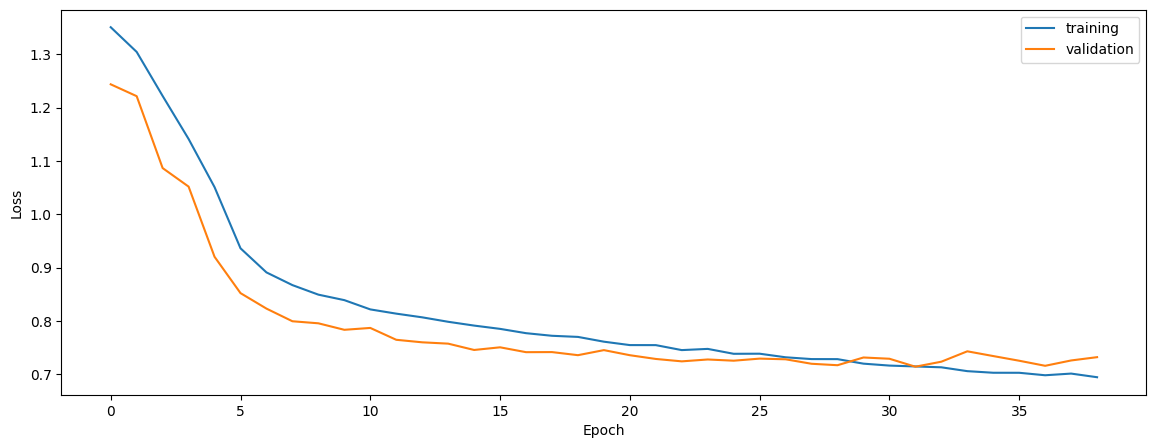

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.7183283899916344
0.7123359509466437
0.696021116007155


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

native
0.7183283899916344
0.7123359509466437
0.696021116007155


In [9]:
print('normalized')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.715394951034857
0.7131697656507867
0.6904491188175099


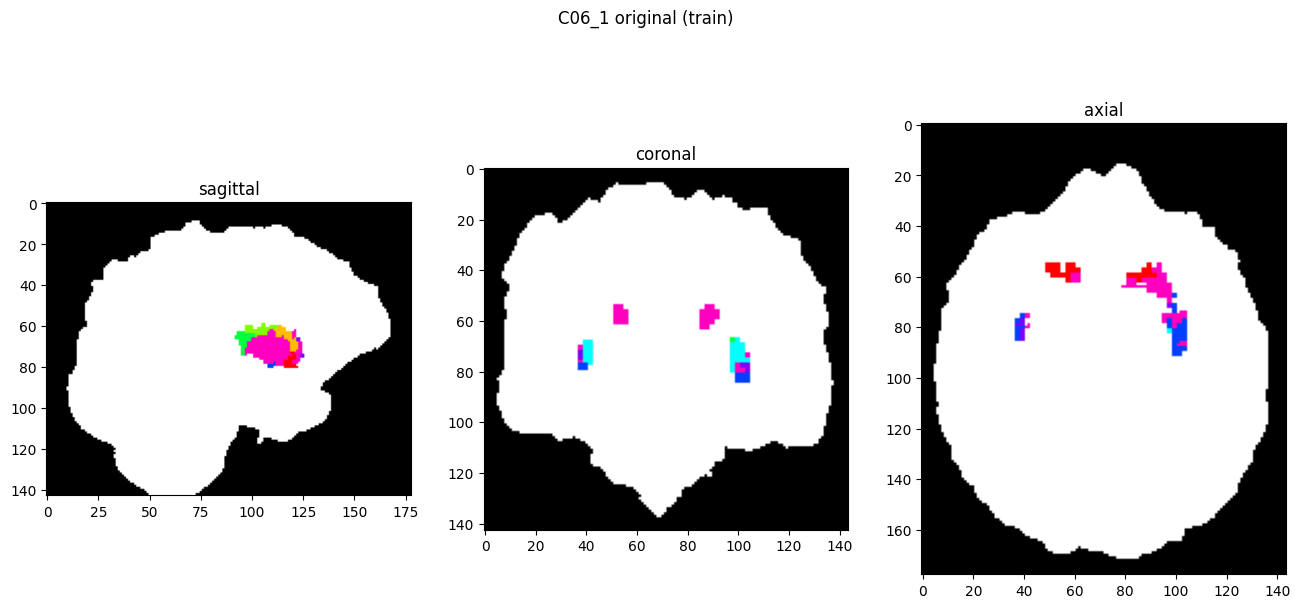

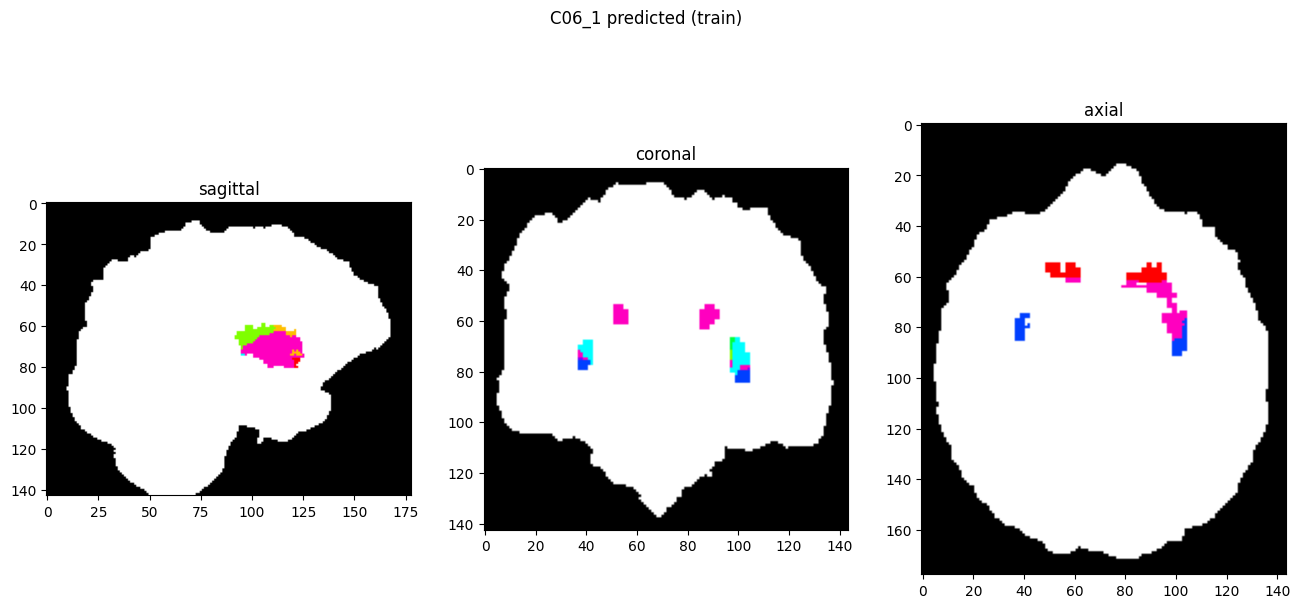

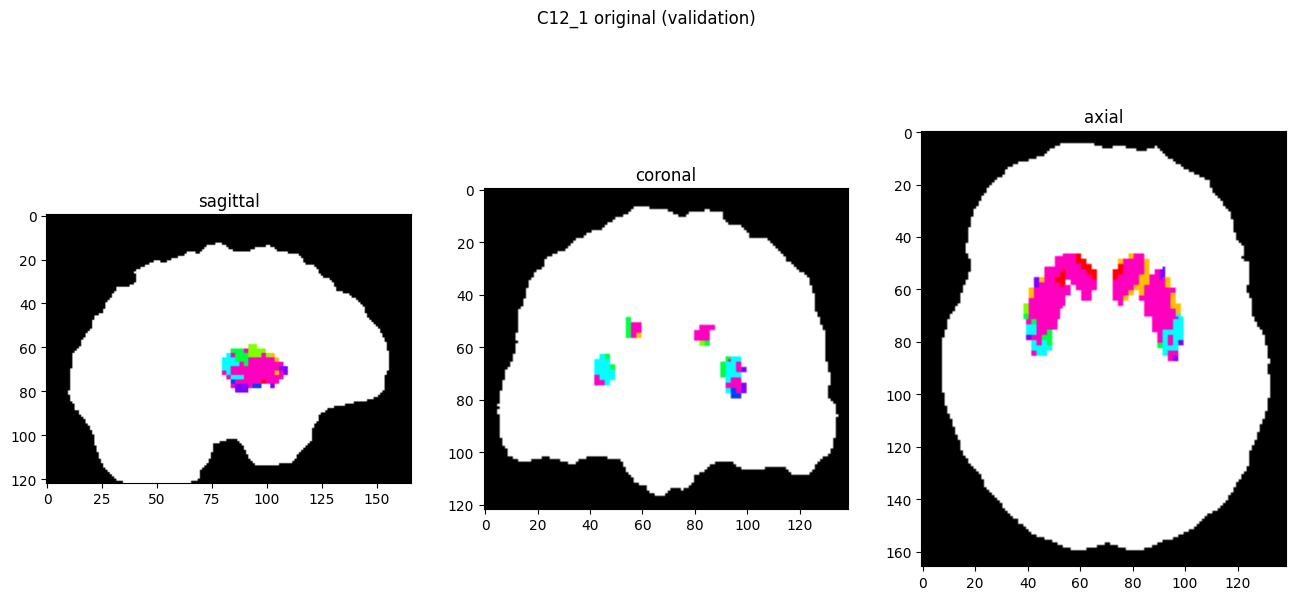

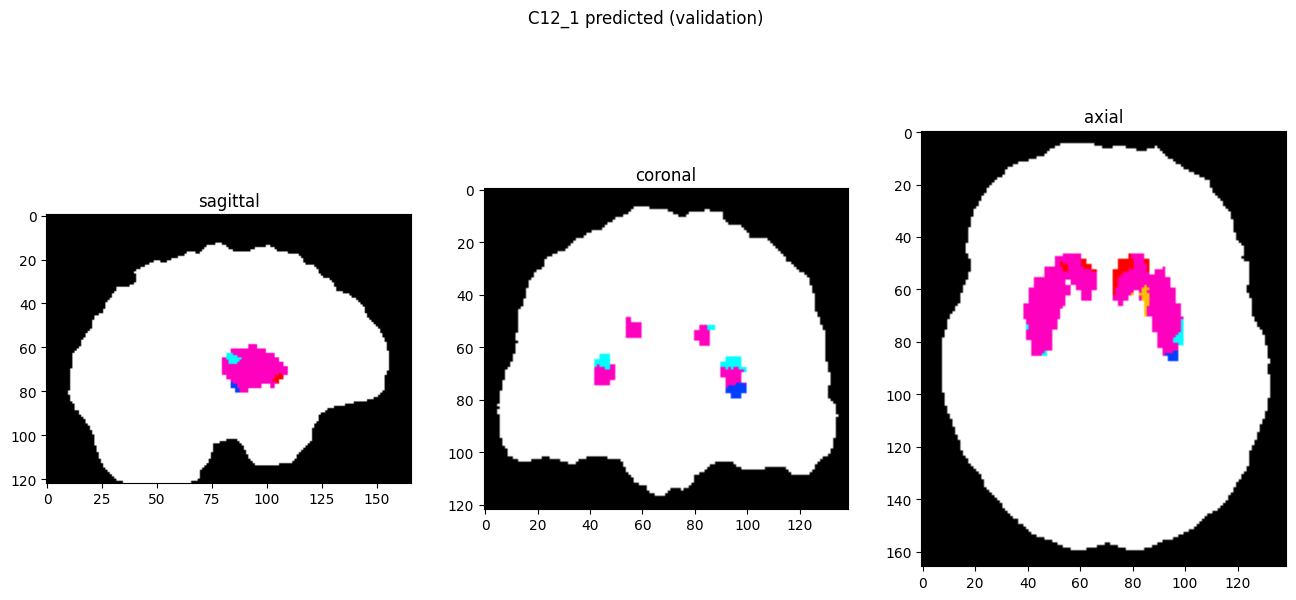

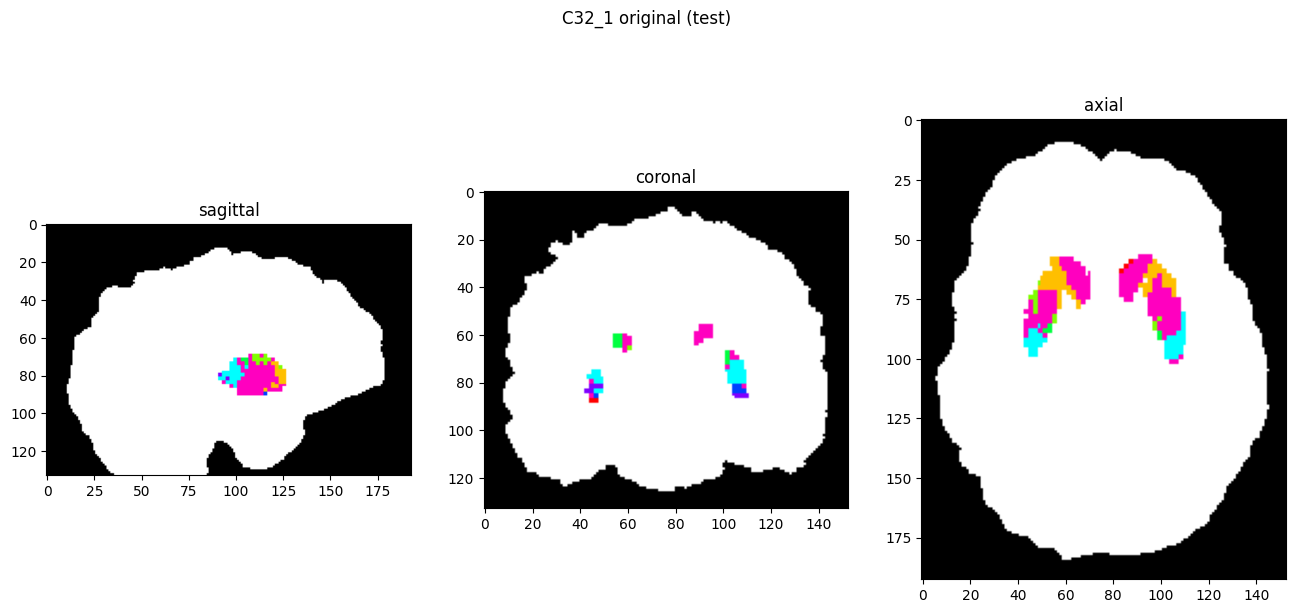

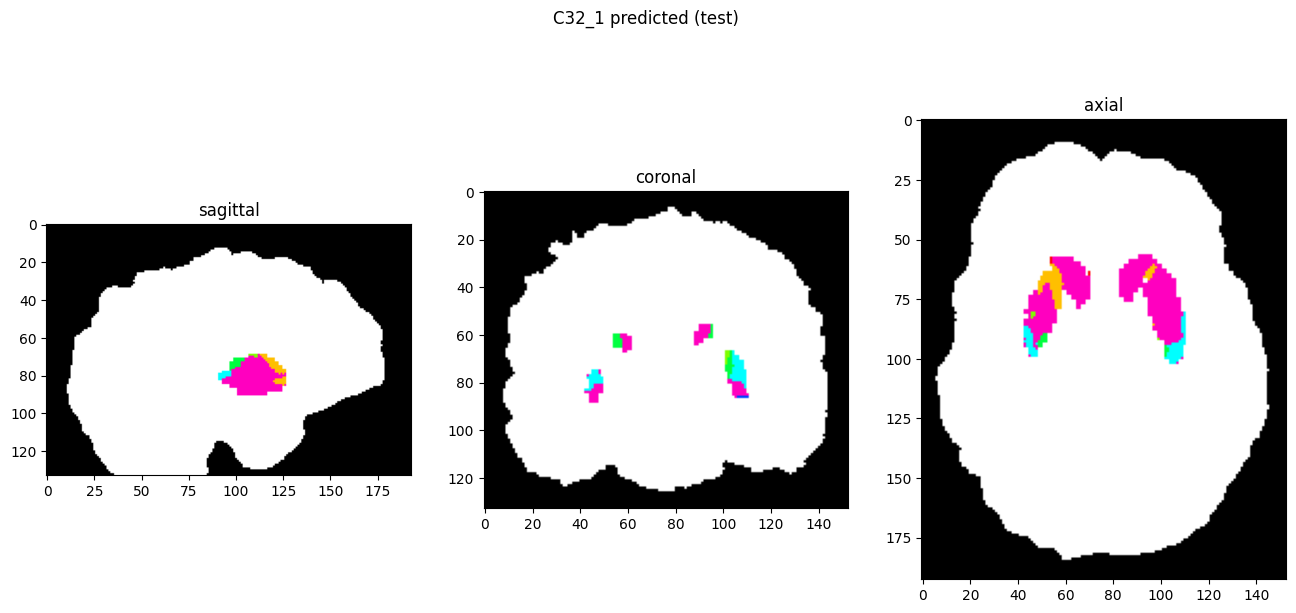

In [10]:
showResults(model, gen, threshold=0)